# Ablation Study for Bilateral Model

In [1]:
# Import library
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# File Paths
fp_project_folder = os.path.join("./")
fp_data_folder = os.path.join(fp_project_folder, "Data")
fp_checkpoint_folder = os.path.join(fp_project_folder, "checkpoints")
fp_actual_data_file = os.path.join(fp_data_folder, "eye_data.csv") 

seed_no = 2024

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load Data

In [3]:
# Dataset column information
input_cols = [
    "Vision Test", "VA", "IOP", "Gradable", "Cup Disc Ratio",
    # OCT
    "OCT RNFL_Abnormal (Progressing)", "OCT RNFL_Abnormal (Stable)",
    "OCT RNFL_Normal", "OCT RNFL_Unreliable", "OCT RNFL_nan",
    # MAC GCA
    "MAC GCA_Abnormal (Progressing)", "MAC GCA_Abnormal (Stable)",
    "MAC GCA_Normal", "MAC GCA_Unreliable", "MAC GCA_nan",
    # HVF
    "HVF_Abnormal (Stable)", "HVF_Normal", "HVF: flat, no IRF/SRF.",
    "HVF_Unreliable", "HVF_nan", "DRF_DH/MA", "DRF_CWS", "DRF_BH",
    # DRF
    "DRF_FH", "DRF_NVE", "DRF_IRMA", "DRF_PRH", "DRF_10M",
    "DMF_DH/MA", "DMF_BH", "DMF_Inner", "DMF_Better", "DMF_HE", 
    # DMF
    "AMDF_DDin", "AMDF_GT125", "AMDF_PA", 
    "AMDF_GA", "AMDF_PED", "AMDF_SFS", "AMDF_SR/subRPE", "AMDF_CNVM", 
    # GSF
    "GSF_RT", "GSF_Notch", "GSF_CDR", "GSF_DA", "GSF_DH",
    # OCTM
    "OCTM_IRF", "OCTM_Normal", "OCTM_Atrophy", "OCTM_ERMpreservedFC",
    "OCTM_Others", "OCTM_ISOSloss", "OCTM_VRtraction", "OCTM_Drusen", 
    "OCTM_ERMdetVA", "OCTM_ERMlossFC", "OCTM_SRF", "OCTM_Ungradable",
    "OCTM_Lamellar", "OCTM_IRHM"
]
intermediate_col_dict = {
    "DMC": ['M0', 'M1', 'M2', 'M3', 'M4', 'NA'],
    "AMDC": ['No','Early','Intermediate','Advanced_1','Advanced_2', "NA"],
    "DRC": ['NoDR', 'MildNPDR', 'ModerateNPDR', 'SevereNPDR', 'ProliferativeDR', 'Unreadable', 'NA'],
    "GSC": ['G0', 'G1', 'NA']
}
tcu_col = 'Total_Time' # Check that this is a string
le_label, re_label = "LE", "RE"
num_input_cols = len(input_cols)
print(num_input_cols)

60


In [4]:
df = pd.read_csv(fp_actual_data_file, index_col=0)
df

Vision Test LE  VA LE  IOP LE  Gradable LE  Cup Disc Ratio LE  \
0               1.0    0.1    13.0          0.0                0.3   
1               1.0    0.0    18.0          1.0                0.4   
2               0.0    0.3    12.0          1.0                0.4   
3               0.0    0.0    17.0          1.0                0.4   
4               1.0    0.2    18.0          1.0                0.2   
..              ...    ...     ...          ...                ...   
863             0.0    0.0    20.0          1.0                0.4   
864             0.0    0.0    18.0          1.0                0.7   
865             1.0    0.1    15.0          1.0                0.4   
866             1.0    0.3    13.0          1.0                0.4   
867             1.0    0.0    17.0          1.0                0.4   

     OCT RNFL_Abnormal (Progressing) LE  OCT RNFL_Abnormal (Stable) LE  \
0                                     0                              0   
1                                     0                              0   
2                                     0                              0   
3                                     0                              0   
4                                     0                              0   
..                                  ...                            ...   
863                                   0                              0   
864                                   0                              0   
865                                   0                              0   
866                                   0                              0   
867                                   0                              0   

     OCT RNFL_Normal LE  OCT RNFL_Unreliable LE  OCT RNFL_nan LE  ...  \
0                     0                       0                1  ...   
1                     0                       0                1  ...   
2                     0                       0                1  ...   
3                     0                       0                1  ...   
4                     0                       0                1  ...   
..                  ...                     ...              ...  ...   
863                   1                       0                0  ...   
864                   1                       0                0  ...   
865                   0                       0                1  ...   
866                   0                       0                1  ...   
867                   0                       0                1  ...   

     DRC_MildNPDR RE  DRC_ModerateNPDR RE  DRC_SevereNPDR RE  \
0                  0                    0                  0   
1                  1                    0                  0   
2                  1                    0                  0   
3                  1                    0                  0   
4                  0                    0                  0   
..               ...                  ...                ...   
863                1                    0                  0   
864                0                    0                  0   
865                0                    0                  0   
866                0                    1                  0   
867                0                    0                  0   

     DRC_ProliferativeDR RE  DRC_Unreadable RE  DRC_NA RE  GSC_G0 RE  \
0                         0                  0          0          1   
1                         0                  0          0          1   
2                         0                  0          0          1   
3                         0                  0          0          1   
4                         0                  0          0          1   
..                      ...                ...        ...        ...   
863                       0                  0          0          1   
864                       0                  0       

In [5]:
def get_feat_col_types(df, input_cols, le_label, re_label):
    bin_cols = []
    cont_cols = []
    all_input_cols = [col+" "+le_label for col in input_cols] + [col+" "+re_label for col in input_cols]
    for col in all_input_cols:
        # If binary
        if ((set(df[col]) == {0, 1}) or (set(df[col]) == {0}) or (set(df[col]) == {1})):
            bin_cols.append(col)
        else:
            cont_cols.append(col)
    return bin_cols, cont_cols
bin_input_cols, cont_input_cols = get_feat_col_types(df, input_cols, le_label, re_label)
print(f"Binary Columns: {bin_input_cols}")
print(f"Continuous Columns: {cont_input_cols}")

Binary Columns: ['Vision Test LE', 'Gradable LE', 'OCT RNFL_Abnormal (Progressing) LE', 'OCT RNFL_Abnormal (Stable) LE', 'OCT RNFL_Normal LE', 'OCT RNFL_Unreliable LE', 'OCT RNFL_nan LE', 'MAC GCA_Abnormal (Progressing) LE', 'MAC GCA_Abnormal (Stable) LE', 'MAC GCA_Normal LE', 'MAC GCA_Unreliable LE', 'MAC GCA_nan LE', 'HVF_Abnormal (Stable) LE', 'HVF_Normal LE', 'HVF: flat, no IRF/SRF. LE', 'HVF_Unreliable LE', 'HVF_nan LE', 'DRF_DH/MA LE', 'DRF_CWS LE', 'DRF_BH LE', 'DRF_FH LE', 'DRF_NVE LE', 'DRF_IRMA LE', 'DRF_PRH LE', 'DRF_10M LE', 'DMF_DH/MA LE', 'DMF_BH LE', 'DMF_Inner LE', 'DMF_Better LE', 'DMF_HE LE', 'AMDF_DDin LE', 'AMDF_GT125 LE', 'AMDF_PA LE', 'AMDF_GA LE', 'AMDF_PED LE', 'AMDF_SFS LE', 'AMDF_SR/subRPE LE', 'AMDF_CNVM LE', 'GSF_RT LE', 'GSF_Notch LE', 'GSF_CDR LE', 'GSF_DA LE', 'GSF_DH LE', 'OCTM_IRF LE', 'OCTM_Normal LE', 'OCTM_Atrophy LE', 'OCTM_ERMpreservedFC LE', 'OCTM_Others LE', 'OCTM_ISOSloss LE', 'OCTM_VRtraction LE', 'OCTM_Drusen LE', 'OCTM_ERMdetVA LE', 'OCTM_ERM

In [6]:
def convert_tcu_label(df, tcu_col):
    df = df.copy()
    unique_tcus = df[tcu_col].unique().tolist()
    unique_tcus.sort()
    new_tcu_cols = []
    for tcu in unique_tcus:
        new_tcu_col = f"{tcu_col} >= {tcu}"
        df[new_tcu_col] = (df[tcu_col] >= tcu).astype(int)
        new_tcu_cols.append(new_tcu_col)
    return df, new_tcu_cols

df, output_cols = convert_tcu_label(df, tcu_col)
display(df)

Vision Test LE  VA LE  IOP LE  Gradable LE  Cup Disc Ratio LE  \
0               1.0    0.1    13.0          0.0                0.3   
1               1.0    0.0    18.0          1.0                0.4   
2               0.0    0.3    12.0          1.0                0.4   
3               0.0    0.0    17.0          1.0                0.4   
4               1.0    0.2    18.0          1.0                0.2   
..              ...    ...     ...          ...                ...   
863             0.0    0.0    20.0          1.0                0.4   
864             0.0    0.0    18.0          1.0                0.7   
865             1.0    0.1    15.0          1.0                0.4   
866             1.0    0.3    13.0          1.0                0.4   
867             1.0    0.0    17.0          1.0                0.4   

     OCT RNFL_Abnormal (Progressing) LE  OCT RNFL_Abnormal (Stable) LE  \
0                                     0                              0   
1                                     0                              0   
2                                     0                              0   
3                                     0                              0   
4                                     0                              0   
..                                  ...                            ...   
863                                   0                              0   
864                                   0                              0   
865                                   0                              0   
866                                   0                              0   
867                                   0                              0   

     OCT RNFL_Normal LE  OCT RNFL_Unreliable LE  OCT RNFL_nan LE  ...  \
0                     0                       0                1  ...   
1                     0                       0                1  ...   
2                     0                       0                1  ...   
3                     0                       0                1  ...   
4                     0                       0                1  ...   
..                  ...                     ...              ...  ...   
863                   1                       0                0  ...   
864                   1                       0                0  ...   
865                   0                       0                1  ...   
866                   0                       0                1  ...   
867                   0                       0                1  ...   

     DRC_NA RE  GSC_G0 RE  GSC_G1 RE  GSC_NA RE  Total_Time  \
0            0          1          0          0        52.0   
1            0          1          0          0        26.0   
2            0          1          0          0        26.0   
3            0          1          0          0        26.0   
4            0          1          0          0        52.0   
..         ...        ...        ...        ...         ...   
863          0          1          0          0        26.0   
864          0          1          0          0        52.0   
865          0          1          0          0        52.0   
866          0          1          0          0        13.0   
867          0          1          0          0        52.0   

     Total_Time >= 1.0  Total_Time >= 4.33  Total_Time >= 13.0  \
0                    1                   1                   1   
1                    1                   1                   1   
2                    1                   1                   1   
3                    1                   1                   1   
4                    1                   1                   1   
..                 ...                 ...                 ...   
863                  1                   1                   1   
864                  1                   1                   1   
865                  1                   1     

In [7]:
def convert_tcu_label_to_onehot(df, tcu_col):
    df = df.copy()
    dummy_df = pd.get_dummies(df[tcu_col], prefix=tcu_col)
    df = pd.concat([df, dummy_df], axis=1)
    return df, dummy_df.columns
df, output_onehot_cols = convert_tcu_label_to_onehot(df, tcu_col)
display(df)

Vision Test LE  VA LE  IOP LE  Gradable LE  Cup Disc Ratio LE  \
0               1.0    0.1    13.0          0.0                0.3   
1               1.0    0.0    18.0          1.0                0.4   
2               0.0    0.3    12.0          1.0                0.4   
3               0.0    0.0    17.0          1.0                0.4   
4               1.0    0.2    18.0          1.0                0.2   
..              ...    ...     ...          ...                ...   
863             0.0    0.0    20.0          1.0                0.4   
864             0.0    0.0    18.0          1.0                0.7   
865             1.0    0.1    15.0          1.0                0.4   
866             1.0    0.3    13.0          1.0                0.4   
867             1.0    0.0    17.0          1.0                0.4   

     OCT RNFL_Abnormal (Progressing) LE  OCT RNFL_Abnormal (Stable) LE  \
0                                     0                              0   
1                                     0                              0   
2                                     0                              0   
3                                     0                              0   
4                                     0                              0   
..                                  ...                            ...   
863                                   0                              0   
864                                   0                              0   
865                                   0                              0   
866                                   0                              0   
867                                   0                              0   

     OCT RNFL_Normal LE  OCT RNFL_Unreliable LE  OCT RNFL_nan LE  ...  \
0                     0                       0                1  ...   
1                     0                       0                1  ...   
2                     0                       0                1  ...   
3                     0                       0                1  ...   
4                     0                       0                1  ...   
..                  ...                     ...              ...  ...   
863                   1                       0                0  ...   
864                   1                       0                0  ...   
865                   0                       0                1  ...   
866                   0                       0                1  ...   
867                   0                       0                1  ...   

     Total_Time >= 1.0  Total_Time >= 4.33  Total_Time >= 13.0  \
0                    1                   1                   1   
1                    1                   1                   1   
2                    1                   1                   1   
3                    1                   1                   1   
4                    1                   1                   1   
..                 ...                 ...                 ...   
863                  1                   1                   1   
864                  1                   1                   1   
865                  1                   1                   1   
866                  1                   1                   1   
867                  1                   1                   1   

     Total_Time >= 26.0  Total_Time >= 52.0  Total_Time_1.0  Total_Time_4.33  \
0                     1                   1           False            False   
1                     1                   0           False            False   
2                     1                   0           False            False   
3                     1                   0           False            False   
4                     1                   1           False            False   
..                  ...                 ...             ...              ...   
863                   1                   0  

## Split Data Set

In [8]:
def split_data_set(df, valid_prop, test_prop, seed=seed_no):
    from numpy import random
    random.seed(seed=seed)
    df_size = len(df)
    train_prop = 1 - valid_prop - test_prop
    train_size, valid_size = round(df_size*train_prop), round(df_size*(train_prop+valid_prop))
    indices = np.arange(df_size)
    np.random.shuffle(indices)
    train_indices, valid_indices, test_indicies = indices[:train_size], indices[train_size:valid_size], indices[valid_size:]
    return df.iloc[train_indices], df.iloc[valid_indices], df.iloc[test_indicies]

train_df, valid_df, test_df = split_data_set(df, valid_prop=0.1, test_prop=0.1, seed=seed_no)
display(train_df)
display(valid_df)
display(test_df)

Vision Test LE  VA LE  IOP LE  Gradable LE  Cup Disc Ratio LE  \
274             1.0    0.0    18.0          1.0                0.7   
126             0.0    0.0    12.0          1.0                0.4   
261             1.0    0.0    14.0          1.0                0.4   
472             0.0    0.2    14.0          1.0                0.6   
648             0.0    0.3    17.0          1.0                0.3   
..              ...    ...     ...          ...                ...   
40              1.0    0.1    14.0          1.0                0.4   
23              1.0    0.1    16.0          1.0                0.4   
164             0.0    0.2    14.0          1.0                0.4   
572             0.0    0.0    17.0          1.0                0.5   
696             0.0    0.0    17.0          1.0                0.4   

     OCT RNFL_Abnormal (Progressing) LE  OCT RNFL_Abnormal (Stable) LE  \
274                                   1                              0   
126                                   0                              0   
261                                   0                              0   
472                                   0                              0   
648                                   0                              0   
..                                  ...                            ...   
40                                    0                              0   
23                                    0                              0   
164                                   0                              0   
572                                   0                              0   
696                                   0                              0   

     OCT RNFL_Normal LE  OCT RNFL_Unreliable LE  OCT RNFL_nan LE  ...  \
274                   0                       0                0  ...   
126                   0                       0                1  ...   
261                   0                       0                1  ...   
472                   0                       0                1  ...   
648                   0                       0                1  ...   
..                  ...                     ...              ...  ...   
40                    0                       0                1  ...   
23                    0                       0                1  ...   
164                   0                       0                1  ...   
572                   0                       0                1  ...   
696                   0                       0                1  ...   

     Total_Time >= 1.0  Total_Time >= 4.33  Total_Time >= 13.0  \
274                  1                   1                   1   
126                  1                   1                   1   
261                  1                   1                   1   
472                  1                   1                   1   
648                  1                   1                   1   
..                 ...                 ...                 ...   
40                   1                   1                   1   
23                   1                   1                   1   
164                  1                   1                   1   
572                  1                   1                   1   
696                  1                   1                   1   

     Total_Time >= 26.0  Total_Time >= 52.0  Total_Time_1.0  Total_Time_4.33  \
274                   0                   0           False            False   
126                   1                   1           False            False   
261                   1                   1           False            False   
472                   1                   0           False            False   
648                   1                   1           False            False   
..                  ...                 ...             ...              ...   
40                    1                   1  

Vision Test LE  VA LE  IOP LE  Gradable LE  Cup Disc Ratio LE  \
776             1.0    0.0    21.0          1.0                0.5   
703             0.0    0.0    21.0          1.0                0.3   
599             0.0    0.3    18.0          1.0                0.4   
548             1.0    0.3    19.0          1.0                0.3   
354             1.0    0.0    10.0          1.0                0.5   
..              ...    ...     ...          ...                ...   
381             0.0    0.0    15.0          1.0                0.5   
254             0.0    0.1    12.0          1.0                0.4   
743             0.0    0.1    15.0          1.0                0.6   
702             0.0    0.1    17.0          1.0                0.6   
663             0.0    0.0    16.0          1.0                0.5   

     OCT RNFL_Abnormal (Progressing) LE  OCT RNFL_Abnormal (Stable) LE  \
776                                   0                              0   
703                                   0                              0   
599                                   0                              0   
548                                   0                              0   
354                                   0                              0   
..                                  ...                            ...   
381                                   0                              0   
254                                   0                              0   
743                                   0                              0   
702                                   0                              0   
663                                   0                              0   

     OCT RNFL_Normal LE  OCT RNFL_Unreliable LE  OCT RNFL_nan LE  ...  \
776                   0                       0                1  ...   
703                   0                       0                1  ...   
599                   0                       0                1  ...   
548                   0                       0                1  ...   
354                   0                       0                1  ...   
..                  ...                     ...              ...  ...   
381                   0                       0                1  ...   
254                   0                       0                1  ...   
743                   1                       0                0  ...   
702                   1                       0                0  ...   
663                   0                       0                1  ...   

     Total_Time >= 1.0  Total_Time >= 4.33  Total_Time >= 13.0  \
776                  1                   1                   1   
703                  1                   1                   1   
599                  1                   1                   0   
548                  1                   1                   1   
354                  1                   1                   1   
..                 ...                 ...                 ...   
381                  1                   1                   1   
254                  1                   1                   1   
743                  1                   1                   1   
702                  1                   1                   1   
663                  1                   1                   1   

     Total_Time >= 26.0  Total_Time >= 52.0  Total_Time_1.0  Total_Time_4.33  \
776                   0                   0           False            False   
703                   0                   0           False            False   
599                   0                   0           False             True   
548                   0                   0           False            False   
354                   1                   1           False            False   
..                  ...                 ...             ...              ...   
381                   1                   0  

Vision Test LE  VA LE  IOP LE  Gradable LE  Cup Disc Ratio LE  \
180             1.0    0.0    19.0          1.0                0.2   
7               0.0    0.4    15.0          1.0                0.3   
808             0.0    0.0    16.0          1.0                0.5   
399             0.0    0.0    21.0          1.0                0.2   
64              0.0    0.3    10.0          1.0                0.4   
..              ...    ...     ...          ...                ...   
549             0.0    0.0    20.0          1.0                0.5   
652             0.0    0.1    14.0          1.0                0.7   
620             0.0    0.0    12.0          0.0                0.4   
516             0.0    0.3    15.0          1.0                0.5   
660             0.0    0.1    21.0          1.0                0.6   

     OCT RNFL_Abnormal (Progressing) LE  OCT RNFL_Abnormal (Stable) LE  \
180                                   0                              0   
7                                     0                              0   
808                                   0                              0   
399                                   0                              0   
64                                    0                              0   
..                                  ...                            ...   
549                                   0                              0   
652                                   0                              0   
620                                   0                              0   
516                                   0                              0   
660                                   0                              0   

     OCT RNFL_Normal LE  OCT RNFL_Unreliable LE  OCT RNFL_nan LE  ...  \
180                   0                       0                1  ...   
7                     0                       0                1  ...   
808                   0                       0                1  ...   
399                   0                       0                1  ...   
64                    0                       0                1  ...   
..                  ...                     ...              ...  ...   
549                   0                       0                1  ...   
652                   1                       0                0  ...   
620                   0                       0                1  ...   
516                   0                       0                1  ...   
660                   0                       0                1  ...   

     Total_Time >= 1.0  Total_Time >= 4.33  Total_Time >= 13.0  \
180                  1                   1                   1   
7                    1                   1                   1   
808                  1                   1                   1   
399                  1                   1                   1   
64                   1                   1                   1   
..                 ...                 ...                 ...   
549                  1                   1                   1   
652                  1                   1                   1   
620                  1                   1                   1   
516                  1                   1                   1   
660                  1                   1                   1   

     Total_Time >= 26.0  Total_Time >= 52.0  Total_Time_1.0  Total_Time_4.33  \
180                   1                   1           False            False   
7                     1                   0           False            False   
808                   1                   0           False            False   
399                   1                   0           False            False   
64                    1                   0           False            False   
..                  ...                 ...             ...              ...   
549                   1                   0  

## Normalise Data

In [9]:
def normalise_data(train_df, valid_df, test_df, cont_input_cols):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(train_df[cont_input_cols])
    train_df.loc[:,cont_input_cols] = scaler.transform(train_df.loc[:,cont_input_cols])
    valid_df.loc[:,cont_input_cols] = scaler.transform(valid_df.loc[:,cont_input_cols])
    test_df.loc[:,cont_input_cols] = scaler.transform(test_df.loc[:,cont_input_cols])
    return train_df, valid_df, test_df, scaler
train_df, valid_df, test_df, scaler = normalise_data(train_df, valid_df, test_df, cont_input_cols)
display(train_df)
display(valid_df)
display(test_df)

Vision Test LE     VA LE    IOP LE  Gradable LE  Cup Disc Ratio LE  \
274             1.0  0.000000  0.769231          1.0           0.894737   
126             0.0  0.000000  0.307692          1.0           0.736842   
261             1.0  0.000000  0.461538          1.0           0.736842   
472             0.0  0.222222  0.461538          1.0           0.842105   
648             0.0  0.333333  0.692308          1.0           0.684211   
..              ...       ...       ...          ...                ...   
40              1.0  0.111111  0.461538          1.0           0.736842   
23              1.0  0.111111  0.615385          1.0           0.736842   
164             0.0  0.222222  0.461538          1.0           0.736842   
572             0.0  0.000000  0.692308          1.0           0.789474   
696             0.0  0.000000  0.692308          1.0           0.736842   

     OCT RNFL_Abnormal (Progressing) LE  OCT RNFL_Abnormal (Stable) LE  \
274                                   1                              0   
126                                   0                              0   
261                                   0                              0   
472                                   0                              0   
648                                   0                              0   
..                                  ...                            ...   
40                                    0                              0   
23                                    0                              0   
164                                   0                              0   
572                                   0                              0   
696                                   0                              0   

     OCT RNFL_Normal LE  OCT RNFL_Unreliable LE  OCT RNFL_nan LE  ...  \
274                   0                       0                0  ...   
126                   0                       0                1  ...   
261                   0                       0                1  ...   
472                   0                       0                1  ...   
648                   0                       0                1  ...   
..                  ...                     ...              ...  ...   
40                    0                       0                1  ...   
23                    0                       0                1  ...   
164                   0                       0                1  ...   
572                   0                       0                1  ...   
696                   0                       0                1  ...   

     Total_Time >= 1.0  Total_Time >= 4.33  Total_Time >= 13.0  \
274                  1                   1                   1   
126                  1                   1                   1   
261                  1                   1                   1   
472                  1                   1                   1   
648                  1                   1                   1   
..                 ...                 ...                 ...   
40                   1                   1                   1   
23                   1                   1                   1   
164                  1                   1                   1   
572                  1                   1                   1   
696                  1                   1                   1   

     Total_Time >= 26.0  Total_Time >= 52.0  Total_Time_1.0  Total_Time_4.33  \
274                   0                   0           False            False   
126                   1                   1           False            False   
261                   1                   1           False            False   
472                   1                   0           False            False   
648                   1                   1           False            False   
..                  ...                 ...             ...      

Vision Test LE     VA LE    IOP LE  Gradable LE  Cup Disc Ratio LE  \
776             1.0  0.000000  1.000000          1.0           0.789474   
703             0.0  0.000000  1.000000          1.0           0.684211   
599             0.0  0.333333  0.769231          1.0           0.736842   
548             1.0  0.333333  0.846154          1.0           0.684211   
354             1.0  0.000000  0.153846          1.0           0.789474   
..              ...       ...       ...          ...                ...   
381             0.0  0.000000  0.538462          1.0           0.789474   
254             0.0  0.111111  0.307692          1.0           0.736842   
743             0.0  0.111111  0.538462          1.0           0.842105   
702             0.0  0.111111  0.692308          1.0           0.842105   
663             0.0  0.000000  0.615385          1.0           0.789474   

     OCT RNFL_Abnormal (Progressing) LE  OCT RNFL_Abnormal (Stable) LE  \
776                                   0                              0   
703                                   0                              0   
599                                   0                              0   
548                                   0                              0   
354                                   0                              0   
..                                  ...                            ...   
381                                   0                              0   
254                                   0                              0   
743                                   0                              0   
702                                   0                              0   
663                                   0                              0   

     OCT RNFL_Normal LE  OCT RNFL_Unreliable LE  OCT RNFL_nan LE  ...  \
776                   0                       0                1  ...   
703                   0                       0                1  ...   
599                   0                       0                1  ...   
548                   0                       0                1  ...   
354                   0                       0                1  ...   
..                  ...                     ...              ...  ...   
381                   0                       0                1  ...   
254                   0                       0                1  ...   
743                   1                       0                0  ...   
702                   1                       0                0  ...   
663                   0                       0                1  ...   

     Total_Time >= 1.0  Total_Time >= 4.33  Total_Time >= 13.0  \
776                  1                   1                   1   
703                  1                   1                   1   
599                  1                   1                   0   
548                  1                   1                   1   
354                  1                   1                   1   
..                 ...                 ...                 ...   
381                  1                   1                   1   
254                  1                   1                   1   
743                  1                   1                   1   
702                  1                   1                   1   
663                  1                   1                   1   

     Total_Time >= 26.0  Total_Time >= 52.0  Total_Time_1.0  Total_Time_4.33  \
776                   0                   0           False            False   
703                   0                   0           False            False   
599                   0                   0           False             True   
548                   0                   0           False            False   
354                   1                   1           False            False   
..                  ...                 ...             ...      

Vision Test LE     VA LE    IOP LE  Gradable LE  Cup Disc Ratio LE  \
180             1.0  0.000000  0.846154          1.0           0.631579   
7               0.0  0.444444  0.538462          1.0           0.684211   
808             0.0  0.000000  0.615385          1.0           0.789474   
399             0.0  0.000000  1.000000          1.0           0.631579   
64              0.0  0.333333  0.153846          1.0           0.736842   
..              ...       ...       ...          ...                ...   
549             0.0  0.000000  0.923077          1.0           0.789474   
652             0.0  0.111111  0.461538          1.0           0.894737   
620             0.0  0.000000  0.307692          0.0           0.736842   
516             0.0  0.333333  0.538462          1.0           0.789474   
660             0.0  0.111111  1.000000          1.0           0.842105   

     OCT RNFL_Abnormal (Progressing) LE  OCT RNFL_Abnormal (Stable) LE  \
180                                   0                              0   
7                                     0                              0   
808                                   0                              0   
399                                   0                              0   
64                                    0                              0   
..                                  ...                            ...   
549                                   0                              0   
652                                   0                              0   
620                                   0                              0   
516                                   0                              0   
660                                   0                              0   

     OCT RNFL_Normal LE  OCT RNFL_Unreliable LE  OCT RNFL_nan LE  ...  \
180                   0                       0                1  ...   
7                     0                       0                1  ...   
808                   0                       0                1  ...   
399                   0                       0                1  ...   
64                    0                       0                1  ...   
..                  ...                     ...              ...  ...   
549                   0                       0                1  ...   
652                   1                       0                0  ...   
620                   0                       0                1  ...   
516                   0                       0                1  ...   
660                   0                       0                1  ...   

     Total_Time >= 1.0  Total_Time >= 4.33  Total_Time >= 13.0  \
180                  1                   1                   1   
7                    1                   1                   1   
808                  1                   1                   1   
399                  1                   1                   1   
64                   1                   1                   1   
..                 ...                 ...                 ...   
549                  1                   1                   1   
652                  1                   1                   1   
620                  1                   1                   1   
516                  1                   1                   1   
660                  1                   1                   1   

     Total_Time >= 26.0  Total_Time >= 52.0  Total_Time_1.0  Total_Time_4.33  \
180                   1                   1           False            False   
7                     1                   0           False            False   
808                   1                   0           False            False   
399                   1                   0           False            False   
64                    1                   0           False            False   
..                  ...                 ...             ...      

In [10]:
data_dfs = dict(
    train_df=train_df, valid_df=valid_df, test_df=test_df
)
col_info = dict(
    input_cols=input_cols, intermediate_col_dict=intermediate_col_dict, output_cols=output_cols,
    output_onehot_cols=output_onehot_cols,
    le_label=le_label, re_label=re_label, 
)
col_info

{'input_cols': ['Vision Test',
  'VA',
  'IOP',
  'Gradable',
  'Cup Disc Ratio',
  'OCT RNFL_Abnormal (Progressing)',
  'OCT RNFL_Abnormal (Stable)',
  'OCT RNFL_Normal',
  'OCT RNFL_Unreliable',
  'OCT RNFL_nan',
  'MAC GCA_Abnormal (Progressing)',
  'MAC GCA_Abnormal (Stable)',
  'MAC GCA_Normal',
  'MAC GCA_Unreliable',
  'MAC GCA_nan',
  'HVF_Abnormal (Stable)',
  'HVF_Normal',
  'HVF: flat, no IRF/SRF.',
  'HVF_Unreliable',
  'HVF_nan',
  'DRF_DH/MA',
  'DRF_CWS',
  'DRF_BH',
  'DRF_FH',
  'DRF_NVE',
  'DRF_IRMA',
  'DRF_PRH',
  'DRF_10M',
  'DMF_DH/MA',
  'DMF_BH',
  'DMF_Inner',
  'DMF_Better',
  'DMF_HE',
  'AMDF_DDin',
  'AMDF_GT125',
  'AMDF_PA',
  'AMDF_GA',
  'AMDF_PED',
  'AMDF_SFS',
  'AMDF_SR/subRPE',
  'AMDF_CNVM',
  'GSF_RT',
  'GSF_Notch',
  'GSF_CDR',
  'GSF_DA',
  'GSF_DH',
  'OCTM_IRF',
  'OCTM_Normal',
  'OCTM_Atrophy',
  'OCTM_ERMpreservedFC',
  'OCTM_Others',
  'OCTM_ISOSloss',
  'OCTM_VRtraction',
  'OCTM_Drusen',
  'OCTM_ERMdetVA',
  'OCTM_ERMlossFC',
  'OCTM

## Model Architecture

In [11]:
tf.keras.utils.get_custom_objects().clear()
class BilateralModel(tf.keras.Model):
    def __init__(
        self,
        input_cols, intermediate_col_dict, output_cols, 
        le_label, re_label,
        ae_width, intermediate_classifier_width, final_classifier_width, 
        rho=0.1, beta=1., **kwargs, 
    ):
        super().__init__(**kwargs)
        from tensorflow import Variable
        from tensorflow.keras import Sequential, Input
        from tensorflow.keras.layers import Dense, Multiply
        
        self.input_cols = Variable(input_cols, trainable=False) # For each eye
        intermediate_cols = []
        intermediate_col_groups = []
        intermediate_col_sizes = []
        for key, col_list in intermediate_col_dict.items():
            for col in col_list:
                intermediate_cols.append(f"{key}_{col}")
            intermediate_col_groups.append(key)
            intermediate_col_sizes.append(len(col_list))
        intermediate_col_sizes=np.array(intermediate_col_sizes)
        # self.intermediate_col_dict = Variable(intermediate_col_dict, trainable=False) # For each eye
        self.intermediate_cols = Variable(intermediate_cols, trainable=False) # For each eye
        self.intermediate_col_groups = Variable(intermediate_col_groups, trainable=False)
        self.intermediate_col_sizes = Variable(intermediate_col_sizes, trainable=False)
        self.output_cols = Variable(output_cols, trainable=False) # For each eye

        self.le_label = Variable(le_label, trainable=False) 
        self.re_label = Variable(re_label, trainable=False) 

        self.num_input_cols = Variable(len(input_cols), trainable=False)
        self.num_intermediate_cols = Variable(len(intermediate_cols), trainable=False)
        self.num_output_cols = Variable(len(output_cols), trainable=False)

        self.ae_width = Variable(ae_width, trainable=False)
        self.intermediate_classifier_width = Variable(intermediate_classifier_width, trainable=False)
        self.final_classifier_width = Variable(final_classifier_width, trainable=False)

        self.rho = Variable(rho, trainable=False)
        self.beta = Variable(beta, trainable=False)

        num_input_cols = self.num_input_cols.numpy()
        num_intermediate_cols = self.num_intermediate_cols.numpy()
        num_output_cols = self.num_output_cols.numpy()
        
        # Autoencoder (Learns structure of data in an unsupervised manner)
        self.encoder = Sequential([
            Input(shape=(num_input_cols,)),
            Dense(ae_width, activation="relu"),
            Dense(ae_width, activation="relu"),
            Dense(ae_width, activation="relu", 
                  activity_regularizer=SparseRegularizer(rho = rho, beta = beta)), # Induce sparsity on this layer
        ], name="encoder")
        self.decoder = Sequential([
            Input(shape=(ae_width,)),
            Dense(ae_width, activation="relu"),
            Dense(ae_width, activation="relu"),
            Dense(num_input_cols)
        ], name="decoder")

        # Intermediate Classifier Layer (E.g. Maps from encoded features to diagnosis for each eye)
        self.intermediate_classifier = GroupedSoftmaxDenseLayer(
            input_width = ae_width,
            intermediate_col_sizes=intermediate_col_sizes, 
            num_layers_per_intermediate_classifier=3, 
            intermediate_classifier_width=intermediate_classifier_width,
            name="intermediate_classifier"
        )
        
        # concatenate softmax outputs
        self.concatenate = tf.keras.layers.Concatenate()

        # Final Classifier Layer (E.g. Maps from diagnosis for each eye to TCU for this eye)
        self.final_classifier = Sequential([
            Input(shape=((num_intermediate_cols,))),
            Dense(final_classifier_width, activation="relu"),
            Dense(final_classifier_width, activation="relu"),
            Dense(num_output_cols, activation="sigmoid"), 
        ], name="final_classifier")
        # Citation: https://ieeexplore.ieee.org.remotexs.ntu.edu.sg/stamp/stamp.jsp?tp=&arnumber=4633963
        # Output class should be processed like this:
        # - Most severe: [0, 0, 0], Least severe: [1, 1, 1]

        # E.g. Get diagnosis of both eyes:
        # [0, 0, 0] * [1, 1, 1] = [0, 0, 0] (the TCU of the most severe eye)
        self.multiply = Multiply(name="and")

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32)])
    def predict_ae_each(self, x):
        # Encode
        output = self.encoder(x)
        # Decode
        output = self.decoder(output)
        return output

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32)])
    def predict_intermediate_classifier_each(self, x):
        # Encode
        output = self.encoder(x)
        # Classify intermediate output
        output = self.intermediate_classifier(output)
        return output

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32)])
    def predict_final_classifier_each(self, x):
        # Encode
        output = self.encoder(x)
        # Classify intermediate output
        output = self.intermediate_classifier(output)
        # Concatenate individual softmax classifiers
        output = self.concatenate(output)
        # Classify final output
        output = self.final_classifier(output)
        return output

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32),
        tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32)]
    )
    def predict_final_classifier_both(self, x1, x2):
        # Assume x1 and x2 are aligned
        # For x1
        # - Encode
        output1 = self.encoder(x1)
        
        # - Classify intermediate output
        output1 = self.intermediate_classifier(output1)
        # Concatenate individual softmax classifiers
        output1 = self.concatenate(output1)
        # - Classify final output
        output1 = self.final_classifier(output1)

        # For x2
        # - Encode
        output2 = self.encoder(x2)
        # - Classify intermediate output
        output2 = self.intermediate_classifier(output2)
        # Concatenate individual softmax classifiers
        output2 = self.concatenate(output2)
        # - Classify final output
        output2 = self.final_classifier(output2)

        # Get final class
        output = self.multiply([output1, output2])
        return output

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32),
        tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32)]
    )
    def predict_everything(self, x1, x2):
        # Assume x1 and x2 are aligned
        # For x1
        # - Encode
        encoder1 = self.encoder(x1)
        # - Decode
        decoder1 = self.decoder(encoder1)
        # - Classify intermediate output
        ic1 = self.intermediate_classifier(encoder1)
        # Concatenate individual softmax classifiers
        ic1 = self.concatenate(ic1)
        # - Classify final output
        fc1 = self.final_classifier(ic1)

        # For x2
        # - Encode
        encoder2 = self.encoder(x2)
        # - Decode
        decoder2 = self.decoder(encoder2)
        # - Classify intermediate output
        ic2 = self.intermediate_classifier(encoder2)
        # Concatenate individual softmax classifiers
        ic2 = self.concatenate(ic2)
        # - Classify final output
        fc2 = self.final_classifier(ic2)

        # Get final class
        output = self.multiply([fc1, fc2])

        predict_dict = dict(
            encoder1=encoder1, encoder2=encoder2,
            decoder1=decoder1, decoder2=decoder2,
            ic1=ic1, ic2=ic2,
            fc1=fc1, fc2=fc2,
            output=output
        )
        return predict_dict
    
    def call(self, x1, x2):
        return self.predict_final_classifier_both(x1, x2)
        
@tf.keras.utils.register_keras_serializable(package="MyGroupedSoftmaxDenseLayers")
class GroupedSoftmaxDenseLayer(tf.keras.layers.Layer):
    def __init__(
      self, input_width, intermediate_col_sizes, num_layers_per_intermediate_classifier, intermediate_classifier_width, name=None):
        super(GroupedSoftmaxDenseLayer, self).__init__(name=name)
        from tensorflow.keras.layers import Dense
        from tensorflow.keras import Sequential, Input
        self.input_width = input_width
        self.intermediate_col_sizes = intermediate_col_sizes
        self.num_layers_per_intermediate_classifier = num_layers_per_intermediate_classifier
        self.intermediate_classifier_width = intermediate_classifier_width
        
        self.layers = []
        for col_size in intermediate_col_sizes:
            cur_int_classifier = Sequential()
            cur_int_classifier.add(Input(shape=((input_width,))))
            for i in range(num_layers_per_intermediate_classifier):
                cur_int_classifier.add(
                    Dense(intermediate_classifier_width, activation="relu"))
            cur_int_classifier.add(Dense(col_size, activation="softmax"))
            self.layers.append(cur_int_classifier)

    def call(self, inputs):
        outputs = []
        for layer in self.layers:
            output = layer(inputs)
            outputs.append(output)
        return outputs
      
    def get_config(self):
        return {
            'input_width': self.input_width,
            'intermediate_col_sizes': self.intermediate_col_sizes,
            'num_layers_per_intermediate_classifier': self.num_layers_per_intermediate_classifier,
            'intermediate_classifier_width': self.intermediate_classifier_width,
            "name": self.name
        }
        
# For Sparsity, from: https://stackoverflow.com/questions/36913281/how-do-i-correctly-implement-a-custom-activity-regularizer-in-keras
# https://web.stanford.edu/class/cs294a/sparseAutoencoder.pdf
# https://ieeexplore.ieee.org.remotexs.ntu.edu.sg/abstract/document/7280364
# https://serp.ai/sparse-autoencoder/ (Why KL Divergence)
@tf.keras.utils.register_keras_serializable(package="MyRegularizers")
class SparseRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, rho = 0.01,beta = 1):
        """
        rho  : Desired average activation of the hidden units
        beta : Weight of sparsity penalty term
        """
        self.rho = rho
        self.beta = beta
        
    def __call__(self, activation):
        # sigmoid because we need the probability distributions
        activation = tf.nn.sigmoid(activation)
        # average over the batch samples (Proportion of samples that have this node activated)
        rho_bar = tf.keras.backend.mean(activation, axis=0)
        # Avoid division by 0
        rho_bar = tf.keras.backend.maximum(rho_bar, 1e-10) 
        # KL divergence with bernoulli distribution where p = rho 
        KLs = self.rho*tf.keras.backend.log(self.rho/rho_bar) + (1-self.rho)*tf.keras.backend.log((1-self.rho)/(1-rho_bar))
        # sum over the layer units
        return self.beta * tf.keras.backend.sum(KLs) 
        
    def get_config(self):
        return {
            'rho': self.rho,
            'beta': self.beta
        }

def get_ae_model(model):
    input = tf.keras.Input(shape=(int(num_input_cols)))
    output = model.encoder(input)
    output = model.decoder(output)
    return tf.keras.Model(inputs=input, outputs=output, name="ae")

def get_intermediate_classifier_model(model):
    input = tf.keras.Input(shape=(num_input_cols,))
    output = model.encoder(input)
    output = model.intermediate_classifier(output)
    return tf.keras.Model(inputs=input, outputs=output, name="intermediate_classifier")

def get_final_classifier_model(model):
    input1 = tf.keras.Input(shape=(num_input_cols,))
    input2 = tf.keras.Input(shape=(num_input_cols,))
    output1 = model.encoder(input1)
    output1 = model.intermediate_classifier(output1)
    output1 = model.concatenate(output1)
    output1 = model.final_classifier(output1)
    output2 = model.encoder(input2)
    output2 = model.intermediate_classifier(output2)
    output2 = model.concatenate(output2)
    output2 = model.final_classifier(output2)
    output = model.multiply([output1, output2])
    return tf.keras.Model(inputs=[input1, input2], outputs=output, name="final_classifier")

## Training Code

In [19]:
batch_size = 16 # CHANGE THIS
max_epochs = 10000 # CHANGE THIS

def set_seed(seed):
    import os
    import random
    tf.config.experimental.enable_op_determinism()
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def plot_history(history, metrics_list, title=None):
    from math import ceil
    number_of_plots = len(metrics_list)
    subplot_width, subplot_height = 4, 2
    max_num_cols = 3
    if number_of_plots > max_num_cols:
        num_rows = ceil(number_of_plots/max_num_cols)
        num_cols = max_num_cols
    else:
        num_rows = 1
        num_cols = number_of_plots
        
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(subplot_width*num_cols, subplot_height*num_rows), dpi=128)
    if num_rows > 1:
        axes = axes.flatten()
    
    for i, metric in enumerate(metrics_list):
        if number_of_plots > 1:
            ax = axes[i]
        else:
            ax = axes
        # print(history.history.keys())
        ax.plot(history.history[f'{metric}'])
        ax.plot(history.history[f'val_{metric}'])
        ax.set_ylabel(f'{metric}'.capitalize())
        ax.set_xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='center left', bbox_to_anchor=(1, 0.5))
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

def get_best_val_loss(history, metric):
    best_epoch = np.argmin(history.history["val_loss"])
    best_val_loss = min(history.history["val_loss"])
    best_val_loss_wo_sparsity = history.history[f"val_{metric}"][best_epoch]
    return best_val_loss, best_val_loss_wo_sparsity, best_epoch

def display_tuning_df(tuning_df):
    def highlight_sentiment(row):
        if row["best_hyperparameter"]:
            return ['background-color: #cafae6'] * len(row)
        else:
            return [''] * len(row)
    return tuning_df.style.apply(highlight_sentiment, axis=1)

#### AE Train Functions
def preprocess_data_for_ae(df, input_cols, le_label, re_label):
    df = df.copy()
    le_cols = [feat_col + f" {le_label}" for feat_col in input_cols]
    re_cols = [feat_col + f" {re_label}" for feat_col in input_cols]
    left_eye_df = df[le_cols].rename(columns={old_col:input_cols[i] for i, old_col in enumerate(le_cols)})
    right_eye_df = df[re_cols].rename(columns={old_col:input_cols[i] for i, old_col in enumerate(re_cols)})
    df = pd.concat([left_eye_df, right_eye_df])
    return df.values

def train_ae(
    bilateral_model, train_df, valid_df, test_df, 
    batch_size, max_epochs, patience=20, verbose=1, seed=seed_no
):
    # Set Seed
    set_seed(seed)

    # Get feature col information from model
    input_cols = list(bilateral_model.input_cols.numpy().astype('str'))
    le_label = bilateral_model.le_label.numpy().decode("utf-8")
    re_label = bilateral_model.re_label.numpy().decode("utf-8")

    # Preprocess data
    train_X = preprocess_data_for_ae(train_df, input_cols, le_label, re_label)
    valid_X = preprocess_data_for_ae(valid_df, input_cols, le_label, re_label)

    # Create ae model from bilateral model
    temp_ae_model = get_ae_model(bilateral_model)

    # Train ae model
    temp_ae_model.compile(optimizer="adam", loss="mse", metrics=["mse"])
    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True,
    )
    history = temp_ae_model.fit(
        x=train_X, y=train_X, validation_data=(valid_X, valid_X),
        batch_size=batch_size, epochs=max_epochs, shuffle=True,
        callbacks=[es], verbose=verbose, 
    )
    plot_history(history, metrics_list=["loss"], title="Autoencoder Training History")
    best_val_performance, best_val_performance_wo_sparsity, best_epoch = get_best_val_loss(history, metric="mse")

    # Freeze layers
    bilateral_model.encoder.trainable = False
    bilateral_model.decoder.trainable = False
    
    return best_val_performance, best_val_performance_wo_sparsity, best_epoch

def evaluate_ae(bilateral_model, train_df, valid_df, test_df):
    # Get feature col information from model
    input_cols = list(bilateral_model.input_cols.numpy().astype('str'))
    le_label = bilateral_model.le_label.numpy().decode("utf-8")
    re_label = bilateral_model.re_label.numpy().decode("utf-8")
    
    # Create ae model from bilateral model
    temp_ae_model = get_ae_model(bilateral_model)
    
    # Preprocess data
    train_X = preprocess_data_for_ae(train_df, input_cols, le_label, re_label)
    valid_X = preprocess_data_for_ae(valid_df, input_cols, le_label, re_label)
    test_X = preprocess_data_for_ae(test_df, input_cols, le_label, re_label)
    
    # Evaluate ae model
    train_X_pred = temp_ae_model.predict(train_X)
    valid_X_pred = temp_ae_model.predict(valid_X)
    test_X_pred = temp_ae_model.predict(test_X)
    def mse(actual, pred):
        return np.mean(np.square(actual-pred))
    train_mse = mse(train_X, train_X_pred)
    valid_mse = mse(valid_X, valid_X_pred)
    test_mse = mse(test_X, test_X_pred)
    perf_df = pd.DataFrame({"Train": [train_mse], "Valid": [valid_mse], "Test": [test_mse]})
    perf_df.index = ["Autoencoder MSE"]

    # Output predictions
    all_X = np.concatenate((train_X, valid_X, test_X), axis=0)
    all_X_pred = np.concatenate((train_X_pred, valid_X_pred, test_X_pred), axis=0)
    array = np.concatenate((all_X, all_X_pred), axis=1)
    colnames = input_cols + [feat_col+"_pred" for feat_col in input_cols]
    pred_df = pd.DataFrame(array, columns=colnames)
    split_labels = (
        ["train" for i in range(len(train_X))] + ["valid" for i in range(len(valid_X))] + 
        ["test" for i in range(len(test_X))])
    pred_df["split"] = split_labels
    return perf_df, pred_df

#### Intermediate Classifier Train Functions
def preprocess_data_for_ic(df, input_cols, intermediate_cols, intermediate_col_sizes, le_label, re_label):
    df = df.copy()
    all_cols = input_cols + intermediate_cols
    le_cols = [feat_col + f" {le_label}" for feat_col in all_cols]
    re_cols = [feat_col + f" {re_label}" for feat_col in all_cols]
    left_eye_df = df[le_cols].rename(columns={old_col:all_cols[i] for i, old_col in enumerate(le_cols)})
    right_eye_df = df[re_cols].rename(columns={old_col:all_cols[i] for i, old_col in enumerate(re_cols)})
    df = pd.concat([left_eye_df, right_eye_df])
    start = 0
    output = []
    for size in intermediate_col_sizes:
        output.append(df[intermediate_cols[start:start+size]].values)
        start += size
    return df[input_cols].values, output

def train_intermediate_classifier(
    bilateral_model, train_df, valid_df, test_df, 
    batch_size, max_epochs, patience=20, verbose=1, seed=seed_no,
    get_ic_function=get_intermediate_classifier_model, title="Intermediate Classifier Training History" 
):
    # Set Seed
    set_seed(seed)

    # Get feature col information from model
    input_cols = list(bilateral_model.input_cols.numpy().astype('str'))
    intermediate_cols = list(bilateral_model.intermediate_cols.numpy().astype('str'))
    intermediate_col_groups = list(bilateral_model.intermediate_col_groups.numpy().astype('str'))
    intermediate_col_sizes = list(bilateral_model.intermediate_col_sizes.numpy())
    num_intermediate_col_groups = len(intermediate_col_groups)
    le_label = bilateral_model.le_label.numpy().decode("utf-8")
    re_label = bilateral_model.re_label.numpy().decode("utf-8")

    # Preprocess data
    train_X, train_Y = preprocess_data_for_ic(train_df, input_cols, intermediate_cols, intermediate_col_sizes, le_label, re_label)
    valid_X, valid_Y = preprocess_data_for_ic(valid_df, input_cols, intermediate_cols, intermediate_col_sizes, le_label, re_label)

    # Create ic model from bilateral model
    temp_ic_model = get_ic_function(bilateral_model)

    # Train ic model
    temp_ic_model.compile(
        optimizer="adam", 
        loss=["categorical_crossentropy" for i in range(num_intermediate_col_groups)],
        metrics=["categorical_crossentropy", "accuracy"]
    )
    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True,
    )
    history = temp_ic_model.fit(
        x=train_X, y=train_Y, validation_data=(valid_X, valid_Y),
        batch_size=batch_size, epochs=max_epochs, shuffle=True,
        callbacks=[es], verbose=verbose, 
    )
    plot_history(
        history, metrics_list=["loss"]+[
            metric for metric in history.history.keys() if (("val" not in metric) and ("accuracy" in metric))], 
        title=title
    )
    new_loss = None
    for metric, metric_values in history.history.items():
        if (("val" in metric) and ("categorical_crossentropy" in metric)):
            if new_loss is None:
                new_loss = np.array(metric_values)
            else:
                new_loss = new_loss+np.array(metric_values)
    history.history["val_categorical_crossentropy"] = new_loss
    best_val_performance, best_val_performance_wo_sparsity, best_epoch = get_best_val_loss(
        history, metric="categorical_crossentropy")

    # Freeze layers
    bilateral_model.intermediate_classifier.trainable = False
    
    return best_val_performance, best_val_performance_wo_sparsity, best_epoch

def evaluate_ic(
    bilateral_model, train_df, valid_df, test_df,
    get_ic_function=get_intermediate_classifier_model
):
    # Get feature col information from model
    input_cols = list(bilateral_model.input_cols.numpy().astype('str'))
    intermediate_cols = list(bilateral_model.intermediate_cols.numpy().astype('str'))
    intermediate_col_sizes = list(bilateral_model.intermediate_col_sizes.numpy())
    intermediate_col_groups = list(bilateral_model.intermediate_col_groups.numpy().astype('str'))
    le_label = bilateral_model.le_label.numpy().decode("utf-8")
    re_label = bilateral_model.re_label.numpy().decode("utf-8")
    
    # Create ic model from bilateral model
    temp_ic_model = get_ic_function(bilateral_model)
    
    # Preprocess data
    train_X, train_Y = preprocess_data_for_ic(train_df, input_cols, intermediate_cols, intermediate_col_sizes, le_label, re_label)
    valid_X, valid_Y = preprocess_data_for_ic(valid_df, input_cols, intermediate_cols, intermediate_col_sizes, le_label, re_label)
    test_X, test_Y = preprocess_data_for_ic(test_df, input_cols, intermediate_cols, intermediate_col_sizes, le_label, re_label)
    
    # Evaluate ae model
    train_Y_pred = temp_ic_model.predict(train_X)
    valid_Y_pred = temp_ic_model.predict(valid_X)
    test_Y_pred = temp_ic_model.predict(test_X)
    def per_intermediate_class_score(actual, pred, score_func):
        all_score = []
        all_score_cols = []
        index = 0
        for col_group, col_size in zip(intermediate_col_groups, intermediate_col_sizes):
            col_actual = actual[index]
            col_pred = pred[index]
            # print(col_actual, col_pred)
            col_score = score_func(col_actual, col_pred)
            index += 1
            all_score.append(col_score)
            all_score_cols.append(f"{col_group} {score_func.__name__.capitalize()}")
        return all_score, all_score_cols
    def accuracy(actual, pred):
        actual_index = np.argmax(actual, axis=-1)
        pred_index = np.argmax(pred, axis=-1)
        acc = np.mean(actual_index==pred_index)
        return acc
    train_ic_accuracy, _ = per_intermediate_class_score(train_Y, train_Y_pred, accuracy)
    valid_ic_accuracy, _ = per_intermediate_class_score(valid_Y, valid_Y_pred, accuracy)
    test_ic_accuracy, acc_cols = per_intermediate_class_score(test_Y, test_Y_pred, accuracy)
    def f1_score(actual, pred):
        actual_index = np.argmax(actual, axis=-1)
        pred_index = np.argmax(pred, axis=-1)
        from sklearn.metrics import f1_score
        f1 = f1_score(actual_index, pred_index, average='macro')
        return f1
    train_ic_f1, _ = per_intermediate_class_score(train_Y, train_Y_pred, f1_score)
    valid_ic_f1, _ = per_intermediate_class_score(valid_Y, valid_Y_pred, f1_score)
    test_ic_f1, f1_cols = per_intermediate_class_score(test_Y, test_Y_pred, f1_score)
    def categorical_crossentropy(actual, pred):
        return np.mean(
            tf.keras.metrics.categorical_crossentropy(actual, pred))
    train_crossentropy, _ = per_intermediate_class_score(train_Y, train_Y_pred, categorical_crossentropy)
    valid_crossentropy, _ = per_intermediate_class_score(valid_Y, valid_Y_pred, categorical_crossentropy)
    test_crossentropy, crossentropy_cols = per_intermediate_class_score(test_Y, test_Y_pred, categorical_crossentropy)
    perf_df = pd.DataFrame({
        "Train": train_crossentropy+train_ic_accuracy+train_ic_f1, 
        "Valid": valid_crossentropy+valid_ic_accuracy+valid_ic_f1, 
        "Test": test_crossentropy+test_ic_accuracy+test_ic_f1})
    perf_df.index = crossentropy_cols+acc_cols+f1_cols

    # Output predictions
    # test_Y from [num_groups, num_samples, num_cols]
    train_Y = np.concatenate(train_Y, axis=1)
    train_Y_pred = np.concatenate(train_Y_pred, axis=1)
    valid_Y = np.concatenate(valid_Y, axis=1)
    valid_Y_pred = np.concatenate(valid_Y_pred, axis=1)
    test_Y = np.concatenate(test_Y, axis=1)
    test_Y_pred = np.concatenate(test_Y_pred, axis=1)
    # print(test_Y.shape)
    all_Y = np.concatenate((train_Y, valid_Y, test_Y), axis=0)
    all_Y_pred = np.concatenate((train_Y_pred, valid_Y_pred, test_Y_pred), axis=0)
    array = np.concatenate((all_Y, all_Y_pred), axis=1)
    colnames = intermediate_cols + [inter_col+"_pred" for inter_col in intermediate_cols]
    pred_df = pd.DataFrame(array, columns=colnames)
    split_labels = (
        ["train" for i in range(len(train_Y))] + ["valid" for i in range(len(valid_Y))] + 
        ["test" for i in range(len(test_Y))])
    pred_df["split"] = split_labels
    return perf_df, pred_df

#### Final Classifier Train Functions
def preprocess_data_for_fc(df, input_cols, output_cols, le_label, re_label):
    df = df.copy()
    le_cols = [feat_col + f" {le_label}" for feat_col in input_cols]
    re_cols = [feat_col + f" {re_label}" for feat_col in input_cols]
    return (df[le_cols].values, df[re_cols].values), df[output_cols].values
    
def train_final_classifier(
    bilateral_model, train_df, valid_df, test_df, 
    batch_size, max_epochs, patience=20, verbose=1, seed=seed_no, 
    get_fc_function=get_final_classifier_model, title="Final Classifier Training History" 
):
    # Set Seed
    set_seed(seed)

    # Get feature col information from model
    input_cols = list(bilateral_model.input_cols.numpy().astype('str'))
    output_cols = list(bilateral_model.output_cols.numpy().astype('str'))
    le_label = bilateral_model.le_label.numpy().decode("utf-8")
    re_label = bilateral_model.re_label.numpy().decode("utf-8")
    
    # Preprocess data
    train_X, train_Y = preprocess_data_for_fc(train_df, input_cols, output_cols, le_label, re_label)
    valid_X, valid_Y = preprocess_data_for_fc(valid_df, input_cols, output_cols, le_label, re_label)

    # Create ic model from bilateral model
    temp_fc_model = get_fc_function(bilateral_model)

    # Train ic model
    temp_fc_model.compile(
        optimizer="adam", loss="binary_crossentropy",  metrics=["binary_crossentropy", "binary_accuracy"])
    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True,
    )
    history = temp_fc_model.fit(
        x=train_X, y=train_Y, validation_data=(valid_X, valid_Y),
        batch_size=batch_size, epochs=max_epochs, shuffle=True,
        callbacks=[es], verbose=verbose, 
    )
    plot_history(history, metrics_list=["loss", "binary_accuracy"], title=title)
    best_val_performance, best_val_performance_wo_sparsity, best_epoch = get_best_val_loss(history, metric="binary_crossentropy")

    # Freeze layers
    bilateral_model.final_classifier.trainable = False
    
    return best_val_performance, best_val_performance_wo_sparsity, best_epoch

def evaluate_fc(bilateral_model, train_df, valid_df, test_df, get_fc_function=get_final_classifier_model):
    # Create ic model from bilateral model
    temp_fc_model = get_fc_function(bilateral_model)

    # Get feature col information from model
    input_cols = list(bilateral_model.input_cols.numpy().astype('str'))
    output_cols = list(bilateral_model.output_cols.numpy().astype('str'))
    le_label = bilateral_model.le_label.numpy().decode("utf-8")
    re_label = bilateral_model.re_label.numpy().decode("utf-8")
    
    # Preprocess data
    train_X, train_Y = preprocess_data_for_fc(train_df, input_cols, output_cols, le_label, re_label)
    valid_X, valid_Y = preprocess_data_for_fc(valid_df, input_cols, output_cols, le_label, re_label)
    test_X, test_Y = preprocess_data_for_fc(test_df, input_cols, output_cols, le_label, re_label)

    # Evaluate ae model
    train_Y_pred = temp_fc_model.predict(train_X)
    valid_Y_pred = temp_fc_model.predict(valid_X)
    test_Y_pred = temp_fc_model.predict(test_X)
    def binary_accuracy(actual, pred):
        return np.mean(
            tf.keras.metrics.binary_accuracy(actual, pred))
    train_bin_acc = binary_accuracy(train_Y, train_Y_pred)
    valid_bin_acc = binary_accuracy(valid_Y, valid_Y_pred)
    test_bin_acc = binary_accuracy(test_Y, test_Y_pred)
    def accuracy(actual, pred):
        pred = pred > 0.5
        return np.mean(np.all(actual == pred, axis=-1))
    train_acc = accuracy(train_Y, train_Y_pred)
    valid_acc = accuracy(valid_Y, valid_Y_pred)
    test_acc = accuracy(test_Y, test_Y_pred)
    def binary_crossentropy(actual, pred):
        return np.mean(
            tf.keras.metrics.binary_crossentropy(actual, pred))
    train_crossentropy = binary_crossentropy(train_Y, train_Y_pred)
    valid_crossentropy = binary_crossentropy(valid_Y, valid_Y_pred)
    test_crossentropy = binary_crossentropy(test_Y, test_Y_pred)

    def convert_label_to_index(labels):
        return [np.sum(cur_label, axis=-1)-1 for cur_label in labels]
            
    def get_class_accuracies(actual, pred):
        value_list, label_list = [], []
        pred = pred > 0.5
        correctness = np.all(actual == pred, axis=-1)
        class_label = convert_label_to_index(actual)
        split_df = pd.DataFrame({"actual":class_label, "correct?":correctness})
        for i, class_label in enumerate(output_cols):
            class_df = split_df[split_df["actual"]==i]
            class_acc = class_df["correct?"].mean()
            value_list.append(class_acc)
            label_list.append(f"Accuracy {class_label}")
            output_dict = class_acc
            class_size = len(class_df)
            value_list.append(class_size/len(pred))
            label_list.append(f"{class_label} Proportion")
        return value_list, label_list

    train_class_acc = get_class_accuracies(train_Y, train_Y_pred)
    valid_class_acc = get_class_accuracies(valid_Y, valid_Y_pred)
    test_class_acc = get_class_accuracies(test_Y, test_Y_pred)
    
    perf_df = pd.DataFrame({
        "Train": [train_acc, train_crossentropy, train_bin_acc]+train_class_acc[0], 
        "Valid": [valid_acc, valid_crossentropy, valid_bin_acc]+valid_class_acc[0], 
        "Test": [test_acc, test_crossentropy, test_bin_acc]+test_class_acc[0]})
    perf_df.index = ["Final Classifier Accuracy", "Final Classifier Crossentropy", "Final Classifier Bin Accuracy"] + test_class_acc[1]
    perf_df = perf_df.sort_index().round(3)
    
    # Output predictions
    all_Y = np.concatenate((train_Y, valid_Y, test_Y), axis=0)
    all_Y_pred = np.concatenate((train_Y_pred, valid_Y_pred, test_Y_pred), axis=0)
    array = np.concatenate((all_Y, all_Y_pred), axis=1)
    colnames = output_cols + [final_col+"_pred" for final_col in output_cols]
    pred_df = pd.DataFrame(array, columns=colnames)
    split_labels = (
        ["train" for i in range(len(train_Y))] + ["valid" for i in range(len(valid_Y))] + 
        ["test" for i in range(len(test_Y))])
    pred_df["split"] = split_labels
    return perf_df, pred_df

def transfer_ae(base_bilateral_model, new_bilateral_model):
    new_bilateral_model.encoder = base_bilateral_model.encoder
    new_bilateral_model.decoder = base_bilateral_model.decoder
    return new_bilateral_model

def transfer_ae_n_ic(base_bilateral_model, new_bilateral_model):
    new_bilateral_model = transfer_ae(base_bilateral_model, new_bilateral_model)
    new_bilateral_model.intermediate_classifier = base_bilateral_model.intermediate_classifier
    return new_bilateral_model

def tune_model(
    train_df, valid_df, test_df, Model_Class,
    input_cols, intermediate_col_dict, output_cols, le_label, re_label,
    hyperparameter_list_dict, train_function, batch_size=32, max_epochs=max_epochs, patience=20, verbose=1, seed=seed_no,
    base_bilateral_model=None, transfer_function=None
):
    from sklearn.model_selection import ParameterGrid
    from time import time
    from tqdm import tqdm
    # Parameters in hyperparameter_list_dict:
    # - ae_width, intermediate_classifier_width, final_classifier_width, 
    # - rho=0.1, beta=1
    tuning_list = []
    param_grid = list(ParameterGrid(hyperparameter_list_dict))
    val_loss_col = "valid_loss"
    pb = tqdm(param_grid)
    for param_dict in pb:
        pb.set_description(f"{param_dict}")
        start = time()
        set_seed(seed)
        bilateral_model = Model_Class(
            input_cols=input_cols, intermediate_col_dict=intermediate_col_dict, output_cols=output_cols, 
            le_label=le_label, re_label=re_label,
            **param_dict
        )
        # Transfer trained components from one model to another
        if base_bilateral_model and transfer_function:
            bilateral_model = transfer_function(
                base_bilateral_model=base_bilateral_model, new_bilateral_model=bilateral_model)
        valid_loss, valid_loss_wo_sparsity, best_epoch = train_function(
            bilateral_model, train_df, valid_df, test_df,  
            batch_size=batch_size, max_epochs=max_epochs, patience=patience, verbose=verbose
        )
        hp_dict = param_dict.copy()
        hp_dict["valid_loss"] = valid_loss
        hp_dict["valid_loss_wo_sparsity"] = valid_loss_wo_sparsity
        hp_dict["best_epoch"] = best_epoch
        hp_dict["training_time/s"] = time()-start
        tuning_list.append(hp_dict)
    tuning_df = pd.DataFrame(tuning_list)
    best_hyperparameter_index = np.argmin(tuning_df[val_loss_col])
    tuning_df["best_hyperparameter"] = tuning_df.index == best_hyperparameter_index
    best_hyperparameter = param_grid[best_hyperparameter_index]
    return best_hyperparameter, tuning_df

def save_hyperparameters(best_hyperparameters, tuning_df, name, fp_checkpoint_folder, override=False):
    import pickle
    fp_cur_checkpoint = os.path.join(fp_checkpoint_folder, "hyperparameters", name)
    if os.path.exists(fp_cur_checkpoint):
        print("Checkpoint exist!")
        if not override:
            return
    else:
        os.makedirs(fp_cur_checkpoint)
    fp_tuning_df = os.path.join(fp_cur_checkpoint, "tuning.csv")
    fp_best_hyperparameters = os.path.join(fp_cur_checkpoint, "best_hyperparameter.pickle")
    tuning_df.to_csv(fp_tuning_df, index=False)
    with open(fp_best_hyperparameters, "wb") as f:
        pickle.dump(best_hyperparameters, f)
    print("Hyperparameters Saved!")
    
def load_hyperparameters(name, fp_checkpoint_folder):
    import pickle
    fp_cur_checkpoint = os.path.join(fp_checkpoint_folder, "hyperparameters", name)
    fp_tuning_df = os.path.join(fp_cur_checkpoint, "tuning.csv")
    fp_best_hyperparameters = os.path.join(fp_cur_checkpoint, "best_hyperparameter.pickle")
    tuning_df = pd.read_csv(fp_tuning_df)
    with open(fp_best_hyperparameters, "rb") as f:
        best_hyperparameters = pickle.load(f)
    return best_hyperparameters, tuning_df

def save_predictions(prediction_df, name, fp_checkpoint_folder):
    fp_cur_checkpoint = os.path.join(fp_checkpoint_folder, "predictions")
    fp_prediction_df = os.path.join(fp_cur_checkpoint, f"{name}.csv")
    if not os.path.exists(fp_cur_checkpoint):
        os.makedirs(fp_cur_checkpoint)
    prediction_df.to_csv(fp_prediction_df)
    print("Predictions Saved!")



## Removing Final Logic Layer

### Architecture

In [15]:
class BilateralModelLogicRemoved(tf.keras.Model):
    def __init__(
        self,
        input_cols, intermediate_col_dict, output_cols, 
        le_label, re_label,
        ae_width, intermediate_classifier_width, final_classifier_width, num_layers_fc,
        rho=0.1, beta=1., **kwargs, 
    ):
        super().__init__(**kwargs)
        from tensorflow import Variable
        from tensorflow.keras import Sequential, Input
        from tensorflow.keras.layers import Dense, Multiply, Concatenate
        
        self.input_cols = Variable(input_cols, trainable=False) # For each eye
        intermediate_cols = []
        intermediate_col_groups = []
        intermediate_col_sizes = []
        for key, col_list in intermediate_col_dict.items():
            for col in col_list:
                intermediate_cols.append(f"{key}_{col}")
            intermediate_col_groups.append(key)
            intermediate_col_sizes.append(len(col_list))
        intermediate_col_sizes=np.array(intermediate_col_sizes)
        # self.intermediate_col_dict = Variable(intermediate_col_dict, trainable=False) # For each eye
        self.intermediate_cols = Variable(intermediate_cols, trainable=False) # For each eye
        self.intermediate_col_groups = Variable(intermediate_col_groups, trainable=False)
        self.intermediate_col_sizes = Variable(intermediate_col_sizes, trainable=False)
        self.output_cols = Variable(output_cols, trainable=False) # For each eye

        self.le_label = Variable(le_label, trainable=False) 
        self.re_label = Variable(re_label, trainable=False) 

        self.num_input_cols = Variable(len(input_cols), trainable=False)
        self.num_intermediate_cols = Variable(len(intermediate_cols), trainable=False)
        self.num_output_cols = Variable(len(output_cols), trainable=False)

        self.ae_width = Variable(ae_width, trainable=False)
        self.intermediate_classifier_width = Variable(intermediate_classifier_width, trainable=False)
        self.final_classifier_width = Variable(final_classifier_width, trainable=False)
        self.num_layers_fc = Variable(num_layers_fc, trainable=False)

        self.rho = Variable(rho, trainable=False)
        self.beta = Variable(beta, trainable=False)

        num_input_cols = self.num_input_cols.numpy()
        num_intermediate_cols = self.num_intermediate_cols.numpy()
        num_output_cols = self.num_output_cols.numpy()
        
        # Autoencoder (Learns structure of data in an unsupervised manner)
        self.encoder = Sequential([
            Input(shape=(num_input_cols,)),
            Dense(ae_width, activation="relu"),
            Dense(ae_width, activation="relu"),
            Dense(ae_width, activation="relu", 
                  activity_regularizer=SparseRegularizer(rho = rho, beta = beta)), # Induce sparsity on this layer
        ], name="encoder")
        self.decoder = Sequential([
            Input(shape=(ae_width,)),
            Dense(ae_width, activation="relu"),
            Dense(ae_width, activation="relu"),
            Dense(num_input_cols)
        ], name="decoder")

        # Intermediate Classifier Layer (E.g. Maps from encoded features to diagnosis for each eye)
        self.intermediate_classifier = GroupedSoftmaxDenseLayer(
            input_width = ae_width,
            intermediate_col_sizes=intermediate_col_sizes, 
            num_layers_per_intermediate_classifier=3, 
            intermediate_classifier_width=intermediate_classifier_width,
            name="intermediate_classifier"
        )
        
        # concatenate softmax outputs
        self.concatenate = Concatenate()

        # Final Classifier Layer (E.g. Maps from diagnosis for each eye to TCU for this eye)
        self.concatenate_intermdiate = Concatenate()
        self.final_classifier = Sequential(name="final_classifier")
        self.final_classifier.add(Input(shape=((num_intermediate_cols*2,))))
        for _ in range(num_layers_fc):
            self.final_classifier.add(Dense(final_classifier_width, activation="relu"))
        self.final_classifier.add(Dense(num_output_cols, activation="softmax"))

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32)])
    def predict_ae_each(self, x):
        # Encode
        output = self.encoder(x)
        # Decode
        output = self.decoder(output)
        return output

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32)])
    def predict_intermediate_classifier_each(self, x):
        # Encode
        output = self.encoder(x)
        # Classify intermediate output
        output = self.intermediate_classifier(output)
        return output

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32),
        tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32)]
    )
    def predict_final_classifier_both(self, x1, x2):
        # Assume x1 and x2 are aligned
        # For x1
        # - Encode
        output1 = self.encoder(x1)
        # - Classify intermediate output
        output1 = self.intermediate_classifier(output1)
        # Concatenate individual softmax classifiers
        output1 = self.concatenate(output1)

        # For x2
        # - Encode
        output2 = self.encoder(x2)
        # - Classify intermediate output
        output2 = self.intermediate_classifier(output2)
        # Concatenate individual softmax classifiers
        output2 = self.concatenate(output2)

        # Concatenate classes for each eye
        output = self.concatenate_intermdiate([output1, output2])
        # Get final class for the patient
        output = self.final_classifier(output)

        return output

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32),
        tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32)]
    )
    def predict_everything(self, x1, x2):
        # Assume x1 and x2 are aligned
        # For x1
        # - Encode
        encoder1 = self.encoder(x1)
        # - Decode
        decoder1 = self.decoder(encoder1)
        # - Classify intermediate output
        ic1 = self.intermediate_classifier(encoder1)
        # Concatenate individual softmax classifiers
        ic1 = self.concatenate(ic1)

        # For x2
        # - Encode
        encoder2 = self.encoder(x2)
        # - Decode
        decoder2 = self.decoder(encoder2)
        # - Classify intermediate output
        ic2 = self.intermediate_classifier(encoder2)
        # Concatenate individual softmax classifiers
        ic2 = self.concatenate(ic2)

        # Get final class
        output = self.concatenate_intermdiate([ic1, ic2])
        # Get final class for the patient
        output = self.final_classifier(output)

        predict_dict = dict(
            encoder1=encoder1, encoder2=encoder2,
            decoder1=decoder1, decoder2=decoder2,
            ic1=ic1, ic2=ic2,
            output=output
        )
        return predict_dict
    
    def call(self, x1, x2):
        return self.predict_final_classifier_both(x1, x2)

def get_modified_fc_model(model):
    input1 = tf.keras.Input(shape=(num_input_cols,))
    input2 = tf.keras.Input(shape=(num_input_cols,))
    output1 = model.encoder(input1)
    output1 = model.intermediate_classifier(output1)
    output1 = model.concatenate(output1)
    output2 = model.encoder(input2)
    output2 = model.intermediate_classifier(output2)
    output2 = model.concatenate(output2)
    output = model.concatenate_intermdiate([output1, output2])
    output = model.final_classifier(output)
    return tf.keras.Model(inputs=[input1, input2], outputs=output, name="final_classifier")

def train_modified_fc(
    bilateral_logic_removed_model, train_df, valid_df, test_df, 
    batch_size, max_epochs, patience=20, verbose=1, seed=seed_no
):
    # Set Seed
    set_seed(seed)

    # Get feature col information from model
    input_cols = list(bilateral_logic_removed_model.input_cols.numpy().astype('str'))
    output_cols = list(bilateral_logic_removed_model.output_cols.numpy().astype('str'))
    le_label = bilateral_logic_removed_model.le_label.numpy().decode("utf-8")
    re_label = bilateral_logic_removed_model.re_label.numpy().decode("utf-8")
    
    # Preprocess data
    train_X, train_Y = preprocess_data_for_fc(train_df, input_cols, output_cols, le_label, re_label)
    valid_X, valid_Y = preprocess_data_for_fc(valid_df, input_cols, output_cols, le_label, re_label)

    # Create modified_fc model from bilateral model
    temp_modified_fc_model = get_modified_fc_model(bilateral_logic_removed_model)

    # Train ic model
    temp_modified_fc_model.compile(
        optimizer="adam", loss="categorical_crossentropy",  
        metrics=["categorical_crossentropy", "accuracy"])
    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=patience, verbose=verbose, restore_best_weights=True,
    )
    history = temp_modified_fc_model.fit(
        x=train_X, y=train_Y, validation_data=(valid_X, valid_Y),
        batch_size=batch_size, epochs=max_epochs, shuffle=True,
        callbacks=[es], verbose=verbose, 
    )
    plot_history(
        history, metrics_list=["loss", "accuracy"], title="Modified Final Classifier Training History")
    best_val_performance, best_val_performance_wo_sparsity, best_epoch = get_best_val_loss(
        history, metric="categorical_crossentropy")

    # Freeze layers
    bilateral_logic_removed_model.final_classifier.trainable = False
    
    return best_val_performance, best_val_performance_wo_sparsity, best_epoch

def evaluate_modified_fc(
    bilateral_logic_removed_model, train_df, valid_df, test_df):
    # Get feature col information from model
    input_cols = list(bilateral_logic_removed_model.input_cols.numpy().astype('str'))
    output_cols = list(bilateral_logic_removed_model.output_cols.numpy().astype('str'))
    le_label = bilateral_logic_removed_model.le_label.numpy().decode("utf-8")
    re_label = bilateral_logic_removed_model.re_label.numpy().decode("utf-8")
    
    # Preprocess data
    train_X, train_Y = preprocess_data_for_fc(train_df, input_cols, output_cols, le_label, re_label)
    valid_X, valid_Y = preprocess_data_for_fc(valid_df, input_cols, output_cols, le_label, re_label)
    test_X, test_Y = preprocess_data_for_fc(test_df, input_cols, output_cols, le_label, re_label)

    # Create modified_fc model from bilateral model
    temp_modified_fc_model = get_modified_fc_model(bilateral_logic_removed_model)
    
    # Evaluate ae model
    train_Y_pred = temp_modified_fc_model(train_X)
    valid_Y_pred = temp_modified_fc_model(valid_X)
    test_Y_pred = temp_modified_fc_model(test_X)
    def accuracy(actual, pred):
        actual_index = np.argmax(actual, axis=-1)
        pred_index = np.argmax(pred, axis=-1)
        return np.mean(actual_index==pred_index)
    train_acc = accuracy(train_Y, train_Y_pred)
    valid_acc = accuracy(valid_Y, valid_Y_pred)
    test_acc = accuracy(test_Y, test_Y_pred)
    def categorical_crossentropy(actual, pred):
        return np.mean(
            tf.keras.metrics.categorical_crossentropy(actual, pred))
    train_crossentropy = categorical_crossentropy(train_Y, train_Y_pred)
    valid_crossentropy = categorical_crossentropy(valid_Y, valid_Y_pred)
    test_crossentropy = categorical_crossentropy(test_Y, test_Y_pred)

    def convert_label_to_index(labels):
        return [np.argmax(cur_label, axis=-1) for cur_label in labels]
            
    def get_class_accuracies(actual, pred):
        value_list, label_list = [], []
        pred = pred > 0.5
        correctness = np.all(actual == pred, axis=-1)
        class_label = convert_label_to_index(actual)
        split_df = pd.DataFrame({"actual":class_label, "correct?":correctness})
        for i, class_label in enumerate(output_cols):
            class_df = split_df[split_df["actual"]==i]
            class_acc = class_df["correct?"].mean()
            value_list.append(class_acc)
            label_list.append(f"Accuracy {class_label}")
            output_dict = class_acc
            class_size = len(class_df)
            value_list.append(class_size/len(pred))
            label_list.append(f"{class_label} Proportion")
        return value_list, label_list

    train_class_acc = get_class_accuracies(train_Y, train_Y_pred)
    valid_class_acc = get_class_accuracies(valid_Y, valid_Y_pred)
    test_class_acc = get_class_accuracies(test_Y, test_Y_pred)
    
    perf_df = pd.DataFrame({
        "Train": [train_acc, train_crossentropy]+train_class_acc[0], 
        "Valid": [valid_acc, valid_crossentropy]+valid_class_acc[0], 
        "Test": [test_acc, test_crossentropy]+test_class_acc[0]})
    perf_df.index = ["Final Classifier Accuracy", "Final Classifier Crossentropy"]+ test_class_acc[1]
    perf_df = perf_df.sort_index().round(3)
    
    # Output predictions
    all_Y = np.concatenate((train_Y, valid_Y, test_Y), axis=0)
    all_Y_pred = np.concatenate((train_Y_pred, valid_Y_pred, test_Y_pred), axis=0)
    array = np.concatenate((all_Y, all_Y_pred), axis=1)
    colnames = list(output_cols) + [final_col+"_pred" for final_col in output_cols]
    pred_df = pd.DataFrame(array, columns=colnames)
    split_labels = (
        ["train" for i in range(len(train_Y))] + ["valid" for i in range(len(valid_Y))] + 
        ["test" for i in range(len(test_Y))])
    pred_df["split"] = split_labels

    return perf_df, pred_df

### Load Original Model Configurations

In [20]:
# Load Hyperparameters
fc_best_hyperparameters, fc_tuning_df  = load_hyperparameters(name="fc_softmax", fp_checkpoint_folder=fp_checkpoint_folder)
print(fc_best_hyperparameters)
display_tuning_df(fc_tuning_df)

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 32, 'intermediate_classifier_width': 768, 'rho': 0.5}


In [21]:
fp_fc_model_checkpoint = os.path.join(fp_checkpoint_folder, "models", "fc_softmax")
fc_bilateral_model = tf.keras.models.load_model(fp_fc_model_checkpoint)

### Modified Final Classifier

#### Tuning 

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 32, 'intermediate_classifier_width': 768, 'num_layers_fc': 1, 

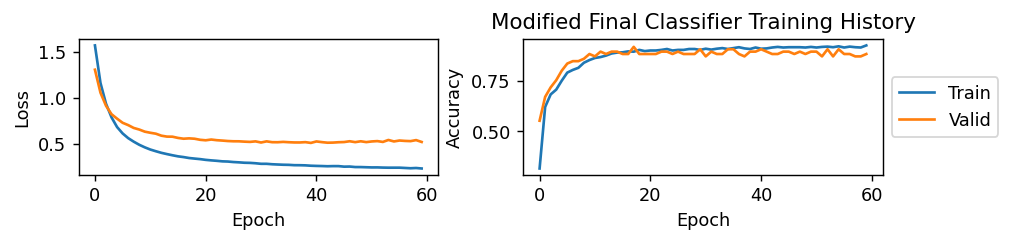

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 32, 'intermediate_classifier_width': 768, 'num_layers_fc': 2, 

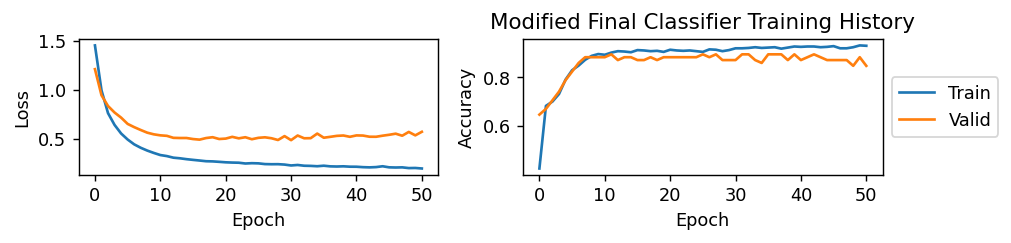

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 32, 'intermediate_classifier_width': 768, 'num_layers_fc': 3, 

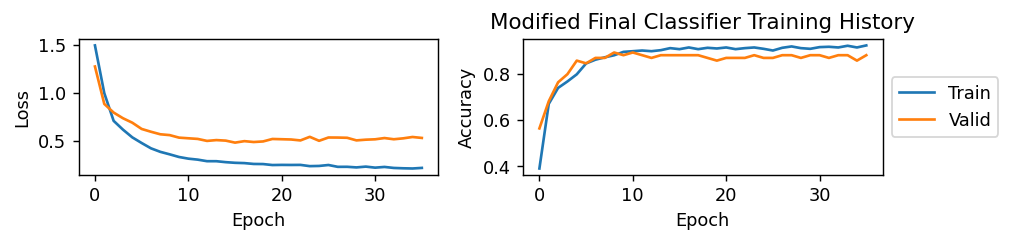

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 48, 'intermediate_classifier_width': 768, 'num_layers_fc': 1, 

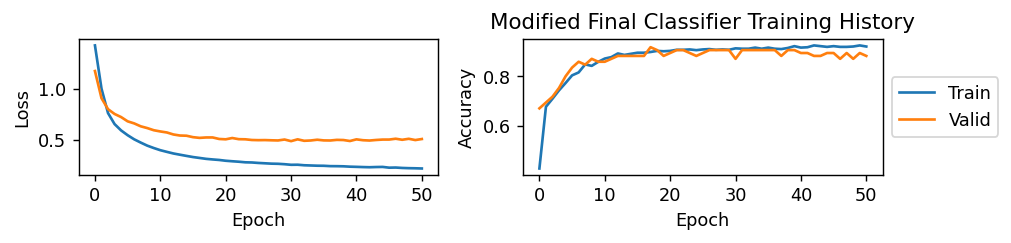

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 48, 'intermediate_classifier_width': 768, 'num_layers_fc': 2, 

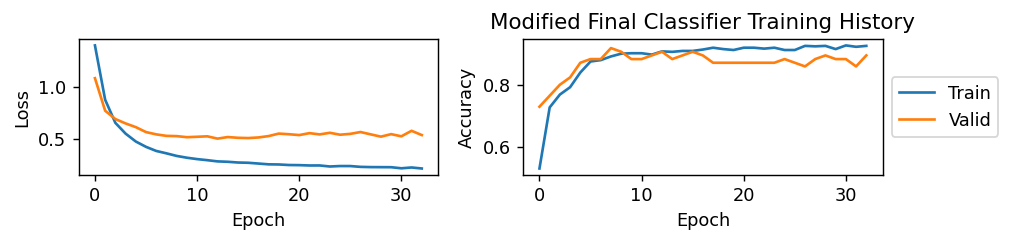

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 48, 'intermediate_classifier_width': 768, 'num_layers_fc': 3, 

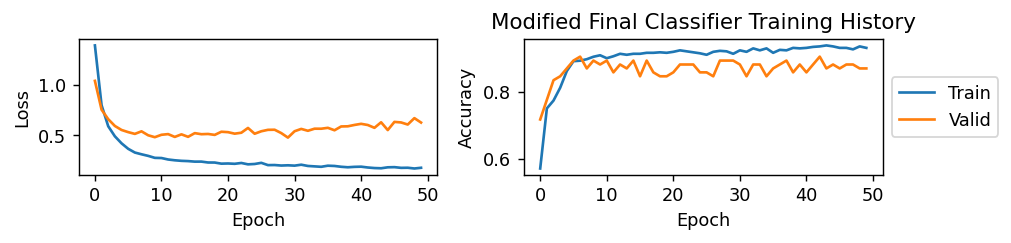

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 64, 'intermediate_classifier_width': 768, 'num_layers_fc': 1, 

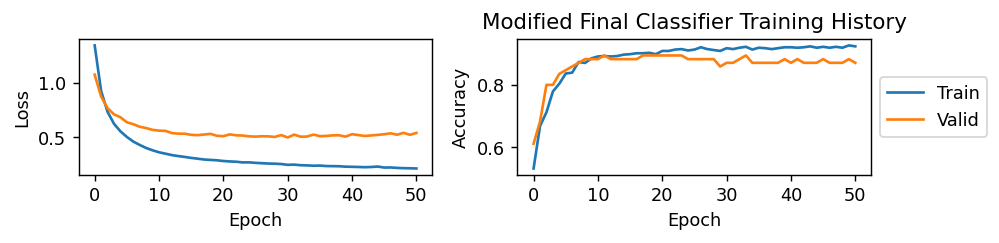

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 64, 'intermediate_classifier_width': 768, 'num_layers_fc': 2, 

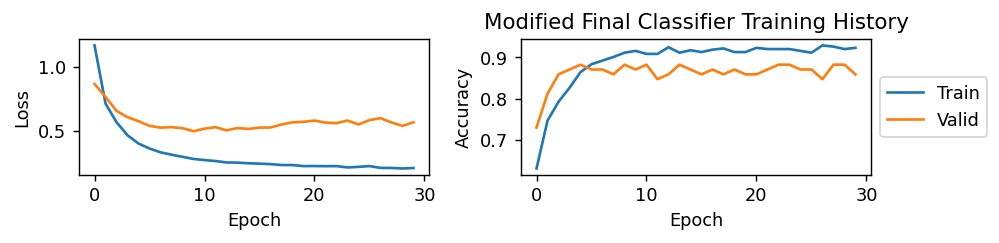

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 64, 'intermediate_classifier_width': 768, 'num_layers_fc': 3, 

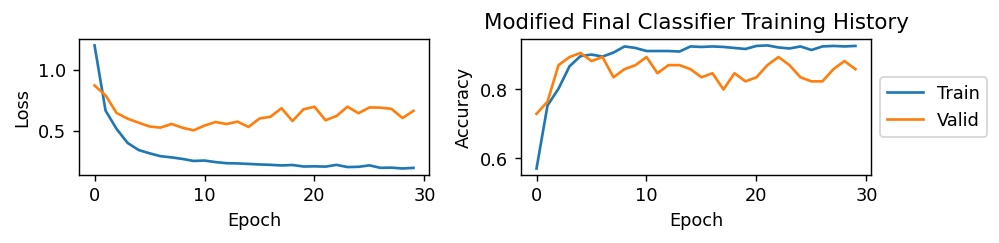

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 80, 'intermediate_classifier_width': 768, 'num_layers_fc': 1, 

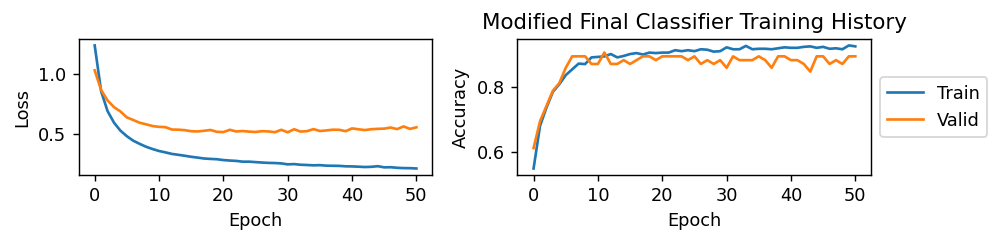

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 80, 'intermediate_classifier_width': 768, 'num_layers_fc': 2, 

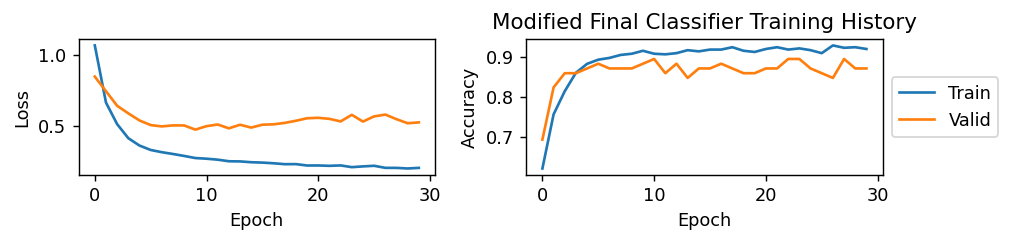

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 80, 'intermediate_classifier_width': 768, 'num_layers_fc': 3, 

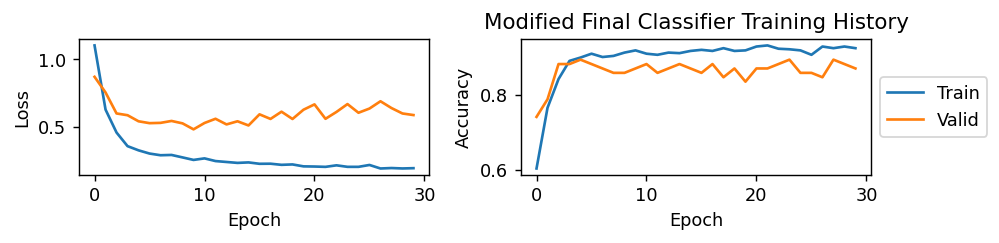

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 96, 'intermediate_classifier_width': 768, 'num_layers_fc': 1, 

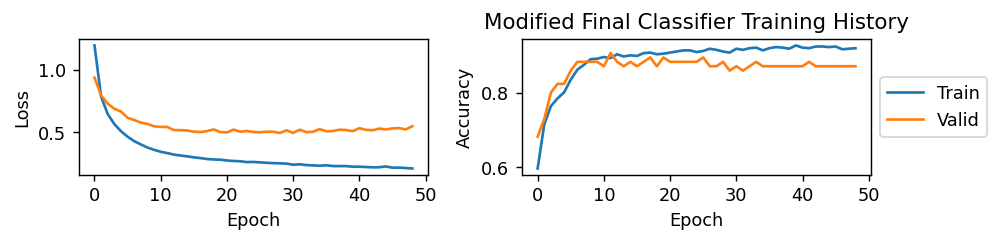

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 96, 'intermediate_classifier_width': 768, 'num_layers_fc': 2, 

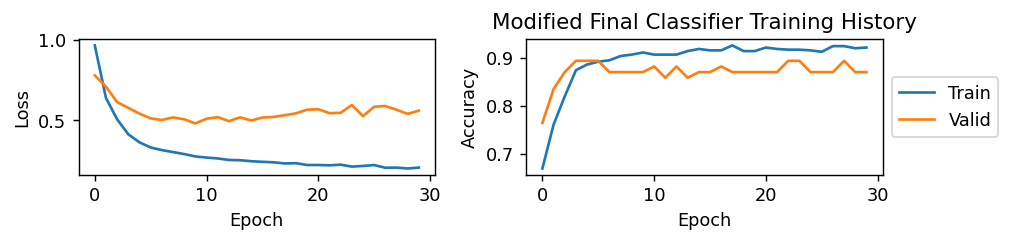

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 96, 'intermediate_classifier_width': 768, 'num_layers_fc': 3, 

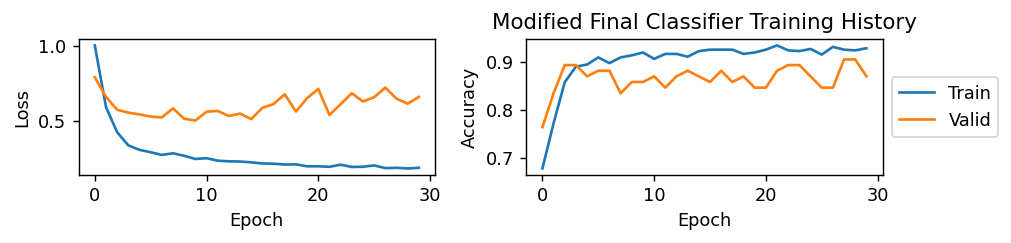

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 96, 'intermediate_classifier_width': 768, 'num_layers_fc': 3, 

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 80, 'intermediate_classifier_width': 768, 'num_layers_fc': 2, 'rho': 0.5}


In [23]:
fc_removed_best_hyperparameters, fc_removed_tuning_df = tune_model(
    **data_dfs, 
    input_cols=col_info["input_cols"], intermediate_col_dict=col_info["intermediate_col_dict"], 
    output_cols=col_info["output_onehot_cols"], # Changed output to onehot 
    le_label=col_info["le_label"], re_label=col_info["re_label"],
    Model_Class=BilateralModelLogicRemoved,
    hyperparameter_list_dict=dict(
        final_classifier_width=[32, 48, 64, 80, 96], 
        num_layers_fc=[1, 2, 3], 
        ae_width=[fc_best_hyperparameters["ae_width"]], 
        intermediate_classifier_width=[fc_best_hyperparameters["intermediate_classifier_width"]], 
        rho=[fc_best_hyperparameters["rho"]], beta=[fc_best_hyperparameters["beta"]]
    ), 
    train_function=train_modified_fc, 
    base_bilateral_model = fc_bilateral_model, transfer_function=transfer_ae_n_ic,
    batch_size=batch_size, 
    max_epochs=max_epochs, 
    patience=20, verbose=0, seed=seed_no,
)
print(fc_removed_best_hyperparameters)
display_tuning_df(fc_removed_tuning_df)

In [24]:
# Save Hyperparameters
save_hyperparameters(
    best_hyperparameters=fc_removed_best_hyperparameters, tuning_df=fc_removed_tuning_df, 
    name="fc_removed_softmax", fp_checkpoint_folder=fp_checkpoint_folder, override=True
)

Hyperparameters Saved!


In [25]:
# Load Hyperparameters
fc_removed_best_hyperparameters, fc_removed_tuning_df  = load_hyperparameters(
    name="fc_removed_softmax", fp_checkpoint_folder=fp_checkpoint_folder)
print(fc_removed_best_hyperparameters)
display_tuning_df(fc_removed_tuning_df)

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 80, 'intermediate_classifier_width': 768, 'num_layers_fc': 2, 'rho': 0.5}


#### Training

Epoch 1/10000
43/43 [==============================] - 4s 44ms/step - loss: 1.0663 - categorical_crossentropy: 1.0662 - accuracy: 0.6224 - val_loss: 0.8477 - val_categorical_crossentropy: 0.8476 - val_accuracy: 0.6941
Epoch 2/10000
43/43 [==============================] - 1s 20ms/step - loss: 0.6657 - categorical_crossentropy: 0.6656 - accuracy: 0.7566 - val_loss: 0.7453 - val_categorical_crossentropy: 0.7452 - val_accuracy: 0.8235
Epoch 3/10000
43/43 [==============================] - 1s 18ms/step - loss: 0.5145 - categorical_crossentropy: 0.5144 - accuracy: 0.8142 - val_loss: 0.6432 - val_categorical_crossentropy: 0.6431 - val_accuracy: 0.8588
Epoch 4/10000
43/43 [==============================] - 1s 18ms/step - loss: 0.4161 - categorical_crossentropy: 0.4160 - accuracy: 0.8599 - val_loss: 0.5902 - val_categorical_crossentropy: 0.5900 - val_accuracy: 0.8588
Epoch 5/10000
43/43 [==============================] - 1s 16ms/step - loss: 0.3645 - categorical_crossentropy: 0.3644 - accuracy

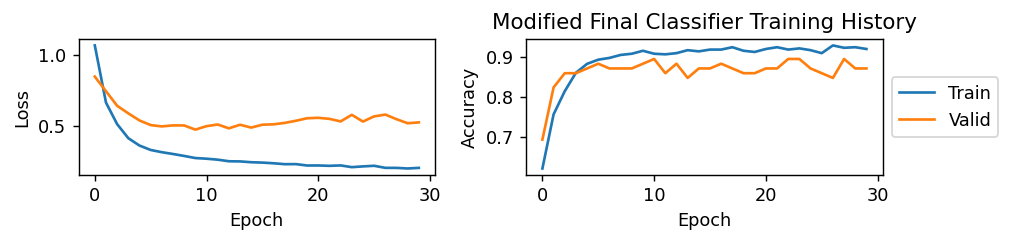

Train  Valid   Test
Accuracy Total_Time_1.0        0.000  0.000    NaN
Accuracy Total_Time_13.0       0.577  0.636  0.583
Accuracy Total_Time_26.0       0.956  0.964  0.963
Accuracy Total_Time_4.33       0.936  0.600  0.875
Accuracy Total_Time_52.0       0.991  0.974  0.921
Final Classifier Accuracy      0.909  0.882  0.882
Final Classifier Crossentropy  0.262  0.476  0.325
Total_Time_1.0 Proportion      0.004  0.024  0.000
Total_Time_13.0 Proportion     0.164  0.129  0.141
Total_Time_26.0 Proportion     0.268  0.329  0.318
Total_Time_4.33 Proportion     0.069  0.059  0.094
Total_Time_52.0 Proportion     0.494  0.459  0.447

Total_Time_1.0  Total_Time_4.33  Total_Time_13.0  Total_Time_26.0  \
0               0.0              0.0              1.0              0.0   
1               0.0              0.0              0.0              0.0   
2               0.0              0.0              0.0              0.0   
3               0.0              0.0              0.0              1.0   
4               0.0              0.0              0.0              0.0   
..              ...              ...              ...              ...   
843             0.0              0.0              0.0              1.0   
844             0.0              0.0              1.0              0.0   
845             0.0              0.0              0.0              0.0   
846             0.0              0.0              0.0              1.0   
847             0.0              0.0              1.0              0.0   

     Total_Time_52.0  Total_Time_1.0_pred  Total_Time_4.33_pred  \
0                0.0             0.001783              0.000724   
1                1.0             0.000980              0.002257   
2                1.0             0.003480              0.005001   
3                0.0             0.000224              0.003421   
4                1.0             0.001003              0.002309   
..               ...                  ...                   ...   
843              0.0             0.000274              0.003816   
844              0.0             0.001788              0.000752   
845              1.0             0.003975              0.004069   
846              0.0             0.000392              0.001731   
847              0.0             0.000726              0.005403   

     Total_Time_13.0_pred  Total_Time_26.0_pred  Total_Time_52.0_pred  split  
0                0.987510              0.002037              0.007947  train  
1                0.011798              0.000581              0.984385  train  
2                0.053089              0.003040              0.935390  train  
3                0.023781              0.972438              0.000136  train  
4                0.012366              0.000603              0.983718  train  
..                    ...                   ...                   ...    ...  
843              0.049805              0.945922              0.000184   test  
844              0.987025              0.001976              0.008459   test  
845              0.064327              0.009420              0.918210   test  
846              0.058722              0.937819              0.001335   test  
847              0.361157              0.632416              0.000298   test  

[848 rows x 11 columns]

In [26]:
set_seed(seed_no)
fc_removed_bilateral_model = BilateralModelLogicRemoved(
    input_cols=col_info["input_cols"], intermediate_col_dict=col_info["intermediate_col_dict"], 
    output_cols=col_info["output_onehot_cols"], # Changed output to onehot 
    le_label=col_info["le_label"], re_label=col_info["re_label"],
    **fc_removed_best_hyperparameters,
)
fc_removed_bilateral_model = transfer_ae_n_ic(
    base_bilateral_model=fc_bilateral_model, new_bilateral_model=fc_removed_bilateral_model)
assert not fc_removed_bilateral_model.encoder.trainable
assert not fc_removed_bilateral_model.intermediate_classifier.trainable
train_modified_fc(
    fc_removed_bilateral_model, **data_dfs,
    batch_size=batch_size, max_epochs=max_epochs,
    patience=20, verbose=1
)
fc_removed_perf_df, fc_removed_pred_df = evaluate_modified_fc(
    fc_removed_bilateral_model, **data_dfs
)
display(fc_removed_perf_df)
display(fc_removed_pred_df)

In [27]:
# Save model
fp_fc_removed_model_checkpoint = os.path.join(fp_checkpoint_folder, "models", "fc_removed_softmax")
fc_removed_bilateral_model(tf.random.normal((2,num_input_cols)), tf.random.normal((2,num_input_cols)))
fc_removed_bilateral_model.save(fp_fc_removed_model_checkpoint)

INFO:tensorflow:Assets written to: ./checkpoints\models\fc_removed_softmax\assets


INFO:tensorflow:Assets written to: ./checkpoints\models\fc_removed_softmax\assets


In [28]:
# Load model
fp_fc_removed_model_checkpoint = os.path.join(fp_checkpoint_folder, "models", "fc_removed_softmax")
fc_removed_bilateral_model = tf.keras.models.load_model(fp_fc_removed_model_checkpoint)
fc_removed_perf_df, fc_removed_pred_df = evaluate_modified_fc(
    fc_removed_bilateral_model, **data_dfs
)
display(fc_removed_perf_df)
display(fc_removed_pred_df)

Train  Valid   Test
Accuracy Total_Time_1.0        0.000  0.000    NaN
Accuracy Total_Time_13.0       0.577  0.636  0.583
Accuracy Total_Time_26.0       0.956  0.964  0.963
Accuracy Total_Time_4.33       0.936  0.600  0.875
Accuracy Total_Time_52.0       0.991  0.974  0.921
Final Classifier Accuracy      0.909  0.882  0.882
Final Classifier Crossentropy  0.262  0.476  0.325
Total_Time_1.0 Proportion      0.004  0.024  0.000
Total_Time_13.0 Proportion     0.164  0.129  0.141
Total_Time_26.0 Proportion     0.268  0.329  0.318
Total_Time_4.33 Proportion     0.069  0.059  0.094
Total_Time_52.0 Proportion     0.494  0.459  0.447

Total_Time_1.0  Total_Time_4.33  Total_Time_13.0  Total_Time_26.0  \
0               0.0              0.0              1.0              0.0   
1               0.0              0.0              0.0              0.0   
2               0.0              0.0              0.0              0.0   
3               0.0              0.0              0.0              1.0   
4               0.0              0.0              0.0              0.0   
..              ...              ...              ...              ...   
843             0.0              0.0              0.0              1.0   
844             0.0              0.0              1.0              0.0   
845             0.0              0.0              0.0              0.0   
846             0.0              0.0              0.0              1.0   
847             0.0              0.0              1.0              0.0   

     Total_Time_52.0  Total_Time_1.0_pred  Total_Time_4.33_pred  \
0                0.0             0.001783              0.000724   
1                1.0             0.000980              0.002257   
2                1.0             0.003480              0.005001   
3                0.0             0.000224              0.003421   
4                1.0             0.001003              0.002309   
..               ...                  ...                   ...   
843              0.0             0.000274              0.003816   
844              0.0             0.001788              0.000752   
845              1.0             0.003975              0.004069   
846              0.0             0.000392              0.001731   
847              0.0             0.000726              0.005403   

     Total_Time_13.0_pred  Total_Time_26.0_pred  Total_Time_52.0_pred  split  
0                0.987510              0.002037              0.007947  train  
1                0.011798              0.000581              0.984385  train  
2                0.053089              0.003040              0.935390  train  
3                0.023781              0.972438              0.000136  train  
4                0.012366              0.000603              0.983718  train  
..                    ...                   ...                   ...    ...  
843              0.049805              0.945922              0.000184   test  
844              0.987025              0.001976              0.008459   test  
845              0.064327              0.009420              0.918210   test  
846              0.058722              0.937819              0.001335   test  
847              0.361157              0.632416              0.000298   test  

[848 rows x 11 columns]

In [29]:
save_predictions(
    prediction_df=fc_removed_pred_df, name="fc_removed_softmax", fp_checkpoint_folder=fp_checkpoint_folder)

Predictions Saved!


## Removing Intermediate Classifier

### Architecture

In [30]:
class BilateralModelIntermediateClassifierRemoved(tf.keras.Model):
    def __init__(
        self,
        input_cols, intermediate_col_dict, output_cols, 
        le_label, re_label,
        ae_width, final_classifier_width, num_layers_fc,
        rho=0.1, beta=1., **kwargs, 
    ):
        super().__init__(**kwargs)
        from tensorflow import Variable
        from tensorflow.keras import Sequential, Input
        from tensorflow.keras.layers import Dense, Multiply
        
        self.input_cols = Variable(input_cols, trainable=False) # For each eye
        self.output_cols = Variable(output_cols, trainable=False) # For each eye

        self.le_label = Variable(le_label, trainable=False) 
        self.re_label = Variable(re_label, trainable=False) 

        self.num_input_cols = Variable(len(input_cols), trainable=False)
        self.num_output_cols = Variable(len(output_cols), trainable=False)

        self.ae_width = Variable(ae_width, trainable=False)
        self.final_classifier_width = Variable(final_classifier_width, trainable=False)
        self.num_layers_fc = Variable(num_layers_fc, trainable=False)

        self.rho = Variable(rho, trainable=False)
        self.beta = Variable(beta, trainable=False)

        num_input_cols = self.num_input_cols.numpy()
        num_output_cols = self.num_output_cols.numpy()
        
        # Autoencoder (Learns structure of data in an unsupervised manner)
        self.encoder = Sequential([
            Input(shape=(num_input_cols,)),
            Dense(ae_width, activation="relu"),
            Dense(ae_width, activation="relu"),
            Dense(ae_width, activation="relu", 
                  activity_regularizer=SparseRegularizer(rho = rho, beta = beta)), # Induce sparsity on this layer
        ], name="encoder")
        self.decoder = Sequential([
            Input(shape=(ae_width,)),
            Dense(ae_width, activation="relu"),
            Dense(ae_width, activation="relu"),
            Dense(num_input_cols)
        ], name="decoder")

        # Final Classifier Layer (E.g. Maps from diagnosis for each eye to TCU for this eye)
        self.final_classifier = Sequential(name="final_classifier")
        self.final_classifier.add(Input(shape=((ae_width,))))
        for _ in range(num_layers_fc):
            self.final_classifier.add(Dense(final_classifier_width, activation="relu"))
        self.final_classifier.add(Dense(num_output_cols, activation="sigmoid"))
        # Citation: https://ieeexplore.ieee.org.remotexs.ntu.edu.sg/stamp/stamp.jsp?tp=&arnumber=4633963
        # Output class should be processed like this:
        # - Most severe: [0, 0, 0], Least severe: [1, 1, 1]

        # E.g. Get diagnosis of both eyes:
        # [0, 0, 0] * [1, 1, 1] = [0, 0, 0] (the TCU of the most severe eye)
        self.multiply = Multiply(name="and")

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32)])
    def predict_ae_each(self, x):
        # Encode
        output = self.encoder(x)
        # Decode
        output = self.decoder(output)
        return output

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32)])
    def predict_final_classifier_each(self, x):
        # Encode
        output = self.encoder(x)
        # Classify final output
        output = self.final_classifier(output)
        return output

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32),
        tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32)]
    )
    def predict_final_classifier_both(self, x1, x2):
        # Assume x1 and x2 are aligned
        # For x1
        # - Encode
        output1 = self.encoder(x1)
        # - Classify final output
        output1 = self.final_classifier(output1)

        # For x2
        # - Encode
        output2 = self.encoder(x2)
        # - Classify final output
        output2 = self.final_classifier(output2)

        # Get final class
        output = self.multiply([output1, output2])
        return output

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32),
        tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32)]
    )
    def predict_everything(self, x1, x2):
        # Assume x1 and x2 are aligned
        # For x1
        # - Encode
        encoder1 = self.encoder(x1)
        # - Decode
        decoder1 = self.decoder(encoder1)
        # - Classify final output
        fc1 = self.final_classifier(encoder1)

        # For x2
        # - Encode
        encoder2 = self.encoder(x2)
        # - Decode
        decoder2 = self.decoder(encoder2)
        # - Classify final output
        fc2 = self.final_classifier(encoder2)

        # Get final class
        output = self.multiply([fc1, fc2])

        predict_dict = dict(
            encoder1=encoder1, encoder2=encoder2,
            decoder1=decoder1, decoder2=decoder2,
            fc1=fc1, fc2=fc2,
            output=output
        )
        return predict_dict
    
    def call(self, x1, x2):
        return self.predict_final_classifier_both(x1, x2)

def get_ic_removed_model(model):
    input1 = tf.keras.Input(shape=(num_input_cols,))
    input2 = tf.keras.Input(shape=(num_input_cols,))
    output1 = model.encoder(input1)
    output1 = model.final_classifier(output1)
    output2 = model.encoder(input2)
    output2 = model.final_classifier(output2)
    output = model.multiply([output1, output2])
    return tf.keras.Model(inputs=[input1, input2], outputs=output, name="final_classifier")
    
def train_removed_ic(
    bilateral_ic_removed_model, train_df, valid_df, test_df, 
    batch_size, max_epochs, patience=20, verbose=1, seed=seed_no
):
    return train_final_classifier(
        bilateral_ic_removed_model, train_df, valid_df, test_df, 
        batch_size, max_epochs, patience=patience, verbose=verbose, seed=seed_no,
        get_fc_function=get_ic_removed_model, title="Intermediate Classifier Removed Training History")

### Load Original Model Configurations

In [31]:
# Load Hyperparameters
fc_best_hyperparameters, fc_tuning_df  = load_hyperparameters(
    name="fc_softmax", fp_checkpoint_folder=fp_checkpoint_folder)
print(fc_best_hyperparameters)
display_tuning_df(fc_tuning_df)

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 32, 'intermediate_classifier_width': 768, 'rho': 0.5}


In [32]:
fp_fc_model_checkpoint = os.path.join(fp_checkpoint_folder, "models", "fc_softmax")
fc_bilateral_model = tf.keras.models.load_model(fp_fc_model_checkpoint)

### Modified Final Classifier

#### Tuning

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 32, 'num_layers_fc': 1, 'rho': 0.5}:   0%| | 0/15 [00:00<?, ?i

Restoring model weights from the end of the best epoch: 66.
Epoch 86: early stopping


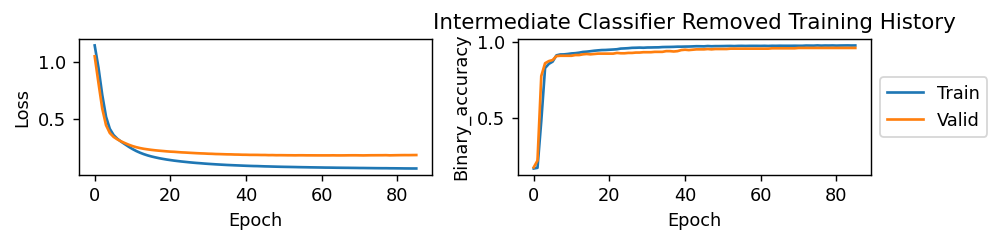

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 32, 'num_layers_fc': 2, 'rho': 0.5}:   7%| | 1/15 [00:40<09:29

Restoring model weights from the end of the best epoch: 33.
Epoch 53: early stopping


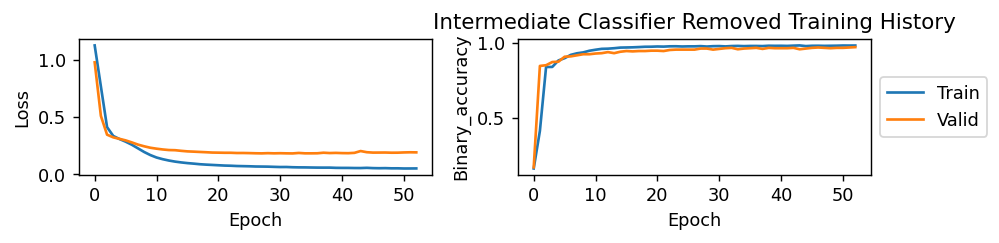

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 32, 'num_layers_fc': 3, 'rho': 0.5}:  13%|▏| 2/15 [01:08<07:11

Restoring model weights from the end of the best epoch: 25.
Epoch 45: early stopping


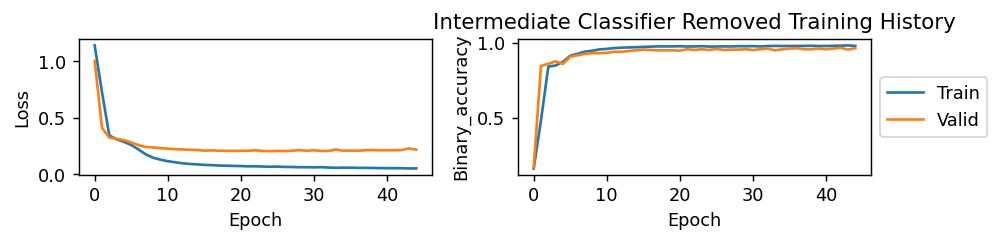

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 48, 'num_layers_fc': 1, 'rho': 0.5}:  20%|▏| 3/15 [01:32<05:47

Restoring model weights from the end of the best epoch: 49.
Epoch 69: early stopping


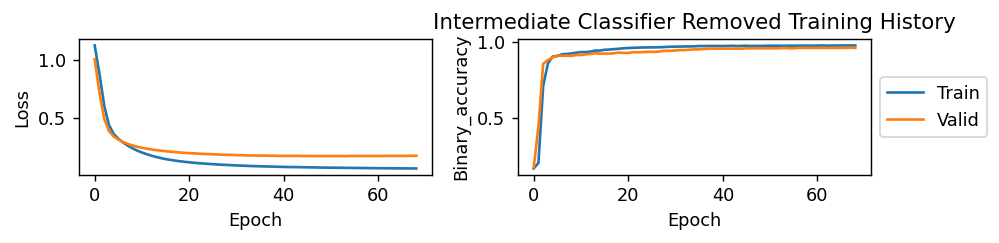

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 48, 'num_layers_fc': 2, 'rho': 0.5}:  27%|▎| 4/15 [02:04<05:29

Restoring model weights from the end of the best epoch: 27.
Epoch 47: early stopping


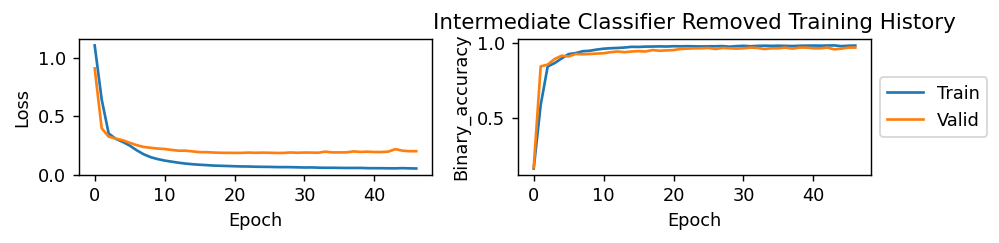

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 48, 'num_layers_fc': 3, 'rho': 0.5}:  33%|▎| 5/15 [02:28<04:40

Restoring model weights from the end of the best epoch: 16.
Epoch 36: early stopping


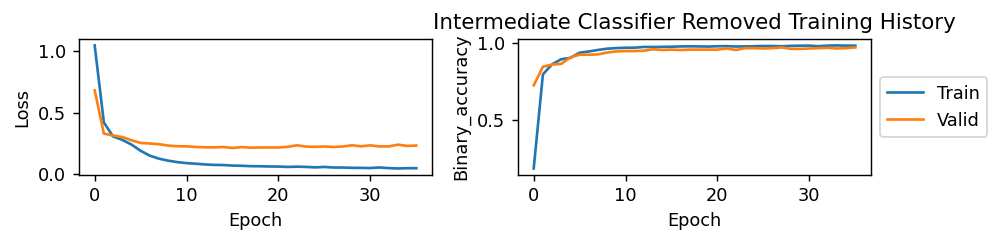

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 64, 'num_layers_fc': 1, 'rho': 0.5}:  40%|▍| 6/15 [02:48<03:48

Restoring model weights from the end of the best epoch: 47.
Epoch 67: early stopping


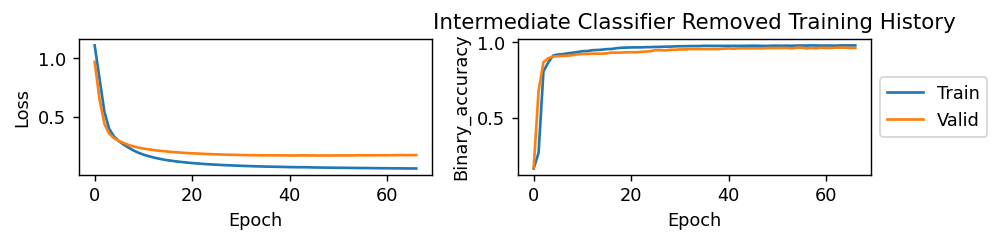

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 64, 'num_layers_fc': 2, 'rho': 0.5}:  47%|▍| 7/15 [03:20<03:38

Restoring model weights from the end of the best epoch: 19.
Epoch 39: early stopping


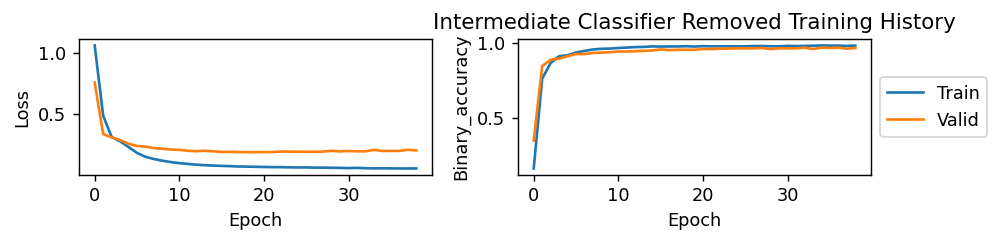

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 64, 'num_layers_fc': 3, 'rho': 0.5}:  53%|▌| 8/15 [03:41<02:56

Restoring model weights from the end of the best epoch: 13.
Epoch 33: early stopping


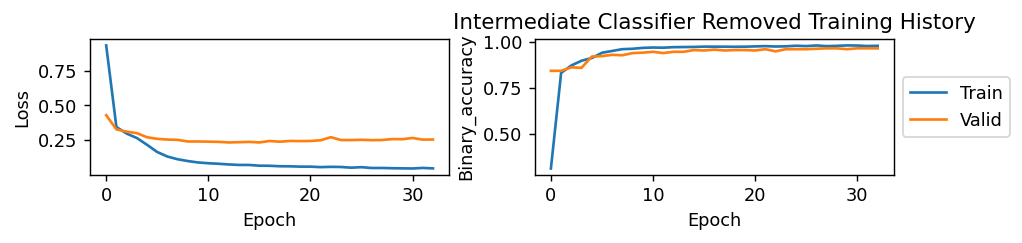

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 80, 'num_layers_fc': 1, 'rho': 0.5}:  60%|▌| 9/15 [03:59<02:19

Restoring model weights from the end of the best epoch: 42.
Epoch 62: early stopping


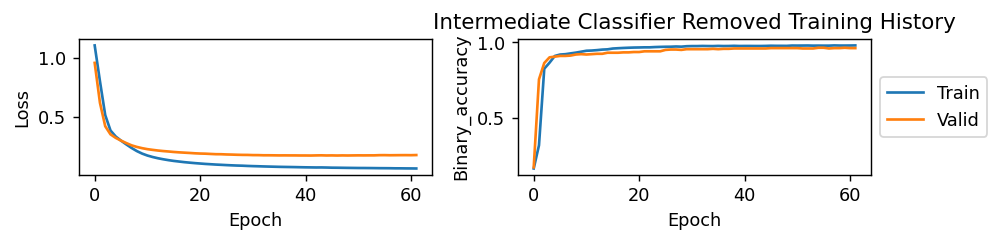

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 80, 'num_layers_fc': 2, 'rho': 0.5}:  67%|▋| 10/15 [04:29<02:0

Restoring model weights from the end of the best epoch: 19.
Epoch 39: early stopping


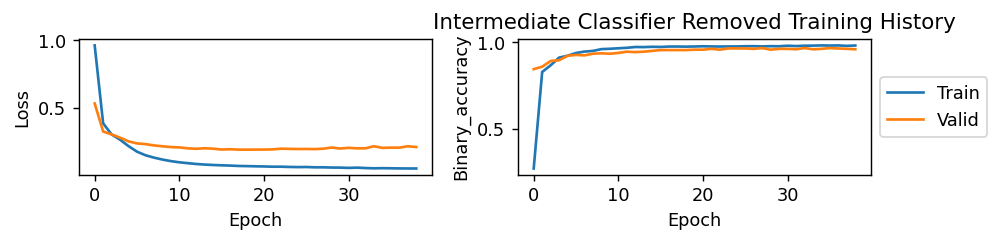

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 80, 'num_layers_fc': 3, 'rho': 0.5}:  73%|▋| 11/15 [04:50<01:3

Restoring model weights from the end of the best epoch: 16.
Epoch 36: early stopping


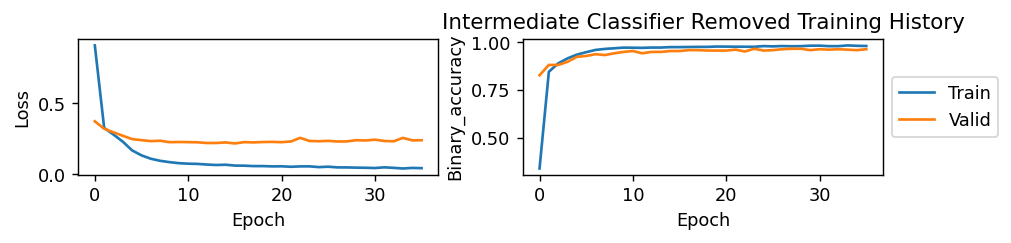

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 96, 'num_layers_fc': 1, 'rho': 0.5}:  80%|▊| 12/15 [05:10<01:0

Restoring model weights from the end of the best epoch: 36.
Epoch 56: early stopping


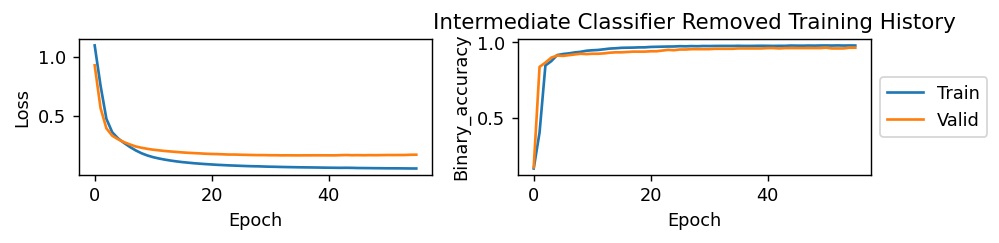

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 96, 'num_layers_fc': 2, 'rho': 0.5}:  87%|▊| 13/15 [05:30<00:4

Restoring model weights from the end of the best epoch: 16.
Epoch 36: early stopping


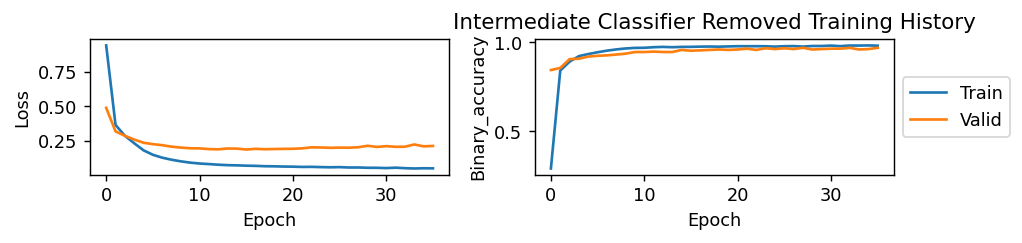

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 96, 'num_layers_fc': 3, 'rho': 0.5}:  93%|▉| 14/15 [05:44<00:1

Restoring model weights from the end of the best epoch: 16.
Epoch 36: early stopping


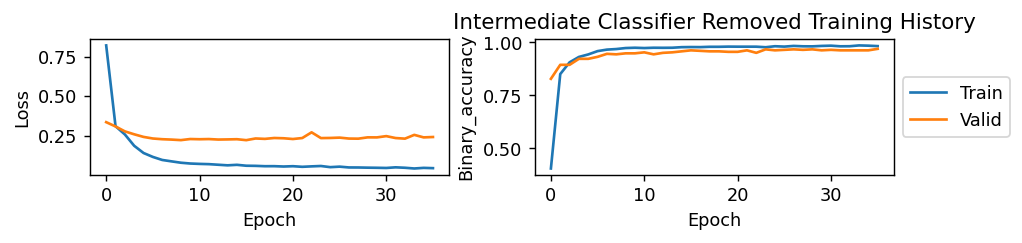

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 96, 'num_layers_fc': 3, 'rho': 0.5}: 100%|█| 15/15 [05:57<00:0

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 48, 'num_layers_fc': 1, 'rho': 0.5}


In [33]:
ic_removed_best_hyperparameters, ic_removed_tuning_df = tune_model(
    **data_dfs, 
    input_cols=col_info["input_cols"], intermediate_col_dict=col_info["intermediate_col_dict"], 
    output_cols=col_info["output_cols"], 
    le_label=col_info["le_label"], re_label=col_info["re_label"],
    Model_Class=BilateralModelIntermediateClassifierRemoved,
    hyperparameter_list_dict=dict(
        final_classifier_width=[32, 48, 64, 80, 96], 
        num_layers_fc=[1, 2, 3], 
        ae_width=[fc_best_hyperparameters["ae_width"]], 
        rho=[fc_best_hyperparameters["rho"]], beta=[fc_best_hyperparameters["beta"]]
    ), 
    train_function=train_removed_ic, 
    base_bilateral_model = fc_bilateral_model, transfer_function=transfer_ae,
    batch_size=batch_size, max_epochs=max_epochs,  
    patience=20, verbose=0, seed=seed_no,
)
print(ic_removed_best_hyperparameters)
display_tuning_df(ic_removed_tuning_df)

In [34]:
# Save Hyperparameters
save_hyperparameters(
    best_hyperparameters=ic_removed_best_hyperparameters, tuning_df=ic_removed_tuning_df, 
    name="ic_removed_softmax", fp_checkpoint_folder=fp_checkpoint_folder, override=True
)

Hyperparameters Saved!


In [35]:
# Load Hyperparameters
ic_removed_best_hyperparameters, ic_removed_tuning_df  = load_hyperparameters(
    name="ic_removed_softmax", fp_checkpoint_folder=fp_checkpoint_folder)
print(ic_removed_best_hyperparameters)
display_tuning_df(ic_removed_tuning_df)

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 48, 'num_layers_fc': 1, 'rho': 0.5}


#### Training

Restoring model weights from the end of the best epoch: 49.
Epoch 69: early stopping


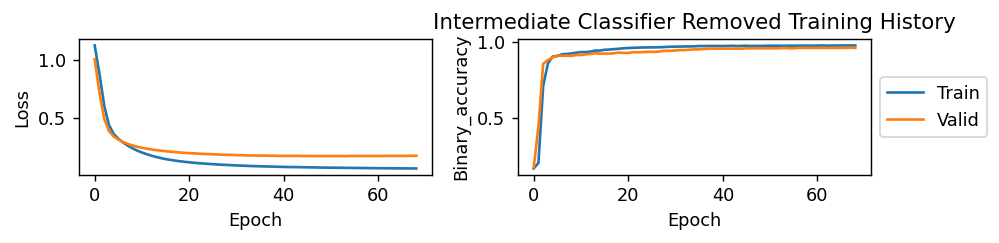

3/3 [==============================] - 0s 2ms/step


Train  Valid   Test
Accuracy Total_Time >= 1.0     0.000  0.000    NaN
Accuracy Total_Time >= 13.0    0.622  0.727  0.667
Accuracy Total_Time >= 26.0    0.907  1.000  0.963
Accuracy Total_Time >= 4.33    0.979  0.800  0.875
Accuracy Total_Time >= 52.0    0.991  0.949  1.000
Final Classifier Accuracy      0.903  0.906  0.929
Final Classifier Bin Accuracy  0.976  0.960  0.981
Final Classifier Crossentropy  0.069  0.168  0.071
Total_Time >= 1.0 Proportion   0.004  0.024  0.000
Total_Time >= 13.0 Proportion  0.164  0.129  0.141
Total_Time >= 26.0 Proportion  0.268  0.329  0.318
Total_Time >= 4.33 Proportion  0.069  0.059  0.094
Total_Time >= 52.0 Proportion  0.494  0.459  0.447

Total_Time >= 1.0  Total_Time >= 4.33  Total_Time >= 13.0  \
0                  1.0                 1.0                 1.0   
1                  1.0                 1.0                 1.0   
2                  1.0                 1.0                 1.0   
3                  1.0                 1.0                 1.0   
4                  1.0                 1.0                 1.0   
..                 ...                 ...                 ...   
843                1.0                 1.0                 1.0   
844                1.0                 1.0                 1.0   
845                1.0                 1.0                 1.0   
846                1.0                 1.0                 1.0   
847                1.0                 1.0                 1.0   

     Total_Time >= 26.0  Total_Time >= 52.0  Total_Time >= 1.0_pred  \
0                   0.0                 0.0                0.999966   
1                   1.0                 1.0                0.998964   
2                   1.0                 1.0                0.999342   
3                   1.0                 0.0                0.999968   
4                   1.0                 1.0                0.999043   
..                  ...                 ...                     ...   
843                 1.0                 0.0                0.999863   
844                 0.0                 0.0                0.999908   
845                 1.0                 1.0                0.999238   
846                 1.0                 0.0                0.999384   
847                 0.0                 0.0                0.999835   

     Total_Time >= 4.33_pred  Total_Time >= 13.0_pred  \
0                   0.999531                 0.996638   
1                   0.999158                 0.999546   
2                   0.999229                 0.999425   
3                   0.999695                 0.988167   
4                   0.999283                 0.999660   
..                       ...                      ...   
843                 0.999223                 0.976624   
844                 0.998216                 0.988098   
845                 0.999130                 0.999425   
846                 0.998609                 0.994683   
847                 0.998810                 0.988065   

     Total_Time >= 26.0_pred  Total_Time >= 52.0_pred  split  
0                   0.075375                 0.061311  train  
1                   0.980423                 0.987130  train  
2                   0.958869                 0.965361  train  
3                   0.853213                 0.000014  train  
4                   0.984099                 0.990034  train  
..                       ...                      ...    ...  
843                 0.793940                 0.000045   test  
844                 0.026289                 0.003815   test  
845                 0.969040                 0.977113   test  
846                 0.876246                 0.028044   test  
847                 0.446237                 0.000215   test  

[848 rows x 11 columns]

In [36]:
set_seed(seed_no)
ic_removed_bilateral_model = BilateralModelIntermediateClassifierRemoved(
    input_cols=col_info["input_cols"], intermediate_col_dict=col_info["intermediate_col_dict"], 
    output_cols=col_info["output_cols"], # Changed output to onehot 
    le_label=col_info["le_label"], re_label=col_info["re_label"],
    **ic_removed_best_hyperparameters,
)
ic_removed_bilateral_model = transfer_ae(
    base_bilateral_model=fc_bilateral_model, new_bilateral_model=ic_removed_bilateral_model)
assert not ic_removed_bilateral_model.encoder.trainable
train_removed_ic(
    ic_removed_bilateral_model, **data_dfs,
    batch_size=batch_size, max_epochs=max_epochs,
    patience=20, verbose=0
)
ic_removed_perf_df, ic_removed_pred_df = evaluate_fc(
    ic_removed_bilateral_model, **data_dfs, get_fc_function=get_ic_removed_model
)
display(ic_removed_perf_df)
display(ic_removed_pred_df)

In [37]:
# Save model
fp_ic_removed_model_checkpoint = os.path.join(fp_checkpoint_folder, "models", "ic_removed_softmax")
ic_removed_bilateral_model(tf.random.normal((2,num_input_cols)), tf.random.normal((2,num_input_cols)))
ic_removed_bilateral_model.save(fp_ic_removed_model_checkpoint)

INFO:tensorflow:Assets written to: ./checkpoints\models\ic_removed_softmax\assets


INFO:tensorflow:Assets written to: ./checkpoints\models\ic_removed_softmax\assets


In [38]:
# Load model
fp_ic_removed_model_checkpoint = os.path.join(fp_checkpoint_folder, "models", "ic_removed_softmax")
ic_removed_bilateral_model = tf.keras.models.load_model(fp_ic_removed_model_checkpoint)
ic_removed_perf_df, ic_removed_pred_df = evaluate_fc(
    ic_removed_bilateral_model, **data_dfs, get_fc_function=get_ic_removed_model
)
display(ic_removed_perf_df)
display(ic_removed_pred_df)

3/3 [==============================] - 0s 3ms/step


Train  Valid   Test
Accuracy Total_Time >= 1.0     0.000  0.000    NaN
Accuracy Total_Time >= 13.0    0.622  0.727  0.667
Accuracy Total_Time >= 26.0    0.907  1.000  0.963
Accuracy Total_Time >= 4.33    0.979  0.800  0.875
Accuracy Total_Time >= 52.0    0.991  0.949  1.000
Final Classifier Accuracy      0.903  0.906  0.929
Final Classifier Bin Accuracy  0.976  0.960  0.981
Final Classifier Crossentropy  0.069  0.168  0.071
Total_Time >= 1.0 Proportion   0.004  0.024  0.000
Total_Time >= 13.0 Proportion  0.164  0.129  0.141
Total_Time >= 26.0 Proportion  0.268  0.329  0.318
Total_Time >= 4.33 Proportion  0.069  0.059  0.094
Total_Time >= 52.0 Proportion  0.494  0.459  0.447

Total_Time >= 1.0  Total_Time >= 4.33  Total_Time >= 13.0  \
0                  1.0                 1.0                 1.0   
1                  1.0                 1.0                 1.0   
2                  1.0                 1.0                 1.0   
3                  1.0                 1.0                 1.0   
4                  1.0                 1.0                 1.0   
..                 ...                 ...                 ...   
843                1.0                 1.0                 1.0   
844                1.0                 1.0                 1.0   
845                1.0                 1.0                 1.0   
846                1.0                 1.0                 1.0   
847                1.0                 1.0                 1.0   

     Total_Time >= 26.0  Total_Time >= 52.0  Total_Time >= 1.0_pred  \
0                   0.0                 0.0                0.999966   
1                   1.0                 1.0                0.998964   
2                   1.0                 1.0                0.999342   
3                   1.0                 0.0                0.999968   
4                   1.0                 1.0                0.999043   
..                  ...                 ...                     ...   
843                 1.0                 0.0                0.999863   
844                 0.0                 0.0                0.999908   
845                 1.0                 1.0                0.999238   
846                 1.0                 0.0                0.999384   
847                 0.0                 0.0                0.999835   

     Total_Time >= 4.33_pred  Total_Time >= 13.0_pred  \
0                   0.999531                 0.996638   
1                   0.999158                 0.999546   
2                   0.999229                 0.999425   
3                   0.999695                 0.988167   
4                   0.999283                 0.999660   
..                       ...                      ...   
843                 0.999223                 0.976624   
844                 0.998216                 0.988098   
845                 0.999130                 0.999425   
846                 0.998609                 0.994683   
847                 0.998810                 0.988065   

     Total_Time >= 26.0_pred  Total_Time >= 52.0_pred  split  
0                   0.075375                 0.061311  train  
1                   0.980423                 0.987130  train  
2                   0.958869                 0.965361  train  
3                   0.853213                 0.000014  train  
4                   0.984099                 0.990034  train  
..                       ...                      ...    ...  
843                 0.793940                 0.000045   test  
844                 0.026289                 0.003815   test  
845                 0.969040                 0.977113   test  
846                 0.876246                 0.028044   test  
847                 0.446237                 0.000215   test  

[848 rows x 11 columns]

In [39]:
save_predictions(
    prediction_df=ic_removed_pred_df, name="ic_removed_softmax", fp_checkpoint_folder=fp_checkpoint_folder)

Predictions Saved!


## Removing Autoencoder

### Architecture

In [40]:
class BilateralModelAutoencoderRemoved(tf.keras.Model):
    def __init__(
        self,
        input_cols, intermediate_col_dict, output_cols, 
        le_label, re_label,
        intermediate_classifier_width, num_layers_ic,
        final_classifier_width, num_layers_fc,
        **kwargs, 
    ):
        super().__init__(**kwargs)
        from tensorflow import Variable
        from tensorflow.keras import Sequential, Input
        from tensorflow.keras.layers import Dense, Multiply
        
        self.input_cols = Variable(input_cols, trainable=False) # For each eye
        intermediate_cols = []
        intermediate_col_groups = []
        intermediate_col_sizes = []
        for key, col_list in intermediate_col_dict.items():
            for col in col_list:
                intermediate_cols.append(f"{key}_{col}")
            intermediate_col_groups.append(key)
            intermediate_col_sizes.append(len(col_list))
        intermediate_col_sizes=np.array(intermediate_col_sizes)
        # self.intermediate_col_dict = Variable(intermediate_col_dict, trainable=False) # For each eye
        self.intermediate_cols = Variable(intermediate_cols, trainable=False) # For each eye
        self.intermediate_col_groups = Variable(intermediate_col_groups, trainable=False)
        self.intermediate_col_sizes = Variable(intermediate_col_sizes, trainable=False)
        self.output_cols = Variable(output_cols, trainable=False) # For each eye

        self.le_label = Variable(le_label, trainable=False) 
        self.re_label = Variable(re_label, trainable=False) 

        self.num_input_cols = Variable(len(input_cols), trainable=False)
        self.num_intermediate_cols = Variable(len(intermediate_cols), trainable=False)
        self.num_output_cols = Variable(len(output_cols), trainable=False)

        self.intermediate_classifier_width = Variable(intermediate_classifier_width, trainable=False)
        self.num_layers_ic = Variable(num_layers_ic, trainable=False)
        self.final_classifier_width = Variable(final_classifier_width, trainable=False)
        self.num_layers_fc = Variable(num_layers_fc, trainable=False)

        num_input_cols = self.num_input_cols.numpy()
        num_intermediate_cols = self.num_intermediate_cols.numpy()
        num_output_cols = self.num_output_cols.numpy()
        
        # Intermediate Classifier Layer (E.g. Maps from encoded features to diagnosis for each eye)
        self.intermediate_classifier = GroupedSoftmaxDenseLayer(
            input_width=num_input_cols,
            intermediate_col_sizes=intermediate_col_sizes, 
            num_layers_per_intermediate_classifier=num_layers_ic, 
            intermediate_classifier_width=intermediate_classifier_width,
            name="intermediate_classifier"
        )
        
        # concatenate softmax outputs
        self.concatenate = tf.keras.layers.Concatenate()

        # Final Classifier Layer (E.g. Maps from diagnosis for each eye to TCU for this eye)
        self.final_classifier = Sequential(name="final_classifier")
        self.final_classifier.add(Input(shape=((num_intermediate_cols,))))
        for _ in range(num_layers_fc):
            self.final_classifier.add(Dense(final_classifier_width, activation="relu"))
        self.final_classifier.add(Dense(num_output_cols, activation="sigmoid"))
        # Citation: https://ieeexplore.ieee.org.remotexs.ntu.edu.sg/stamp/stamp.jsp?tp=&arnumber=4633963
        # Output class should be processed like this:
        # - Most severe: [0, 0, 0], Least severe: [1, 1, 1]

        # E.g. Get diagnosis of both eyes:
        # [0, 0, 0] * [1, 1, 1] = [0, 0, 0] (the TCU of the most severe eye)
        self.multiply = Multiply(name="and")

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32)])
    def predict_intermediate_classifier_each(self, x):
        # Classify intermediate output
        output = self.intermediate_classifier(x)
        return output

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32)])
    def predict_final_classifier_each(self, x):
        # Classify intermediate output
        output = self.intermediate_classifier(x)
        # Concatenate individual softmax classifiers
        output = self.concatenate(output)
        # Classify final output
        output = self.final_classifier(output)
        return output

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32),
        tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32)]
    )
    def predict_final_classifier_both(self, x1, x2):
        # Assume x1 and x2 are aligned
        # For x1       
        # - Classify intermediate output
        output1 = self.intermediate_classifier(x1)
        # Concatenate individual softmax classifiers
        output1 = self.concatenate(output1)
        # - Classify final output
        output1 = self.final_classifier(output1)

        # For x2
        # - Classify intermediate output
        output2 = self.intermediate_classifier(x2)
        # Concatenate individual softmax classifiers
        output2 = self.concatenate(output2)
        # - Classify final output
        output2 = self.final_classifier(output2)

        # Get final class
        output = self.multiply([output1, output2])
        return output

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32),
        tf.TensorSpec(shape=[None, num_input_cols], dtype=tf.float32)]
    )
    def predict_everything(self, x1, x2):
        # Assume x1 and x2 are aligned
        # - Classify intermediate output
        ic1 = self.intermediate_classifier(x1)
        # Concatenate individual softmax classifiers
        ic1 = self.concatenate(ic1)
        # - Classify final output
        fc1 = self.final_classifier(ic1)

        # For x2
        # - Classify intermediate output
        ic2 = self.intermediate_classifier(x2)
        # Concatenate individual softmax classifiers
        ic2 = self.concatenate(ic2)
        # - Classify final output
        fc2 = self.final_classifier(ic2)

        # Get final class
        output = self.multiply([fc1, fc2])

        predict_dict = dict(
            ic1=ic1, ic2=ic2,
            fc1=fc1, fc2=fc2,
            output=output
        )
        return predict_dict
    
    def call(self, x1, x2):
        return self.predict_final_classifier_both(x1, x2)
        
def get_ae_removed_ic_model(model):
    input = tf.keras.Input(shape=(num_input_cols,))
    output = model.intermediate_classifier(input)
    return tf.keras.Model(inputs=input, outputs=output, name="intermediate_classifier")

def get_ae_removed_fc_model(model):
    input1 = tf.keras.Input(shape=(num_input_cols,))
    input2 = tf.keras.Input(shape=(num_input_cols,))
    output1 = model.intermediate_classifier(input1)
    output1 = model.concatenate(output1)
    output1 = model.final_classifier(output1)
    output2 = model.intermediate_classifier(input2)
    output2 = model.concatenate(output2)
    output2 = model.final_classifier(output2)
    output = model.multiply([output1, output2])
    return tf.keras.Model(inputs=[input1, input2], outputs=output, name="final_classifier")

def train_ae_removed_ic(
    bilateral_model, train_df, valid_df, test_df, 
    batch_size, max_epochs, patience=20, verbose=1, seed=seed_no,
):
    return train_intermediate_classifier(
        bilateral_model, train_df, valid_df, test_df, 
        batch_size, max_epochs, patience=patience, verbose=verbose, seed=seed_no,
        get_ic_function=get_ae_removed_ic_model, title="Intermediate Classifier Training History \n (AE Removed)" 
    )

def train_ae_removed_fc(
    bilateral_model, train_df, valid_df, test_df, 
    batch_size, max_epochs, patience=20, verbose=1, seed=seed_no, 
):
    return train_final_classifier(
        bilateral_model, train_df, valid_df, test_df, 
        batch_size, max_epochs, patience=patience, verbose=verbose, seed=seed_no, 
        get_fc_function=get_ae_removed_fc_model, title="Final Classifier Training History \n (AE Removed)" 
    )

def transfer_ic(base_bilateral_model, new_bilateral_model):
    new_bilateral_model.intermediate_classifier = base_bilateral_model.intermediate_classifier
    return new_bilateral_model

### Train Intermediate Classifier

#### Tuning

{'final_classifier_width': 4, 'intermediate_classifier_width': 128, 'num_layers_fc': 3, 'num_layers_ic': 1}:   0%| | 0/

Epoch 1/10000
85/85 [==============================] - 3s 21ms/step - loss: 3.3068 - intermediate_classifier_loss: 0.8855 - intermediate_classifier_1_loss: 1.0060 - intermediate_classifier_2_loss: 1.0447 - intermediate_classifier_3_loss: 0.3707 - intermediate_classifier_categorical_crossentropy: 0.8855 - intermediate_classifier_accuracy: 0.8053 - intermediate_classifier_1_categorical_crossentropy: 1.0060 - intermediate_classifier_1_accuracy: 0.6091 - intermediate_classifier_2_categorical_crossentropy: 1.0447 - intermediate_classifier_2_accuracy: 0.7146 - intermediate_classifier_3_categorical_crossentropy: 0.3707 - intermediate_classifier_3_accuracy: 0.8628 - val_loss: 2.0402 - val_intermediate_classifier_loss: 0.5870 - val_intermediate_classifier_1_loss: 0.8088 - val_intermediate_classifier_2_loss: 0.5382 - val_intermediate_classifier_3_loss: 0.1063 - val_intermediate_classifier_categorical_crossentropy: 0.5870 - val_intermediate_classifier_accuracy: 0.8353 - val_intermediate_classifie

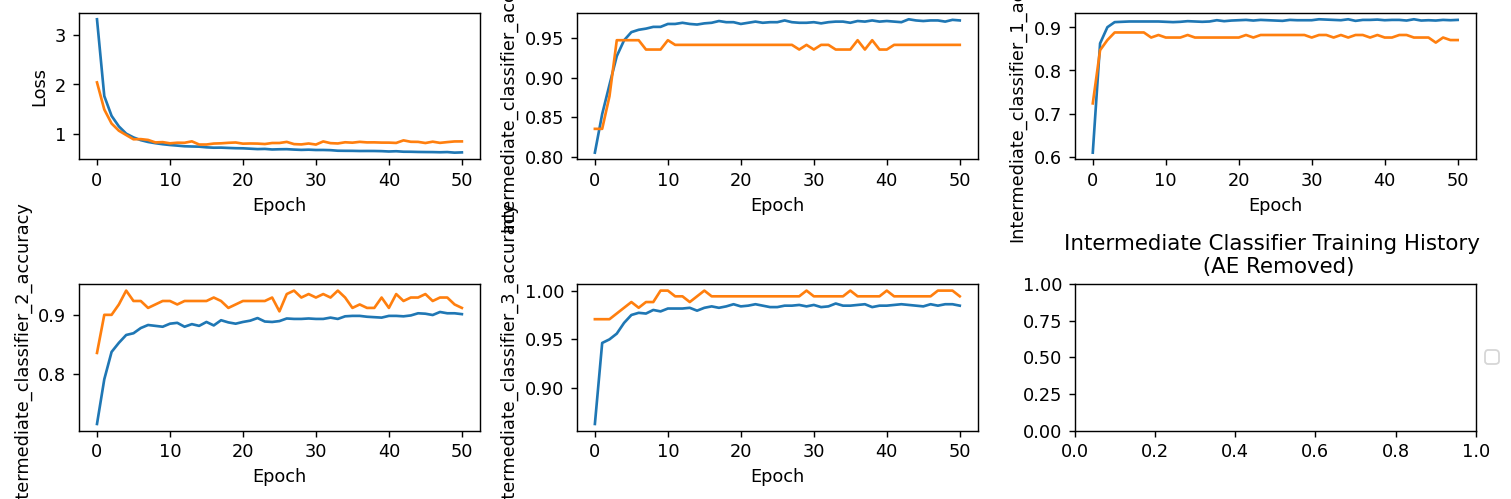

{'final_classifier_width': 4, 'intermediate_classifier_width': 128, 'num_layers_fc': 3, 'num_layers_ic': 2}:  11%| | 1/

Epoch 1/10000
85/85 [==============================] - 3s 24ms/step - loss: 2.5910 - intermediate_classifier_loss: 0.7120 - intermediate_classifier_1_loss: 0.7941 - intermediate_classifier_2_loss: 0.8430 - intermediate_classifier_3_loss: 0.2419 - intermediate_classifier_categorical_crossentropy: 0.7120 - intermediate_classifier_accuracy: 0.7817 - intermediate_classifier_1_categorical_crossentropy: 0.7941 - intermediate_classifier_1_accuracy: 0.7463 - intermediate_classifier_2_categorical_crossentropy: 0.8430 - intermediate_classifier_2_accuracy: 0.7279 - intermediate_classifier_3_categorical_crossentropy: 0.2419 - intermediate_classifier_3_accuracy: 0.9440 - val_loss: 1.4559 - val_intermediate_classifier_loss: 0.4137 - val_intermediate_classifier_1_loss: 0.5297 - val_intermediate_classifier_2_loss: 0.4121 - val_intermediate_classifier_3_loss: 0.1003 - val_intermediate_classifier_categorical_crossentropy: 0.4137 - val_intermediate_classifier_accuracy: 0.8647 - val_intermediate_classifie

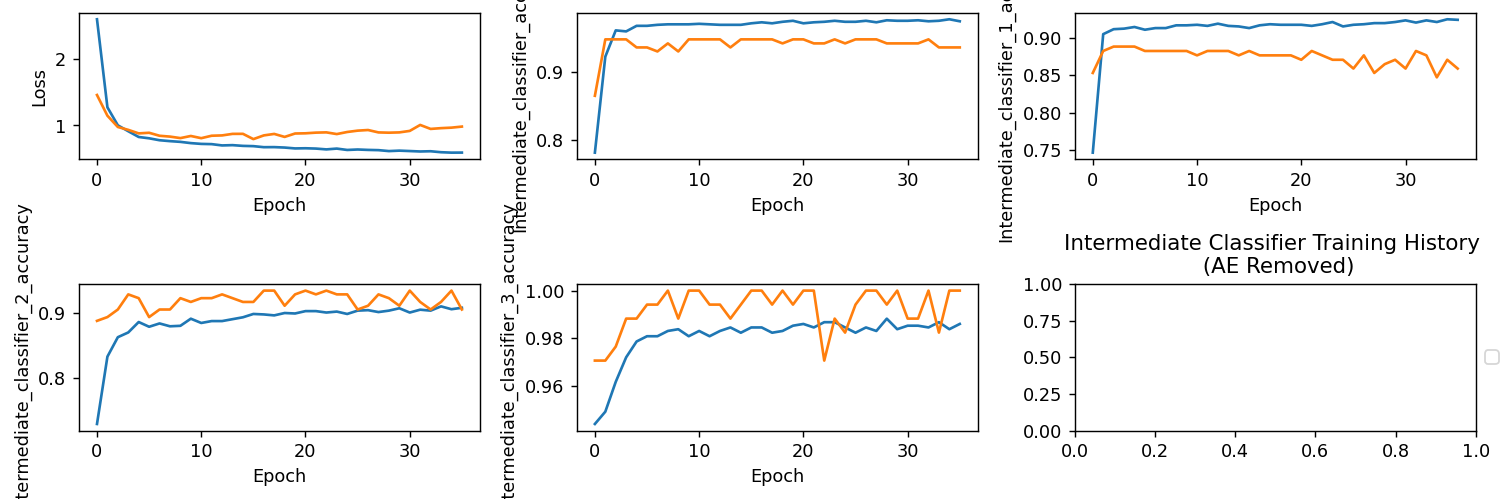

{'final_classifier_width': 4, 'intermediate_classifier_width': 128, 'num_layers_fc': 3, 'num_layers_ic': 3}:  22%|▏| 2/

Epoch 1/10000
85/85 [==============================] - 3s 23ms/step - loss: 2.2965 - intermediate_classifier_loss: 0.6412 - intermediate_classifier_1_loss: 0.6606 - intermediate_classifier_2_loss: 0.7516 - intermediate_classifier_3_loss: 0.2431 - intermediate_classifier_categorical_crossentropy: 0.6412 - intermediate_classifier_accuracy: 0.8215 - intermediate_classifier_1_categorical_crossentropy: 0.6606 - intermediate_classifier_1_accuracy: 0.7751 - intermediate_classifier_2_categorical_crossentropy: 0.7516 - intermediate_classifier_2_accuracy: 0.7839 - intermediate_classifier_3_categorical_crossentropy: 0.2431 - intermediate_classifier_3_accuracy: 0.9454 - val_loss: 1.2809 - val_intermediate_classifier_loss: 0.3722 - val_intermediate_classifier_1_loss: 0.4464 - val_intermediate_classifier_2_loss: 0.3750 - val_intermediate_classifier_3_loss: 0.0873 - val_intermediate_classifier_categorical_crossentropy: 0.3722 - val_intermediate_classifier_accuracy: 0.9118 - val_intermediate_classifie

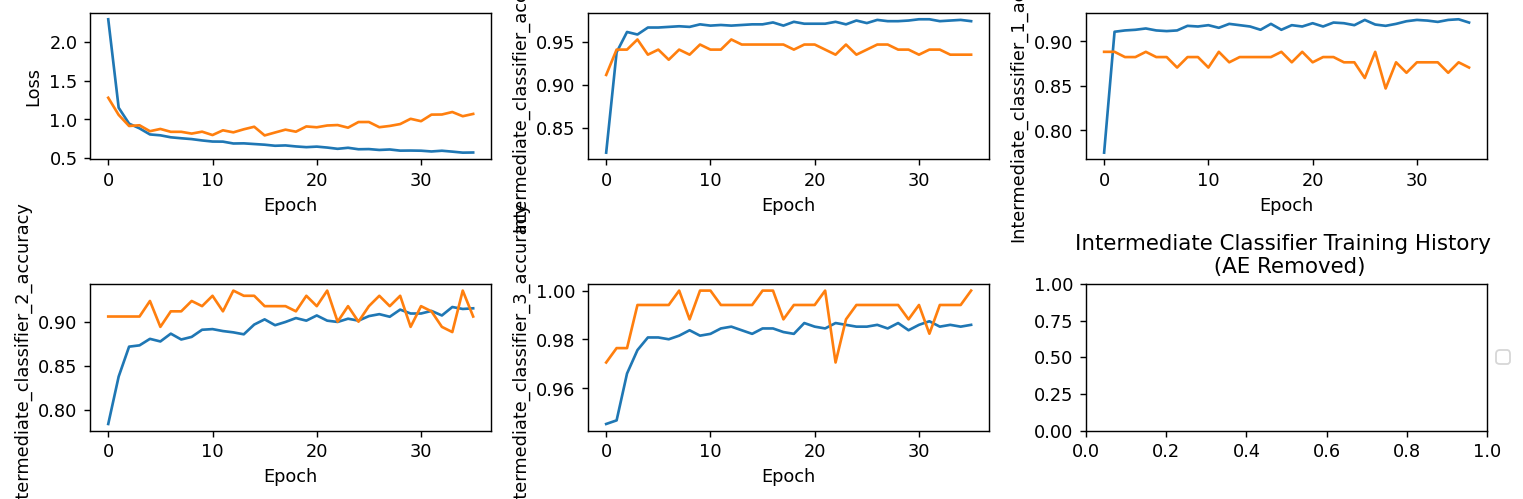

{'final_classifier_width': 4, 'intermediate_classifier_width': 256, 'num_layers_fc': 3, 'num_layers_ic': 1}:  33%|▎| 3/

Epoch 1/10000
85/85 [==============================] - 3s 21ms/step - loss: 2.9245 - intermediate_classifier_loss: 0.8127 - intermediate_classifier_1_loss: 0.8938 - intermediate_classifier_2_loss: 0.9600 - intermediate_classifier_3_loss: 0.2580 - intermediate_classifier_categorical_crossentropy: 0.8127 - intermediate_classifier_accuracy: 0.7957 - intermediate_classifier_1_categorical_crossentropy: 0.8938 - intermediate_classifier_1_accuracy: 0.6940 - intermediate_classifier_2_categorical_crossentropy: 0.9600 - intermediate_classifier_2_accuracy: 0.7131 - intermediate_classifier_3_categorical_crossentropy: 0.2580 - intermediate_classifier_3_accuracy: 0.9454 - val_loss: 1.7921 - val_intermediate_classifier_loss: 0.4992 - val_intermediate_classifier_1_loss: 0.7036 - val_intermediate_classifier_2_loss: 0.4886 - val_intermediate_classifier_3_loss: 0.1006 - val_intermediate_classifier_categorical_crossentropy: 0.4992 - val_intermediate_classifier_accuracy: 0.8353 - val_intermediate_classifie

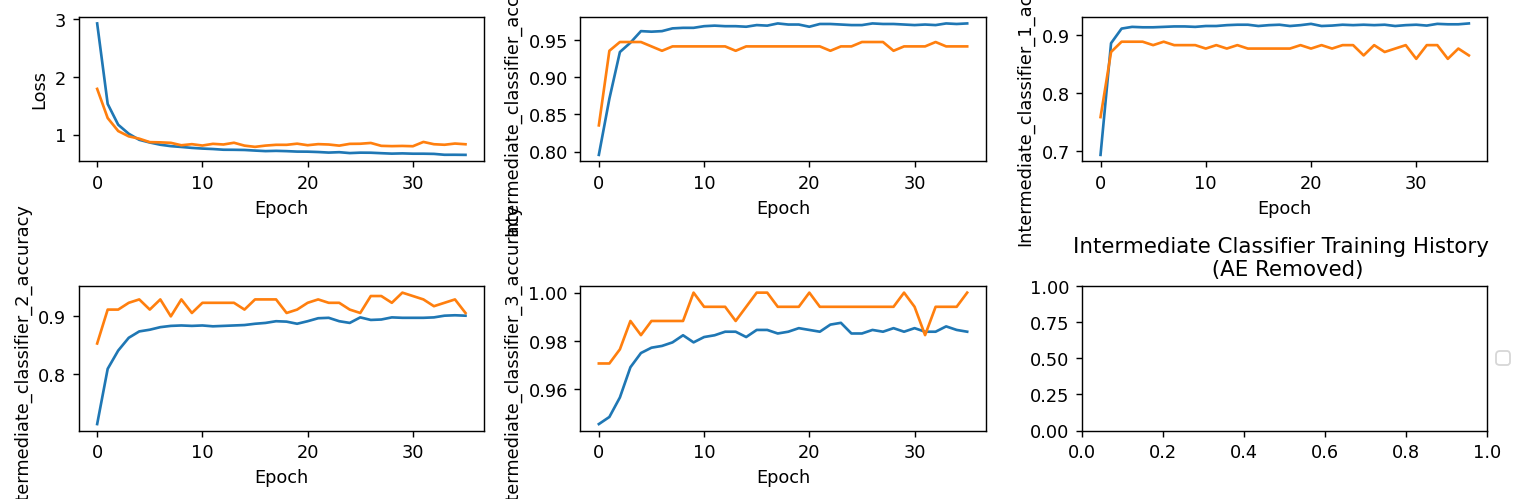

{'final_classifier_width': 4, 'intermediate_classifier_width': 256, 'num_layers_fc': 3, 'num_layers_ic': 2}:  44%|▍| 4/

Epoch 1/10000
85/85 [==============================] - 3s 19ms/step - loss: 2.0935 - intermediate_classifier_loss: 0.5335 - intermediate_classifier_1_loss: 0.6078 - intermediate_classifier_2_loss: 0.7216 - intermediate_classifier_3_loss: 0.2307 - intermediate_classifier_categorical_crossentropy: 0.5335 - intermediate_classifier_accuracy: 0.8392 - intermediate_classifier_1_categorical_crossentropy: 0.6078 - intermediate_classifier_1_accuracy: 0.8164 - intermediate_classifier_2_categorical_crossentropy: 0.7216 - intermediate_classifier_2_accuracy: 0.7869 - intermediate_classifier_3_categorical_crossentropy: 0.2307 - intermediate_classifier_3_accuracy: 0.9351 - val_loss: 1.1531 - val_intermediate_classifier_loss: 0.2778 - val_intermediate_classifier_1_loss: 0.4329 - val_intermediate_classifier_2_loss: 0.3611 - val_intermediate_classifier_3_loss: 0.0813 - val_intermediate_classifier_categorical_crossentropy: 0.2778 - val_intermediate_classifier_accuracy: 0.9412 - val_intermediate_classifie

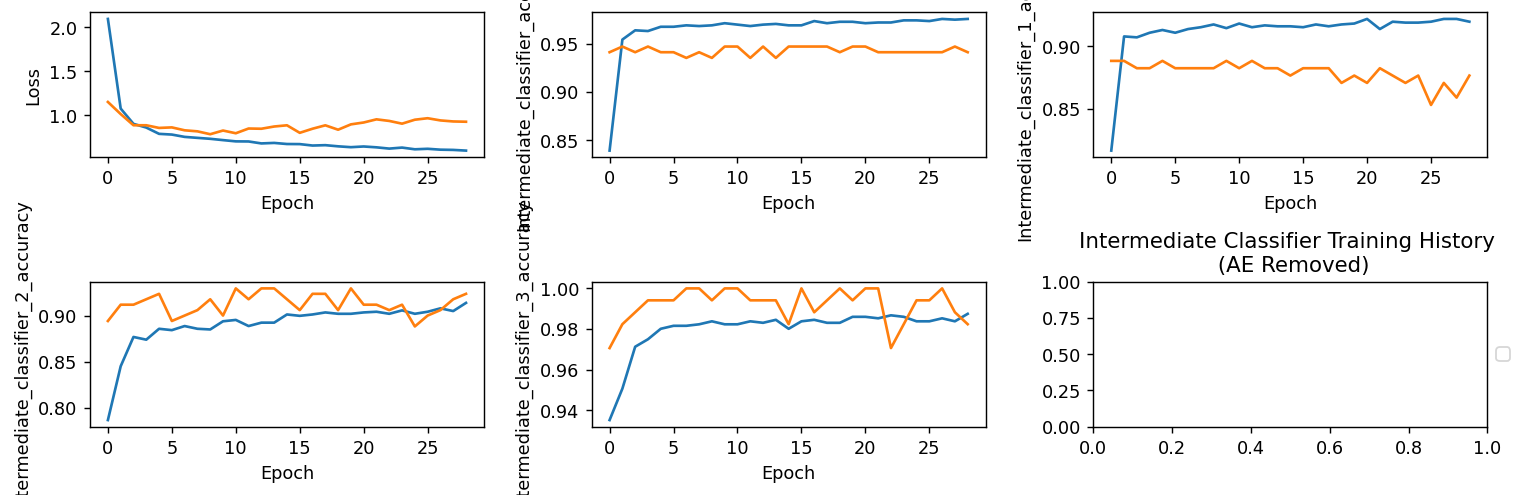

{'final_classifier_width': 4, 'intermediate_classifier_width': 256, 'num_layers_fc': 3, 'num_layers_ic': 3}:  56%|▌| 5/

Epoch 1/10000
85/85 [==============================] - 4s 31ms/step - loss: 2.0034 - intermediate_classifier_loss: 0.4724 - intermediate_classifier_1_loss: 0.5987 - intermediate_classifier_2_loss: 0.6987 - intermediate_classifier_3_loss: 0.2336 - intermediate_classifier_categorical_crossentropy: 0.4724 - intermediate_classifier_accuracy: 0.8532 - intermediate_classifier_1_categorical_crossentropy: 0.5987 - intermediate_classifier_1_accuracy: 0.7972 - intermediate_classifier_2_categorical_crossentropy: 0.6987 - intermediate_classifier_2_accuracy: 0.7950 - intermediate_classifier_3_categorical_crossentropy: 0.2336 - intermediate_classifier_3_accuracy: 0.9403 - val_loss: 1.0651 - val_intermediate_classifier_loss: 0.2430 - val_intermediate_classifier_1_loss: 0.3935 - val_intermediate_classifier_2_loss: 0.3491 - val_intermediate_classifier_3_loss: 0.0796 - val_intermediate_classifier_categorical_crossentropy: 0.2430 - val_intermediate_classifier_accuracy: 0.9471 - val_intermediate_classifie

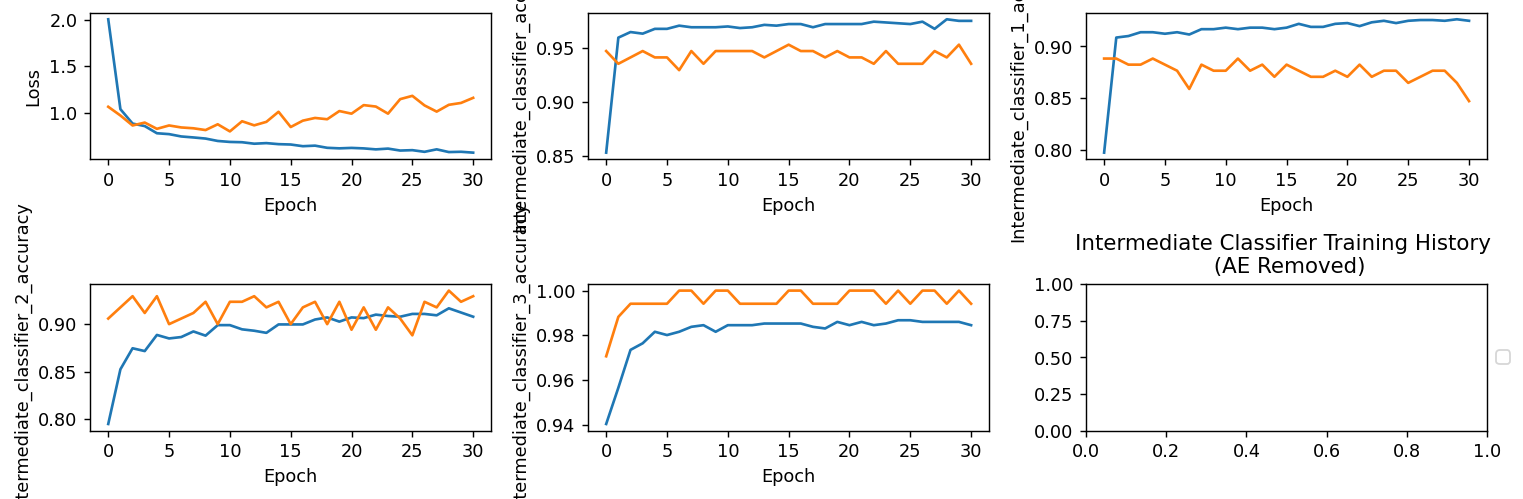

{'final_classifier_width': 4, 'intermediate_classifier_width': 512, 'num_layers_fc': 3, 'num_layers_ic': 1}:  67%|▋| 6/

Epoch 1/10000
85/85 [==============================] - 3s 25ms/step - loss: 2.5384 - intermediate_classifier_loss: 0.6901 - intermediate_classifier_1_loss: 0.7983 - intermediate_classifier_2_loss: 0.8034 - intermediate_classifier_3_loss: 0.2466 - intermediate_classifier_categorical_crossentropy: 0.6901 - intermediate_classifier_accuracy: 0.8201 - intermediate_classifier_1_categorical_crossentropy: 0.7983 - intermediate_classifier_1_accuracy: 0.7441 - intermediate_classifier_2_categorical_crossentropy: 0.8034 - intermediate_classifier_2_accuracy: 0.7633 - intermediate_classifier_3_categorical_crossentropy: 0.2466 - intermediate_classifier_3_accuracy: 0.9381 - val_loss: 1.4978 - val_intermediate_classifier_loss: 0.4321 - val_intermediate_classifier_1_loss: 0.5627 - val_intermediate_classifier_2_loss: 0.4082 - val_intermediate_classifier_3_loss: 0.0947 - val_intermediate_classifier_categorical_crossentropy: 0.4321 - val_intermediate_classifier_accuracy: 0.8353 - val_intermediate_classifie

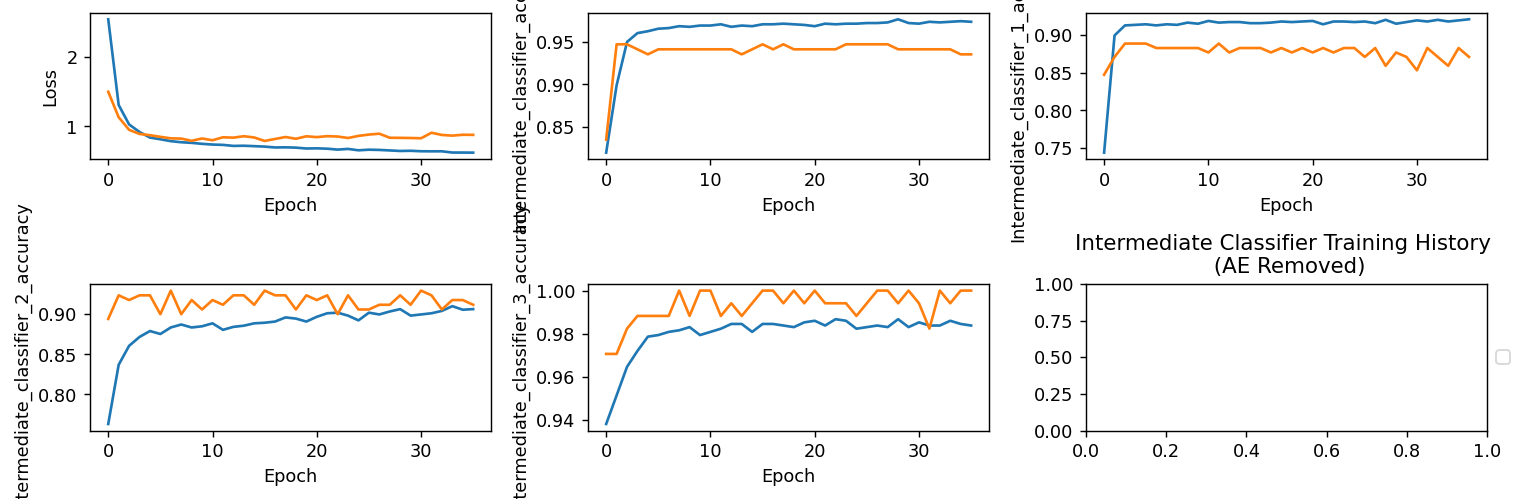

{'final_classifier_width': 4, 'intermediate_classifier_width': 512, 'num_layers_fc': 3, 'num_layers_ic': 2}:  78%|▊| 7/

Epoch 1/10000
85/85 [==============================] - 3s 21ms/step - loss: 1.7766 - intermediate_classifier_loss: 0.4114 - intermediate_classifier_1_loss: 0.5218 - intermediate_classifier_2_loss: 0.6368 - intermediate_classifier_3_loss: 0.2066 - intermediate_classifier_categorical_crossentropy: 0.4114 - intermediate_classifier_accuracy: 0.8791 - intermediate_classifier_1_categorical_crossentropy: 0.5218 - intermediate_classifier_1_accuracy: 0.8326 - intermediate_classifier_2_categorical_crossentropy: 0.6368 - intermediate_classifier_2_accuracy: 0.8083 - intermediate_classifier_3_categorical_crossentropy: 0.2066 - intermediate_classifier_3_accuracy: 0.9425 - val_loss: 1.0176 - val_intermediate_classifier_loss: 0.2430 - val_intermediate_classifier_1_loss: 0.3924 - val_intermediate_classifier_2_loss: 0.3144 - val_intermediate_classifier_3_loss: 0.0678 - val_intermediate_classifier_categorical_crossentropy: 0.2430 - val_intermediate_classifier_accuracy: 0.9353 - val_intermediate_classifie

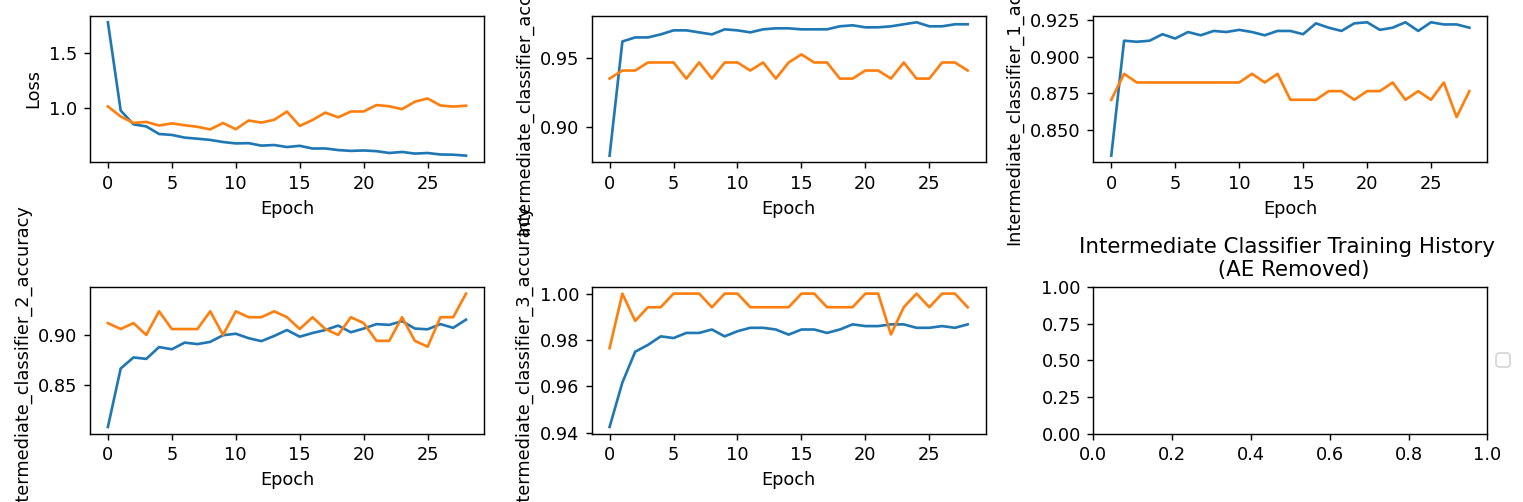

{'final_classifier_width': 4, 'intermediate_classifier_width': 512, 'num_layers_fc': 3, 'num_layers_ic': 3}:  89%|▉| 8/

Epoch 1/10000
85/85 [==============================] - 3s 24ms/step - loss: 1.6937 - intermediate_classifier_loss: 0.3683 - intermediate_classifier_1_loss: 0.4866 - intermediate_classifier_2_loss: 0.6217 - intermediate_classifier_3_loss: 0.2172 - intermediate_classifier_categorical_crossentropy: 0.3683 - intermediate_classifier_accuracy: 0.8901 - intermediate_classifier_1_categorical_crossentropy: 0.4866 - intermediate_classifier_1_accuracy: 0.8429 - intermediate_classifier_2_categorical_crossentropy: 0.6217 - intermediate_classifier_2_accuracy: 0.8097 - intermediate_classifier_3_categorical_crossentropy: 0.2172 - intermediate_classifier_3_accuracy: 0.9366 - val_loss: 1.0168 - val_intermediate_classifier_loss: 0.2515 - val_intermediate_classifier_1_loss: 0.3681 - val_intermediate_classifier_2_loss: 0.3326 - val_intermediate_classifier_3_loss: 0.0645 - val_intermediate_classifier_categorical_crossentropy: 0.2515 - val_intermediate_classifier_accuracy: 0.9353 - val_intermediate_classifie

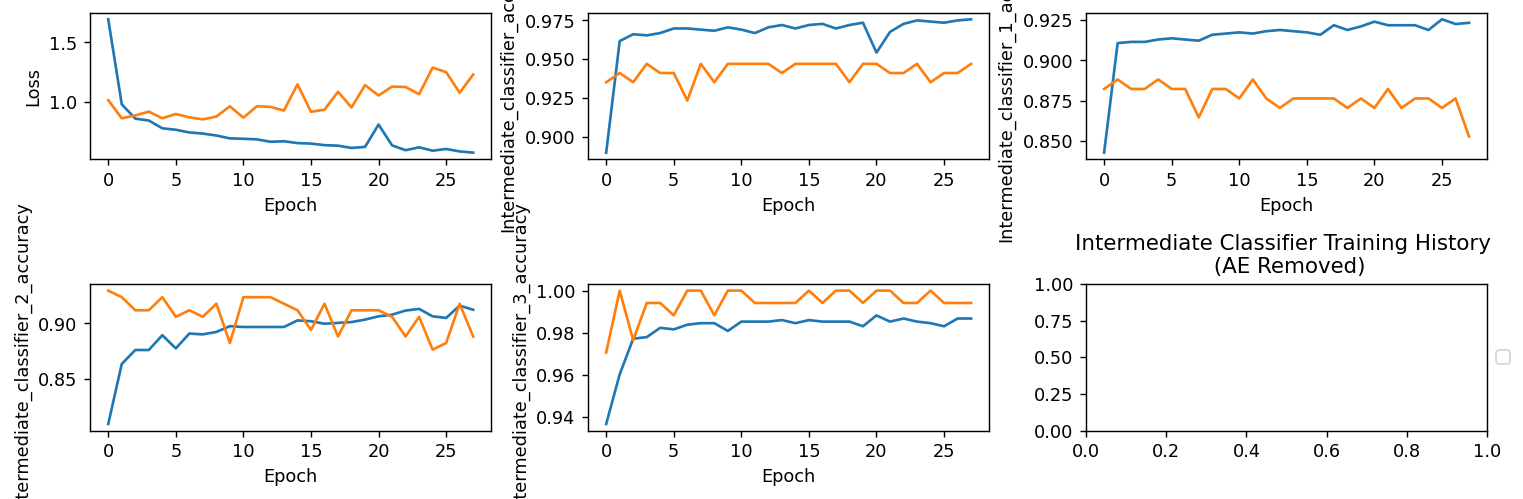

{'final_classifier_width': 4, 'intermediate_classifier_width': 512, 'num_layers_fc': 3, 'num_layers_ic': 3}: 100%|█| 9/

{'final_classifier_width': 4, 'intermediate_classifier_width': 256, 'num_layers_fc': 3, 'num_layers_ic': 2}


In [55]:
ae_removed_ic_best_hyperparameters, ae_removed_ic_tuning_df = tune_model(
    **data_dfs, 
    input_cols=col_info["input_cols"], intermediate_col_dict=col_info["intermediate_col_dict"], 
    output_cols=col_info["output_cols"], 
    le_label=col_info["le_label"], re_label=col_info["re_label"],
    Model_Class=BilateralModelAutoencoderRemoved,
    hyperparameter_list_dict=dict(
        intermediate_classifier_width=[128, 256, 512], 
        num_layers_ic=[1, 2, 3], 
        final_classifier_width=[4], # Actual... this doesn't matter
        num_layers_fc=[3], # Actual... this doesn't matter
    ), 
    train_function=train_ae_removed_ic, 
    batch_size=batch_size, max_epochs=max_epochs, 
    patience=20, verbose=1, seed=seed_no,
)
print(ae_removed_ic_best_hyperparameters)
display_tuning_df(ae_removed_ic_tuning_df)

In [56]:
# Save Hyperparameters
save_hyperparameters(
    best_hyperparameters=ae_removed_ic_best_hyperparameters, tuning_df=ae_removed_ic_tuning_df, 
    name="ae_removed_ic_softmax", fp_checkpoint_folder=fp_checkpoint_folder, override=True
)

Checkpoint exist!
Hyperparameters Saved!


In [57]:
# Load Hyperparameters
ae_removed_ic_best_hyperparameters, ae_removed_ic_tuning_df  = load_hyperparameters(
    name="ae_removed_ic_softmax", fp_checkpoint_folder=fp_checkpoint_folder)
print(ae_removed_ic_best_hyperparameters)
display_tuning_df(ae_removed_ic_tuning_df)

{'final_classifier_width': 4, 'intermediate_classifier_width': 256, 'num_layers_fc': 3, 'num_layers_ic': 2}


#### Training

Epoch 1/10000
85/85 [==============================] - 4s 24ms/step - loss: 2.0935 - intermediate_classifier_loss: 0.5335 - intermediate_classifier_1_loss: 0.6078 - intermediate_classifier_2_loss: 0.7216 - intermediate_classifier_3_loss: 0.2307 - intermediate_classifier_categorical_crossentropy: 0.5335 - intermediate_classifier_accuracy: 0.8392 - intermediate_classifier_1_categorical_crossentropy: 0.6078 - intermediate_classifier_1_accuracy: 0.8164 - intermediate_classifier_2_categorical_crossentropy: 0.7216 - intermediate_classifier_2_accuracy: 0.7869 - intermediate_classifier_3_categorical_crossentropy: 0.2307 - intermediate_classifier_3_accuracy: 0.9351 - val_loss: 1.1531 - val_intermediate_classifier_loss: 0.2778 - val_intermediate_classifier_1_loss: 0.4329 - val_intermediate_classifier_2_loss: 0.3611 - val_intermediate_classifier_3_loss: 0.0813 - val_intermediate_classifier_categorical_crossentropy: 0.2778 - val_intermediate_classifier_accuracy: 0.9412 - val_intermediate_classifie

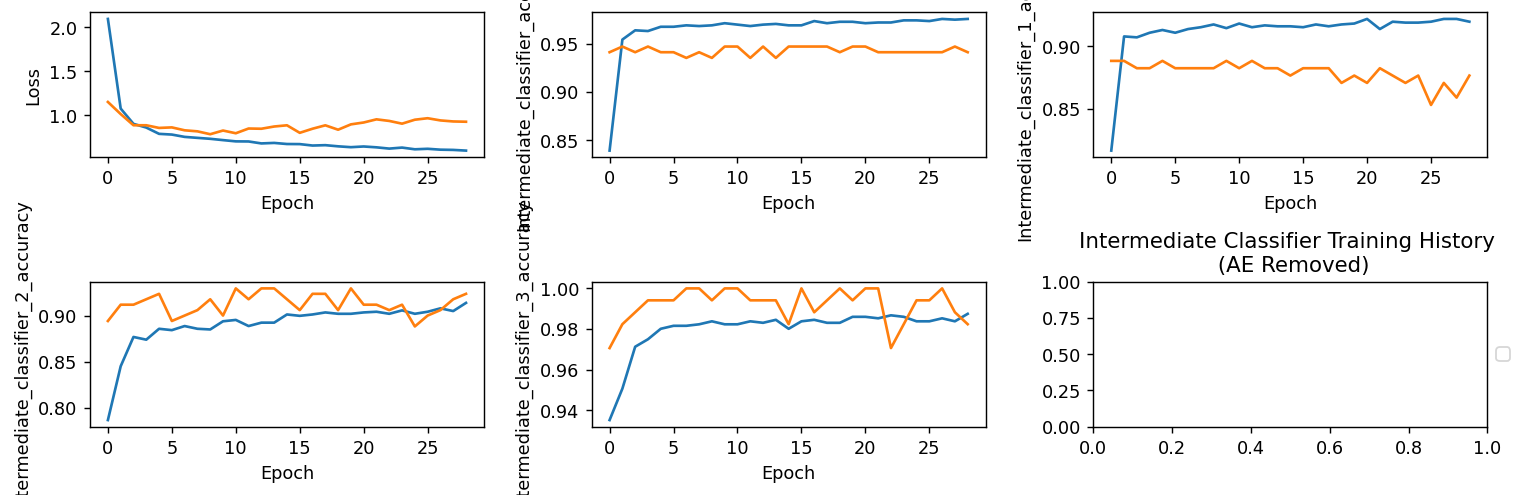

6/6 [==============================] - 0s 3ms/step


Train     Valid      Test
DMC Categorical_crossentropy   0.094380  0.196203  0.109920
AMDC Categorical_crossentropy  0.227231  0.303752  0.356026
DRC Categorical_crossentropy   0.299669  0.262430  0.382403
GSC Categorical_crossentropy   0.051989  0.025311  0.059621
DMC Accuracy                   0.971239  0.935294  0.976471
AMDC Accuracy                  0.918142  0.882353  0.882353
DRC Accuracy                   0.895280  0.917647  0.870588
GSC Accuracy                   0.982301  0.994118  0.976471
DMC F1_score                   0.941230  0.849274  0.885452
AMDC F1_score                  0.754672  0.545363  0.542471
DRC F1_score                   0.879377  0.626831  0.768980
GSC F1_score                   0.883860  0.887876  0.614932

DMC_M0  DMC_M1  DMC_M2  DMC_M3  DMC_M4  DMC_NA  AMDC_No  AMDC_Early  \
0        1.0     0.0     0.0     0.0     0.0     0.0      1.0         0.0   
1        1.0     0.0     0.0     0.0     0.0     0.0      0.0         1.0   
2        1.0     0.0     0.0     0.0     0.0     0.0      0.0         1.0   
3        0.0     0.0     1.0     0.0     0.0     0.0      0.0         0.0   
4        1.0     0.0     0.0     0.0     0.0     0.0      0.0         1.0   
...      ...     ...     ...     ...     ...     ...      ...         ...   
1691     0.0     0.0     1.0     0.0     0.0     0.0      1.0         0.0   
1692     1.0     0.0     0.0     0.0     0.0     0.0      1.0         0.0   
1693     1.0     0.0     0.0     0.0     0.0     0.0      0.0         0.0   
1694     1.0     0.0     0.0     0.0     0.0     0.0      0.0         1.0   
1695     0.0     0.0     1.0     0.0     0.0     0.0      1.0         0.0   

      AMDC_Intermediate  AMDC_Advanced_1  ...  DRC_MildNPDR_pred  \
0                   0.0              0.0  ...           0.000042   
1                   0.0              0.0  ...           0.054096   
2                   0.0              0.0  ...           0.085422   
3                   1.0              0.0  ...           0.987738   
4                   0.0              0.0  ...           0.038255   
...                 ...              ...  ...                ...   
1691                0.0              0.0  ...           0.987841   
1692                0.0              0.0  ...           0.000299   
1693                1.0              0.0  ...           0.022623   
1694                0.0              0.0  ...           0.023788   
1695                0.0              0.0  ...           0.437215   

      DRC_ModerateNPDR_pred  DRC_SevereNPDR_pred  DRC_ProliferativeDR_pred  \
0                  0.000015         8.277787e-07              1.755051e-07   
1                  0.004905         1.136644e-04              5.275648e-05   
2                  0.047344         3.145381e-04              7.795636e-04   
3                  0.012068         4.032864e-05              1.916267e-05   
4                  0.004184         6.024781e-05              3.809855e-05   
...                     ...                  ...                       ...   
1691               0.012003         6.993567e-05              1.450059e-05   
1692               0.000462         2.783638e-05              3.271737e-06   
1693               0.002445         3.996177e-05              2.205451e-05   
1694               0.025494         3.151067e-04              3.412767e-04   
1695               0.533668         1.827947e-03              1.974516e-03   

      DRC_Unreadable_pred   DRC_NA_pred  GSC_G0_pred  GSC_G1_pred  \
0                0.000004  3.852411e-09     0.000948     0.999035   
1                0.000257  1.086656e-05     0.989401     0.010405   
2                0.004232  9.205766e-05     0.996453     0.001235   
3                0.000002  1.308477e-07     0.999990     0.000010   
4                0.000229  6.974629e-06     0.991973     0.007876   
...                   ...           ...          ...          ...   
1691             0.000004  1.582126e-07     0.999974     0.000021   
1692             0.000004  1.156435e-07     0.000753     0.999241   
1693             0.000285  3.420960e-06     0.979141     0.020729   
1694             0.000810  4.851375e-05     0.965458     0.033770   
1695             0.000901  1.002562e-04     0.997452     0.002479   

       GSC_NA_pred  split  
0     1.752261e-05  train  
1     1.934380e-04  train  
2     2.311866e-03  train  
3     3.046822e-07  train  
4     1.511650e-04  train  
...            ...    ...  
1691  5.508089e-06   test  
1692  5.948546e-06   test  
1693  1.301327e-04   test  
1694  7.724359e-04   test  
1695  6.885152e-05   test  

[1696 rows x 45 columns]

In [58]:
set_seed(seed_no)
ae_removed_ic_bilateral_model = BilateralModelAutoencoderRemoved(
    input_cols=col_info["input_cols"], intermediate_col_dict=col_info["intermediate_col_dict"], 
    output_cols=col_info["output_cols"], 
    le_label=col_info["le_label"], re_label=col_info["re_label"],
    **ae_removed_ic_best_hyperparameters,
)
train_ae_removed_ic(
    ae_removed_ic_bilateral_model, **data_dfs,
    batch_size=batch_size, max_epochs=max_epochs, 
    patience=20, verbose=1
)
ae_removed_ic_perf_df, ae_removed_ic_pred_df = evaluate_ic(
    ae_removed_ic_bilateral_model, **data_dfs, get_ic_function=get_ae_removed_ic_model
)
display(ae_removed_ic_perf_df)
display(ae_removed_ic_pred_df)

In [59]:
# Save model
fp_ae_removed_ic_model_checkpoint = os.path.join(fp_checkpoint_folder, "models", "ae_removed_ic_softmax")
ae_removed_ic_bilateral_model(tf.random.normal((2,num_input_cols)), tf.random.normal((2,num_input_cols)))
ae_removed_ic_bilateral_model.save(fp_ae_removed_ic_model_checkpoint)

INFO:tensorflow:Assets written to: ./checkpoints\models\ae_removed_ic_softmax\assets


INFO:tensorflow:Assets written to: ./checkpoints\models\ae_removed_ic_softmax\assets


In [60]:
# Load model
fp_ae_removed_ic_model_checkpoint = os.path.join(fp_checkpoint_folder, "models", "ae_removed_ic_softmax")
ae_removed_ic_bilateral_model = tf.keras.models.load_model(fp_ae_removed_ic_model_checkpoint)
ae_removed_ic_perf_df, ae_removed_ic_pred_df = evaluate_ic(
    ae_removed_ic_bilateral_model, **data_dfs, get_ic_function=get_ae_removed_ic_model
)
display(ae_removed_ic_perf_df)
display(ae_removed_ic_pred_df)

6/6 [==============================] - 0s 3ms/step


Train     Valid      Test
DMC Categorical_crossentropy   0.094380  0.196203  0.109920
AMDC Categorical_crossentropy  0.227231  0.303752  0.356026
DRC Categorical_crossentropy   0.299669  0.262430  0.382403
GSC Categorical_crossentropy   0.051989  0.025311  0.059621
DMC Accuracy                   0.971239  0.935294  0.976471
AMDC Accuracy                  0.918142  0.882353  0.882353
DRC Accuracy                   0.895280  0.917647  0.870588
GSC Accuracy                   0.982301  0.994118  0.976471
DMC F1_score                   0.941230  0.849274  0.885452
AMDC F1_score                  0.754672  0.545363  0.542471
DRC F1_score                   0.879377  0.626831  0.768980
GSC F1_score                   0.883860  0.887876  0.614932

DMC_M0  DMC_M1  DMC_M2  DMC_M3  DMC_M4  DMC_NA  AMDC_No  AMDC_Early  \
0        1.0     0.0     0.0     0.0     0.0     0.0      1.0         0.0   
1        1.0     0.0     0.0     0.0     0.0     0.0      0.0         1.0   
2        1.0     0.0     0.0     0.0     0.0     0.0      0.0         1.0   
3        0.0     0.0     1.0     0.0     0.0     0.0      0.0         0.0   
4        1.0     0.0     0.0     0.0     0.0     0.0      0.0         1.0   
...      ...     ...     ...     ...     ...     ...      ...         ...   
1691     0.0     0.0     1.0     0.0     0.0     0.0      1.0         0.0   
1692     1.0     0.0     0.0     0.0     0.0     0.0      1.0         0.0   
1693     1.0     0.0     0.0     0.0     0.0     0.0      0.0         0.0   
1694     1.0     0.0     0.0     0.0     0.0     0.0      0.0         1.0   
1695     0.0     0.0     1.0     0.0     0.0     0.0      1.0         0.0   

      AMDC_Intermediate  AMDC_Advanced_1  ...  DRC_MildNPDR_pred  \
0                   0.0              0.0  ...           0.000042   
1                   0.0              0.0  ...           0.054096   
2                   0.0              0.0  ...           0.085422   
3                   1.0              0.0  ...           0.987738   
4                   0.0              0.0  ...           0.038255   
...                 ...              ...  ...                ...   
1691                0.0              0.0  ...           0.987841   
1692                0.0              0.0  ...           0.000299   
1693                1.0              0.0  ...           0.022623   
1694                0.0              0.0  ...           0.023788   
1695                0.0              0.0  ...           0.437215   

      DRC_ModerateNPDR_pred  DRC_SevereNPDR_pred  DRC_ProliferativeDR_pred  \
0                  0.000015         8.277787e-07              1.755051e-07   
1                  0.004905         1.136644e-04              5.275648e-05   
2                  0.047344         3.145381e-04              7.795636e-04   
3                  0.012068         4.032864e-05              1.916267e-05   
4                  0.004184         6.024781e-05              3.809855e-05   
...                     ...                  ...                       ...   
1691               0.012003         6.993567e-05              1.450059e-05   
1692               0.000462         2.783638e-05              3.271737e-06   
1693               0.002445         3.996177e-05              2.205451e-05   
1694               0.025494         3.151067e-04              3.412767e-04   
1695               0.533668         1.827947e-03              1.974516e-03   

      DRC_Unreadable_pred   DRC_NA_pred  GSC_G0_pred  GSC_G1_pred  \
0                0.000004  3.852411e-09     0.000948     0.999035   
1                0.000257  1.086656e-05     0.989401     0.010405   
2                0.004232  9.205766e-05     0.996453     0.001235   
3                0.000002  1.308477e-07     0.999990     0.000010   
4                0.000229  6.974629e-06     0.991973     0.007876   
...                   ...           ...          ...          ...   
1691             0.000004  1.582126e-07     0.999974     0.000021   
1692             0.000004  1.156435e-07     0.000753     0.999241   
1693             0.000285  3.420960e-06     0.979141     0.020729   
1694             0.000810  4.851375e-05     0.965458     0.033770   
1695             0.000901  1.002562e-04     0.997452     0.002479   

       GSC_NA_pred  split  
0     1.752261e-05  train  
1     1.934380e-04  train  
2     2.311866e-03  train  
3     3.046822e-07  train  
4     1.511650e-04  train  
...            ...    ...  
1691  5.508089e-06   test  
1692  5.948546e-06   test  
1693  1.301327e-04   test  
1694  7.724359e-04   test  
1695  6.885152e-05   test  

[1696 rows x 45 columns]

In [61]:
save_predictions(
    prediction_df=ae_removed_ic_pred_df, name="ae_removed_ic_softmax", 
    fp_checkpoint_folder=fp_checkpoint_folder
)

Predictions Saved!


### Train Final Classifier

#### Tuning

{'final_classifier_width': 32, 'intermediate_classifier_width': 256, 'num_layers_fc': 2, 'num_layers_ic': 2}:   0%| | 0

Epoch 1/10000
43/43 [==============================] - 2s 21ms/step - loss: 1.0185 - binary_crossentropy: 1.0185 - binary_accuracy: 0.1873 - val_loss: 0.7659 - val_binary_crossentropy: 0.7659 - val_binary_accuracy: 0.4565
Epoch 2/10000
43/43 [==============================] - 0s 11ms/step - loss: 0.5356 - binary_crossentropy: 0.5356 - binary_accuracy: 0.7345 - val_loss: 0.3397 - val_binary_crossentropy: 0.3397 - val_binary_accuracy: 0.8706
Epoch 3/10000
43/43 [==============================] - 1s 13ms/step - loss: 0.2738 - binary_crossentropy: 0.2738 - binary_accuracy: 0.9127 - val_loss: 0.2650 - val_binary_crossentropy: 0.2650 - val_binary_accuracy: 0.9035
Epoch 4/10000
43/43 [==============================] - 1s 12ms/step - loss: 0.2077 - binary_crossentropy: 0.2077 - binary_accuracy: 0.9206 - val_loss: 0.2445 - val_binary_crossentropy: 0.2445 - val_binary_accuracy: 0.9082
Epoch 5/10000
43/43 [==============================] - 1s 15ms/step - loss: 0.1733 - binary_crossentropy: 0.1733

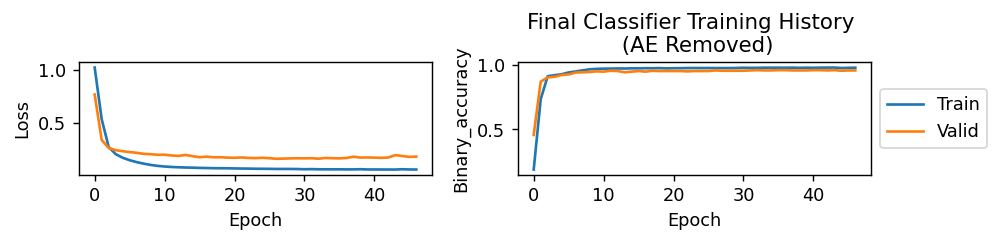

{'final_classifier_width': 32, 'intermediate_classifier_width': 256, 'num_layers_fc': 3, 'num_layers_ic': 2}:  10%| | 1

Epoch 1/10000
43/43 [==============================] - 2s 21ms/step - loss: 0.9487 - binary_crossentropy: 0.9487 - binary_accuracy: 0.2699 - val_loss: 0.5779 - val_binary_crossentropy: 0.5779 - val_binary_accuracy: 0.6894
Epoch 2/10000
43/43 [==============================] - 1s 13ms/step - loss: 0.3584 - binary_crossentropy: 0.3584 - binary_accuracy: 0.8841 - val_loss: 0.2665 - val_binary_crossentropy: 0.2665 - val_binary_accuracy: 0.9059
Epoch 3/10000
43/43 [==============================] - 1s 14ms/step - loss: 0.2006 - binary_crossentropy: 0.2006 - binary_accuracy: 0.9209 - val_loss: 0.2405 - val_binary_crossentropy: 0.2405 - val_binary_accuracy: 0.9059
Epoch 4/10000
43/43 [==============================] - 1s 14ms/step - loss: 0.1647 - binary_crossentropy: 0.1647 - binary_accuracy: 0.9254 - val_loss: 0.2384 - val_binary_crossentropy: 0.2384 - val_binary_accuracy: 0.9153
Epoch 5/10000
43/43 [==============================] - 0s 11ms/step - loss: 0.1402 - binary_crossentropy: 0.1402

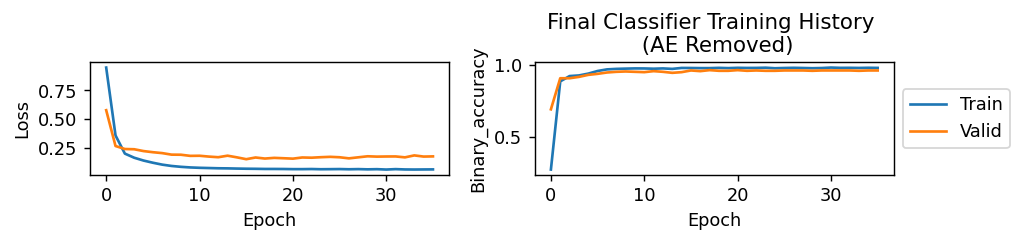

{'final_classifier_width': 48, 'intermediate_classifier_width': 256, 'num_layers_fc': 2, 'num_layers_ic': 2}:  20%|▏| 2

Epoch 1/10000
43/43 [==============================] - 2s 21ms/step - loss: 0.8999 - binary_crossentropy: 0.8999 - binary_accuracy: 0.2959 - val_loss: 0.5621 - val_binary_crossentropy: 0.5621 - val_binary_accuracy: 0.7176
Epoch 2/10000
43/43 [==============================] - 1s 14ms/step - loss: 0.3672 - binary_crossentropy: 0.3672 - binary_accuracy: 0.8737 - val_loss: 0.2767 - val_binary_crossentropy: 0.2767 - val_binary_accuracy: 0.9059
Epoch 3/10000
43/43 [==============================] - 1s 12ms/step - loss: 0.2112 - binary_crossentropy: 0.2112 - binary_accuracy: 0.9204 - val_loss: 0.2430 - val_binary_crossentropy: 0.2430 - val_binary_accuracy: 0.9106
Epoch 4/10000
43/43 [==============================] - 1s 14ms/step - loss: 0.1693 - binary_crossentropy: 0.1693 - binary_accuracy: 0.9336 - val_loss: 0.2334 - val_binary_crossentropy: 0.2334 - val_binary_accuracy: 0.9129
Epoch 5/10000
43/43 [==============================] - 1s 14ms/step - loss: 0.1404 - binary_crossentropy: 0.1404

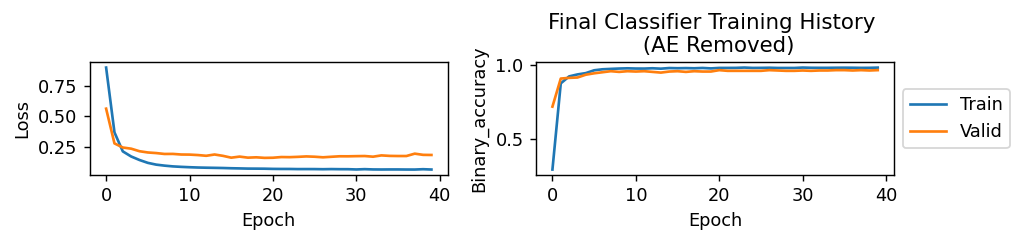

{'final_classifier_width': 48, 'intermediate_classifier_width': 256, 'num_layers_fc': 3, 'num_layers_ic': 2}:  30%|▎| 3

Epoch 1/10000
43/43 [==============================] - 2s 21ms/step - loss: 0.7309 - binary_crossentropy: 0.7309 - binary_accuracy: 0.4888 - val_loss: 0.3092 - val_binary_crossentropy: 0.3092 - val_binary_accuracy: 0.9082
Epoch 2/10000
43/43 [==============================] - 1s 15ms/step - loss: 0.2402 - binary_crossentropy: 0.2402 - binary_accuracy: 0.9150 - val_loss: 0.2513 - val_binary_crossentropy: 0.2513 - val_binary_accuracy: 0.9082
Epoch 3/10000
43/43 [==============================] - 1s 12ms/step - loss: 0.1782 - binary_crossentropy: 0.1782 - binary_accuracy: 0.9260 - val_loss: 0.2321 - val_binary_crossentropy: 0.2321 - val_binary_accuracy: 0.9200
Epoch 4/10000
43/43 [==============================] - 1s 14ms/step - loss: 0.1408 - binary_crossentropy: 0.1408 - binary_accuracy: 0.9437 - val_loss: 0.2196 - val_binary_crossentropy: 0.2196 - val_binary_accuracy: 0.9318
Epoch 5/10000
43/43 [==============================] - 1s 16ms/step - loss: 0.1089 - binary_crossentropy: 0.1089

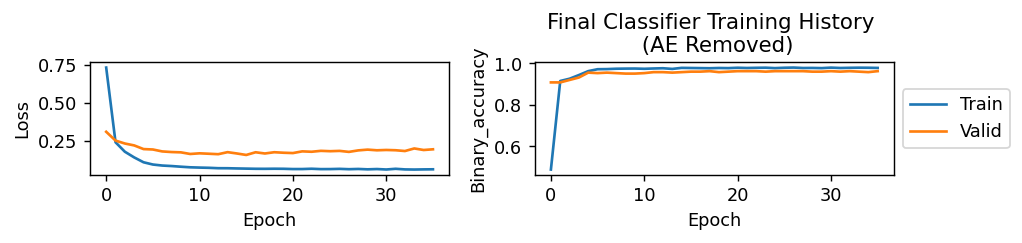

{'final_classifier_width': 64, 'intermediate_classifier_width': 256, 'num_layers_fc': 2, 'num_layers_ic': 2}:  40%|▍| 4

Epoch 1/10000
43/43 [==============================] - 2s 36ms/step - loss: 0.8010 - binary_crossentropy: 0.8010 - binary_accuracy: 0.4345 - val_loss: 0.4120 - val_binary_crossentropy: 0.4120 - val_binary_accuracy: 0.8447
Epoch 2/10000
43/43 [==============================] - 1s 15ms/step - loss: 0.2850 - binary_crossentropy: 0.2850 - binary_accuracy: 0.9029 - val_loss: 0.2660 - val_binary_crossentropy: 0.2660 - val_binary_accuracy: 0.9106
Epoch 3/10000
43/43 [==============================] - 1s 13ms/step - loss: 0.1878 - binary_crossentropy: 0.1878 - binary_accuracy: 0.9245 - val_loss: 0.2373 - val_binary_crossentropy: 0.2373 - val_binary_accuracy: 0.9129
Epoch 4/10000
43/43 [==============================] - 0s 11ms/step - loss: 0.1449 - binary_crossentropy: 0.1449 - binary_accuracy: 0.9413 - val_loss: 0.2237 - val_binary_crossentropy: 0.2237 - val_binary_accuracy: 0.9176
Epoch 5/10000
43/43 [==============================] - 1s 13ms/step - loss: 0.1149 - binary_crossentropy: 0.1149

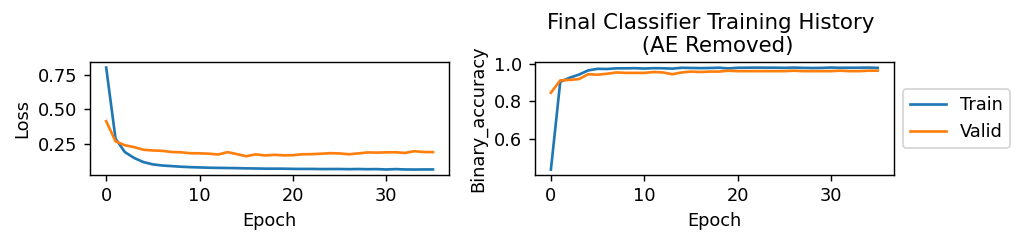

{'final_classifier_width': 64, 'intermediate_classifier_width': 256, 'num_layers_fc': 3, 'num_layers_ic': 2}:  50%|▌| 5

Epoch 1/10000
43/43 [==============================] - 2s 22ms/step - loss: 0.6658 - binary_crossentropy: 0.6658 - binary_accuracy: 0.5389 - val_loss: 0.3049 - val_binary_crossentropy: 0.3049 - val_binary_accuracy: 0.8965
Epoch 2/10000
43/43 [==============================] - 1s 12ms/step - loss: 0.2397 - binary_crossentropy: 0.2397 - binary_accuracy: 0.9162 - val_loss: 0.2588 - val_binary_crossentropy: 0.2588 - val_binary_accuracy: 0.9082
Epoch 3/10000
43/43 [==============================] - 0s 10ms/step - loss: 0.1723 - binary_crossentropy: 0.1723 - binary_accuracy: 0.9257 - val_loss: 0.2436 - val_binary_crossentropy: 0.2436 - val_binary_accuracy: 0.9153
Epoch 4/10000
43/43 [==============================] - 0s 9ms/step - loss: 0.1317 - binary_crossentropy: 0.1317 - binary_accuracy: 0.9481 - val_loss: 0.2335 - val_binary_crossentropy: 0.2335 - val_binary_accuracy: 0.9365
Epoch 5/10000
43/43 [==============================] - 0s 9ms/step - loss: 0.1012 - binary_crossentropy: 0.1012 -

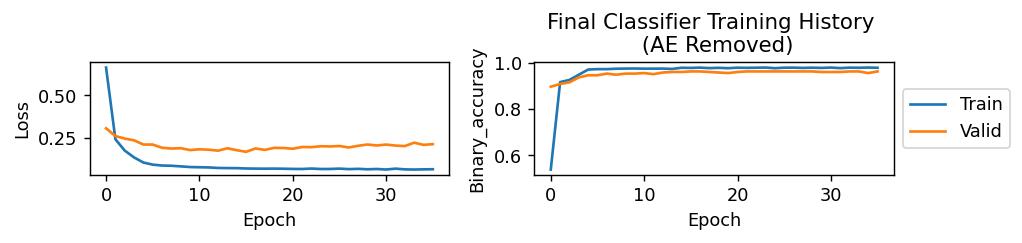

{'final_classifier_width': 80, 'intermediate_classifier_width': 256, 'num_layers_fc': 2, 'num_layers_ic': 2}:  60%|▌| 6

Epoch 1/10000
43/43 [==============================] - 1s 16ms/step - loss: 0.6844 - binary_crossentropy: 0.6844 - binary_accuracy: 0.5333 - val_loss: 0.3011 - val_binary_crossentropy: 0.3011 - val_binary_accuracy: 0.9082
Epoch 2/10000
43/43 [==============================] - 0s 8ms/step - loss: 0.2177 - binary_crossentropy: 0.2177 - binary_accuracy: 0.9257 - val_loss: 0.2339 - val_binary_crossentropy: 0.2339 - val_binary_accuracy: 0.9224
Epoch 3/10000
43/43 [==============================] - 0s 8ms/step - loss: 0.1580 - binary_crossentropy: 0.1580 - binary_accuracy: 0.9363 - val_loss: 0.2128 - val_binary_crossentropy: 0.2128 - val_binary_accuracy: 0.9271
Epoch 4/10000
43/43 [==============================] - 0s 8ms/step - loss: 0.1257 - binary_crossentropy: 0.1257 - binary_accuracy: 0.9528 - val_loss: 0.2055 - val_binary_crossentropy: 0.2055 - val_binary_accuracy: 0.9388
Epoch 5/10000
43/43 [==============================] - 0s 9ms/step - loss: 0.1022 - binary_crossentropy: 0.1022 - b

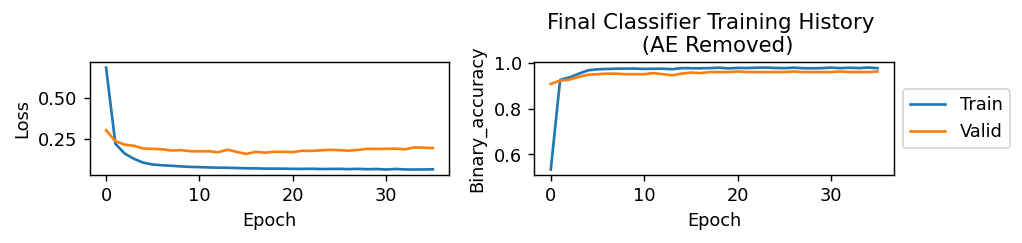

{'final_classifier_width': 80, 'intermediate_classifier_width': 256, 'num_layers_fc': 3, 'num_layers_ic': 2}:  70%|▋| 7

Epoch 1/10000
43/43 [==============================] - 1s 16ms/step - loss: 0.5954 - binary_crossentropy: 0.5954 - binary_accuracy: 0.6044 - val_loss: 0.2865 - val_binary_crossentropy: 0.2865 - val_binary_accuracy: 0.9035
Epoch 2/10000
43/43 [==============================] - 0s 9ms/step - loss: 0.2027 - binary_crossentropy: 0.2027 - binary_accuracy: 0.9189 - val_loss: 0.2453 - val_binary_crossentropy: 0.2453 - val_binary_accuracy: 0.9129
Epoch 3/10000
43/43 [==============================] - 0s 9ms/step - loss: 0.1514 - binary_crossentropy: 0.1514 - binary_accuracy: 0.9324 - val_loss: 0.2260 - val_binary_crossentropy: 0.2260 - val_binary_accuracy: 0.9318
Epoch 4/10000
43/43 [==============================] - 0s 8ms/step - loss: 0.1155 - binary_crossentropy: 0.1155 - binary_accuracy: 0.9602 - val_loss: 0.2170 - val_binary_crossentropy: 0.2170 - val_binary_accuracy: 0.9435
Epoch 5/10000
43/43 [==============================] - 0s 8ms/step - loss: 0.0921 - binary_crossentropy: 0.0921 - b

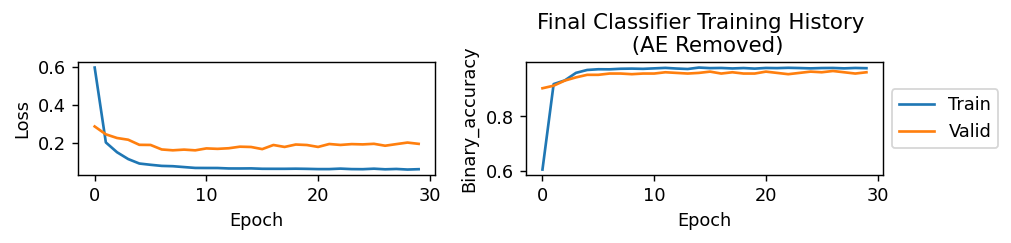

{'final_classifier_width': 96, 'intermediate_classifier_width': 256, 'num_layers_fc': 2, 'num_layers_ic': 2}:  80%|▊| 8

Epoch 1/10000
43/43 [==============================] - 2s 22ms/step - loss: 0.6597 - binary_crossentropy: 0.6597 - binary_accuracy: 0.5640 - val_loss: 0.2983 - val_binary_crossentropy: 0.2983 - val_binary_accuracy: 0.9059
Epoch 2/10000
43/43 [==============================] - 1s 13ms/step - loss: 0.2174 - binary_crossentropy: 0.2174 - binary_accuracy: 0.9189 - val_loss: 0.2408 - val_binary_crossentropy: 0.2408 - val_binary_accuracy: 0.9106
Epoch 3/10000
43/43 [==============================] - 1s 11ms/step - loss: 0.1651 - binary_crossentropy: 0.1651 - binary_accuracy: 0.9307 - val_loss: 0.2194 - val_binary_crossentropy: 0.2194 - val_binary_accuracy: 0.9153
Epoch 4/10000
43/43 [==============================] - 0s 10ms/step - loss: 0.1327 - binary_crossentropy: 0.1327 - binary_accuracy: 0.9487 - val_loss: 0.2077 - val_binary_crossentropy: 0.2077 - val_binary_accuracy: 0.9341
Epoch 5/10000
43/43 [==============================] - 0s 11ms/step - loss: 0.1041 - binary_crossentropy: 0.1041

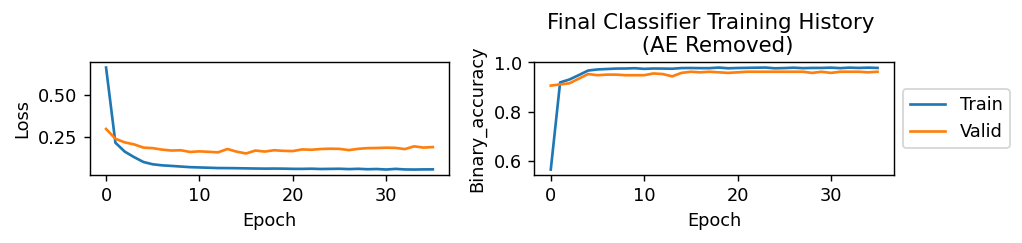

{'final_classifier_width': 96, 'intermediate_classifier_width': 256, 'num_layers_fc': 3, 'num_layers_ic': 2}:  90%|▉| 9

Epoch 1/10000
43/43 [==============================] - 2s 22ms/step - loss: 0.5655 - binary_crossentropy: 0.5655 - binary_accuracy: 0.6345 - val_loss: 0.2623 - val_binary_crossentropy: 0.2623 - val_binary_accuracy: 0.9082
Epoch 2/10000
43/43 [==============================] - 1s 13ms/step - loss: 0.1802 - binary_crossentropy: 0.1802 - binary_accuracy: 0.9280 - val_loss: 0.2339 - val_binary_crossentropy: 0.2339 - val_binary_accuracy: 0.9153
Epoch 3/10000
43/43 [==============================] - 1s 12ms/step - loss: 0.1304 - binary_crossentropy: 0.1304 - binary_accuracy: 0.9522 - val_loss: 0.2110 - val_binary_crossentropy: 0.2110 - val_binary_accuracy: 0.9459
Epoch 4/10000
43/43 [==============================] - 1s 13ms/step - loss: 0.0956 - binary_crossentropy: 0.0956 - binary_accuracy: 0.9714 - val_loss: 0.2070 - val_binary_crossentropy: 0.2070 - val_binary_accuracy: 0.9506
Epoch 5/10000
43/43 [==============================] - 1s 15ms/step - loss: 0.0825 - binary_crossentropy: 0.0825

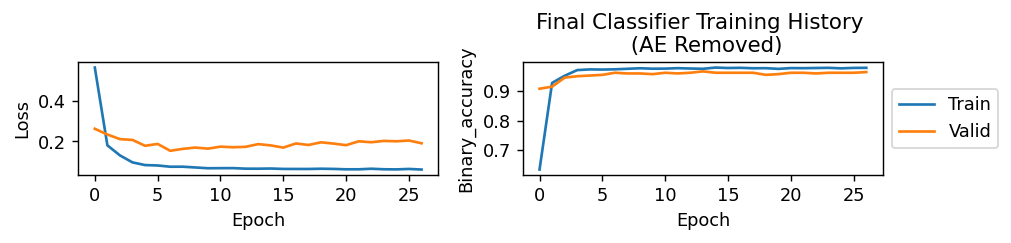

{'final_classifier_width': 96, 'intermediate_classifier_width': 256, 'num_layers_fc': 3, 'num_layers_ic': 2}: 100%|█| 1

{'final_classifier_width': 32, 'intermediate_classifier_width': 256, 'num_layers_fc': 3, 'num_layers_ic': 2}


In [62]:
ae_removed_fc_best_hyperparameters, ae_removed_fc_tuning_df = tune_model(
    **data_dfs, 
    input_cols=col_info["input_cols"], intermediate_col_dict=col_info["intermediate_col_dict"], 
    output_cols=col_info["output_cols"], 
    le_label=col_info["le_label"], re_label=col_info["re_label"],
    Model_Class=BilateralModelAutoencoderRemoved,
    hyperparameter_list_dict=dict(
        intermediate_classifier_width=[ae_removed_ic_best_hyperparameters["intermediate_classifier_width"]],
        num_layers_ic=[ae_removed_ic_best_hyperparameters["num_layers_ic"]],
        final_classifier_width=[32, 48, 64, 80, 96], 
        num_layers_fc=[2, 3], 
    ), 
    train_function=train_ae_removed_fc, 
    base_bilateral_model=ae_removed_ic_bilateral_model, transfer_function=transfer_ic,
    batch_size=batch_size, 
    max_epochs=max_epochs, 
    patience=20, verbose=1, seed=seed_no,
)
print(ae_removed_fc_best_hyperparameters)
display_tuning_df(ae_removed_fc_tuning_df)

In [63]:
# Save Hyperparameters
save_hyperparameters(
    best_hyperparameters=ae_removed_fc_best_hyperparameters, tuning_df=ae_removed_fc_tuning_df, 
    name="ae_removed_fc_softmax", fp_checkpoint_folder=fp_checkpoint_folder, override=True
)

Checkpoint exist!
Hyperparameters Saved!


In [64]:
# Load Hyperparameters
ae_removed_fc_best_hyperparameters, ae_removed_fc_tuning_df  = load_hyperparameters(
    name="ae_removed_fc_softmax", fp_checkpoint_folder=fp_checkpoint_folder)
print(ae_removed_fc_best_hyperparameters)
display_tuning_df(ae_removed_fc_tuning_df)

{'final_classifier_width': 32, 'intermediate_classifier_width': 256, 'num_layers_fc': 3, 'num_layers_ic': 2}


#### Training

Epoch 1/10000
43/43 [==============================] - 3s 24ms/step - loss: 0.9255 - binary_crossentropy: 0.9255 - binary_accuracy: 0.2673 - val_loss: 0.5719 - val_binary_crossentropy: 0.5719 - val_binary_accuracy: 0.8447
Epoch 2/10000
43/43 [==============================] - 1s 14ms/step - loss: 0.4157 - binary_crossentropy: 0.4157 - binary_accuracy: 0.8333 - val_loss: 0.3387 - val_binary_crossentropy: 0.3387 - val_binary_accuracy: 0.8447
Epoch 3/10000
43/43 [==============================] - 1s 16ms/step - loss: 0.3083 - binary_crossentropy: 0.3083 - binary_accuracy: 0.8817 - val_loss: 0.3052 - val_binary_crossentropy: 0.3052 - val_binary_accuracy: 0.9059
Epoch 4/10000
43/43 [==============================] - 1s 12ms/step - loss: 0.2621 - binary_crossentropy: 0.2621 - binary_accuracy: 0.9147 - val_loss: 0.2821 - val_binary_crossentropy: 0.2821 - val_binary_accuracy: 0.9059
Epoch 5/10000
43/43 [==============================] - 1s 13ms/step - loss: 0.2159 - binary_crossentropy: 0.2159

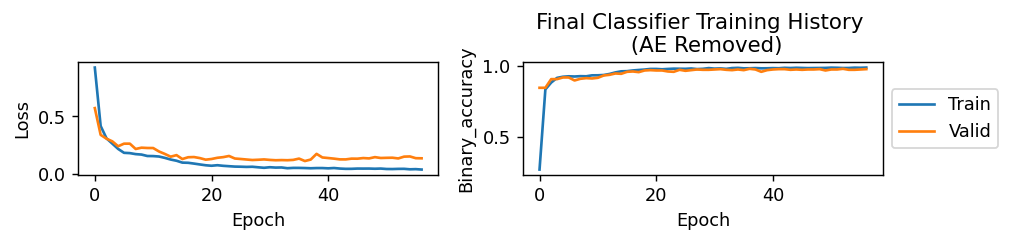

3/3 [==============================] - 0s 5ms/step


Train  Valid   Test
Accuracy Total_Time >= 1.0     0.000  0.000    NaN
Accuracy Total_Time >= 13.0    0.667  0.909  0.667
Accuracy Total_Time >= 26.0    0.984  0.964  0.889
Accuracy Total_Time >= 4.33    1.000  1.000  0.875
Accuracy Total_Time >= 52.0    0.997  0.949  0.974
Final Classifier Accuracy      0.935  0.929  0.894
Final Classifier Bin Accuracy  0.985  0.979  0.972
Final Classifier Crossentropy  0.043  0.110  0.113
Total_Time >= 1.0 Proportion   0.004  0.024  0.000
Total_Time >= 13.0 Proportion  0.164  0.129  0.141
Total_Time >= 26.0 Proportion  0.268  0.329  0.318
Total_Time >= 4.33 Proportion  0.069  0.059  0.094
Total_Time >= 52.0 Proportion  0.494  0.459  0.447

Total_Time >= 1.0  Total_Time >= 4.33  Total_Time >= 13.0  \
0                  1.0                 1.0                 1.0   
1                  1.0                 1.0                 1.0   
2                  1.0                 1.0                 1.0   
3                  1.0                 1.0                 1.0   
4                  1.0                 1.0                 1.0   
..                 ...                 ...                 ...   
843                1.0                 1.0                 1.0   
844                1.0                 1.0                 1.0   
845                1.0                 1.0                 1.0   
846                1.0                 1.0                 1.0   
847                1.0                 1.0                 1.0   

     Total_Time >= 26.0  Total_Time >= 52.0  Total_Time >= 1.0_pred  \
0                   0.0                 0.0                0.999993   
1                   1.0                 1.0                0.999998   
2                   1.0                 1.0                0.999998   
3                   1.0                 0.0                1.000000   
4                   1.0                 1.0                0.999998   
..                  ...                 ...                     ...   
843                 1.0                 0.0                1.000000   
844                 0.0                 0.0                0.999994   
845                 1.0                 1.0                0.999997   
846                 1.0                 0.0                0.999996   
847                 0.0                 0.0                0.999998   

     Total_Time >= 4.33_pred  Total_Time >= 13.0_pred  \
0                   0.998650                 0.985377   
1                   0.999997                 1.000000   
2                   0.999997                 1.000000   
3                   0.999978                 0.999997   
4                   0.999997                 1.000000   
..                       ...                      ...   
843                 0.999976                 0.999996   
844                 0.999295                 0.996199   
845                 0.999995                 1.000000   
846                 0.999955                 0.999993   
847                 0.999817                 0.999574   

     Total_Time >= 26.0_pred  Total_Time >= 52.0_pred  split  
0                   0.002787                 0.000029  train  
1                   0.992079                 0.997977  train  
2                   0.992038                 0.997948  train  
3                   0.934990                 0.000037  train  
4                   0.992421                 0.998098  train  
..                       ...                      ...    ...  
843                 0.928831                 0.000040   test  
844                 0.020189                 0.000184   test  
845                 0.984812                 0.994037   test  
846                 0.820065                 0.004779   test  
847                 0.272959                 0.000069   test  

[848 rows x 11 columns]

In [68]:
set_seed(seed_no)
ae_removed_fc_bilateral_model = BilateralModelAutoencoderRemoved(
    input_cols=col_info["input_cols"], intermediate_col_dict=col_info["intermediate_col_dict"], 
    output_cols=col_info["output_cols"], 
    le_label=col_info["le_label"], re_label=col_info["re_label"],
    **ae_removed_fc_best_hyperparameters,
)
train_ae_removed_fc(
    ae_removed_fc_bilateral_model, **data_dfs,
    batch_size=batch_size, max_epochs=max_epochs, 
    patience=20, verbose=1
)
ae_removed_fc_perf_df, ae_removed_fc_pred_df = evaluate_fc(
    ae_removed_fc_bilateral_model, **data_dfs, get_fc_function=get_ae_removed_fc_model
)
display(ae_removed_fc_perf_df)
display(ae_removed_fc_pred_df)

In [69]:
# Save model
fp_ae_removed_fc_model_checkpoint = os.path.join(fp_checkpoint_folder, "models", "ae_removed_fc_softmax")
ae_removed_fc_bilateral_model(tf.random.normal((2,num_input_cols)), tf.random.normal((2,num_input_cols)))
ae_removed_fc_bilateral_model.save(fp_ae_removed_fc_model_checkpoint)

INFO:tensorflow:Assets written to: ./checkpoints\models\ae_removed_fc_softmax\assets


INFO:tensorflow:Assets written to: ./checkpoints\models\ae_removed_fc_softmax\assets


In [70]:
# Load model
fp_ae_removed_fc_model_checkpoint = os.path.join(fp_checkpoint_folder, "models", "ae_removed_fc_softmax")
ae_removed_fc_bilateral_model = tf.keras.models.load_model(fp_ae_removed_fc_model_checkpoint)
ae_removed_fc_perf_df, ae_removed_fc_pred_df = evaluate_fc(
    ae_removed_fc_bilateral_model, **data_dfs, get_fc_function=get_ae_removed_fc_model
)
display(ae_removed_fc_perf_df)
display(ae_removed_fc_pred_df)

3/3 [==============================] - 0s 4ms/step


Train  Valid   Test
Accuracy Total_Time >= 1.0     0.000  0.000    NaN
Accuracy Total_Time >= 13.0    0.667  0.909  0.667
Accuracy Total_Time >= 26.0    0.984  0.964  0.889
Accuracy Total_Time >= 4.33    1.000  1.000  0.875
Accuracy Total_Time >= 52.0    0.997  0.949  0.974
Final Classifier Accuracy      0.935  0.929  0.894
Final Classifier Bin Accuracy  0.985  0.979  0.972
Final Classifier Crossentropy  0.043  0.110  0.113
Total_Time >= 1.0 Proportion   0.004  0.024  0.000
Total_Time >= 13.0 Proportion  0.164  0.129  0.141
Total_Time >= 26.0 Proportion  0.268  0.329  0.318
Total_Time >= 4.33 Proportion  0.069  0.059  0.094
Total_Time >= 52.0 Proportion  0.494  0.459  0.447

Total_Time >= 1.0  Total_Time >= 4.33  Total_Time >= 13.0  \
0                  1.0                 1.0                 1.0   
1                  1.0                 1.0                 1.0   
2                  1.0                 1.0                 1.0   
3                  1.0                 1.0                 1.0   
4                  1.0                 1.0                 1.0   
..                 ...                 ...                 ...   
843                1.0                 1.0                 1.0   
844                1.0                 1.0                 1.0   
845                1.0                 1.0                 1.0   
846                1.0                 1.0                 1.0   
847                1.0                 1.0                 1.0   

     Total_Time >= 26.0  Total_Time >= 52.0  Total_Time >= 1.0_pred  \
0                   0.0                 0.0                0.999993   
1                   1.0                 1.0                0.999998   
2                   1.0                 1.0                0.999998   
3                   1.0                 0.0                1.000000   
4                   1.0                 1.0                0.999998   
..                  ...                 ...                     ...   
843                 1.0                 0.0                1.000000   
844                 0.0                 0.0                0.999994   
845                 1.0                 1.0                0.999997   
846                 1.0                 0.0                0.999996   
847                 0.0                 0.0                0.999998   

     Total_Time >= 4.33_pred  Total_Time >= 13.0_pred  \
0                   0.998650                 0.985377   
1                   0.999997                 1.000000   
2                   0.999997                 1.000000   
3                   0.999978                 0.999997   
4                   0.999997                 1.000000   
..                       ...                      ...   
843                 0.999976                 0.999996   
844                 0.999295                 0.996199   
845                 0.999995                 1.000000   
846                 0.999955                 0.999993   
847                 0.999817                 0.999574   

     Total_Time >= 26.0_pred  Total_Time >= 52.0_pred  split  
0                   0.002787                 0.000029  train  
1                   0.992079                 0.997977  train  
2                   0.992038                 0.997948  train  
3                   0.934990                 0.000037  train  
4                   0.992421                 0.998098  train  
..                       ...                      ...    ...  
843                 0.928831                 0.000040   test  
844                 0.020189                 0.000184   test  
845                 0.984812                 0.994037   test  
846                 0.820065                 0.004779   test  
847                 0.272959                 0.000069   test  

[848 rows x 11 columns]

In [71]:
save_predictions(
    prediction_df=ae_removed_fc_pred_df, name="ae_removed_fc_softmax", 
    fp_checkpoint_folder=fp_checkpoint_folder
)

Predictions Saved!


## Todo:
**Ablation Study:**
- [x] Remove final layer
- [x] Remove intermediate classifier
- [x] Remove sparse autoencoder
    - [x] Train intermediate classifier
    - [x] Train final classifier
- [x] {Add image showing an example of a prediction to demonstrate interpretability; Diagnosis Prediction for each eye, TCU prediction for each eye, and final prediction for the patient; We can show correct and wrong case}


**Ablation Study Code:**
- [x] Remove final layer
    - [x] Code for model architecture
    - [x] Code to transfer components from original model
    - [x] Train & Evaluate final classifier (Change cost function, also change the output to softmax)
- [x] Remove intermediate classifier
    - [x] Code for model architecture
    - [x] Code to transfer components from original model
    - [x] Train final classifier
- [x] Remove sparse autoencoder
    - [x] Code for model architecture
    - [x] Code to transfer components from original model
    - [x] Train intermediate classifier
    - [x] Train final classifier